# Soccer - A2C with PPO

---

This notebook implements the Unity ML Agent/Environment "Soccer-Twos" using Advantage Actor Critic (A2C) with Proximal Policy Optimization (PPO).


### 1. Setup Environment

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.distributions as distributions
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from collections import deque
import datetime
import pytz

import numpy as np
import matplotlib.pyplot as plt

def get_time(format):
    utc_now = pytz.utc.localize(datetime.datetime.utcnow())
    pst_now = utc_now.astimezone(pytz.timezone("America/Los_Angeles"))
    return pst_now.strftime(format)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 2. Load Unity Soccer Game

Unity environments contain brains which are responsible for deciding the actions of their agents. Here we obtain separate brains for the striker and goalie agents and examine the state and action spaces of each.

In [2]:
from unityagents import UnityEnvironment

#env = UnityEnvironment(file_name="Soccer_Linux_NoVis/Soccer.x86_64.app", seed=1)
env = UnityEnvironment(file_name="Soccer.app", seed=1)

# set the goalie brain
g_brain_name = env.brain_names[0]
g_brain = env.brains[g_brain_name]

# set the striker brain
s_brain_name = env.brain_names[1]
s_brain = env.brains[s_brain_name]

# reset the environment
env_info = env.reset(train_mode=True)

# number of agents 
num_g_agents = len(env_info[g_brain_name].agents)
print('Number of goalie agents:', num_g_agents)
num_s_agents = len(env_info[s_brain_name].agents)
print('Number of striker agents:', num_s_agents)

# number of actions
g_action_size = g_brain.vector_action_space_size
print('Number of goalie actions:', g_action_size)
s_action_size = s_brain.vector_action_space_size
print('Number of striker actions:', s_action_size)

# examine the state space 
g_states = env_info[g_brain_name].vector_observations
g_state_size = g_states.shape[1]
print('There are {} goalie agents. Each receives a state with length: {}'.format(g_states.shape[0], g_state_size))
s_states = env_info[s_brain_name].vector_observations
s_state_size = s_states.shape[1]
print('There are {} striker agents. Each receives a state with length: {}'.format(s_states.shape[0], s_state_size))


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 2
        Number of External Brains : 2
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: GoalieBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 112
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
Unity brain name: StrikerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 112
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): 6
        Vector Action descriptions: , , , , , 


Number of goalie agents: 2
Number of striker agents: 2
Number of goalie actions: 4
Number of striker actions: 6
There are 2 goalie agents. Each receives a state with length: 336
There are 2 striker agents. Each receives a state with length: 336


### 3. Setup Actor and Critic Networks

The <strong>actor</strong> receives his own state space and outputs an action, the log probability of that action (to be used later in calculating the advantage ratio) and the entropy of the probability distribution. Higher entropy indicates more uncertainty in the probabilities. For example, when the probability of the goalie choosing 1 of the 4 possible actions is roughly equal (25% each), this would be maximum entropy. When one of those actions has 100% probability and the other 3 actions have 0% probability, the agent is absolutely certain and entropy will be zero. 

We use <strong>entropy</strong> as noise in the loss function to force the agent to try more random actions early on and not get fixated on a solution which is not optimal in the long run (stuck in a local minima.)

The <strong>critic</strong> receives the combined state space of all 4 agents on the field and outputs the expected average value (total reward) for an action taken given that state. We will use this value to compare to the actual total reward received from an actor's action. This will tell us how much better the chosen action (the advantage) is compared to the average likely reward.

A note on the distributions function:

It is not possible to have the actor simply output a softmax distribution of action probabilities and then choose an action off a random sampling of those probabilities. Neural networks cannot directly backpropagate through random samples. PyTorch and Tensorflow offer a <a href="https://pytorch.org/docs/stable/distributions.html">distribution function</a> to solve this that makes the action selection backpropagatable. The actor passes the softmax output through this distribution function to select the action.

In [3]:
def layer_init(layer, w_scale=1.0):
    nn.init.orthogonal_(layer.weight.data)
    layer.weight.data.mul_(w_scale)
    nn.init.constant_(layer.bias.data, 0)
    return layer

class Actor(nn.Module):

    def __init__(self, state_size, action_size, hidden_0, hidden_1):
        super(Actor, self).__init__()
               
        self.fc1 = layer_init(nn.Linear(state_size, hidden_0))
        self.fc2 = layer_init(nn.Linear(hidden_0, hidden_1))
        self.fc3 = layer_init(nn.Linear(hidden_1, action_size))
        
    def forward(self, x, action=None):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        
        dist = distributions.Categorical(x)

        if action is None:
            action = dist.sample()
        
        log_prob = dist.log_prob(action)

        return action, log_prob, dist.entropy()
    
class Critic(nn.Module):

    def __init__(self, state_size, hidden_0, hidden_1):
        super(Critic, self).__init__()
               
        self.fc1 = layer_init(nn.Linear(state_size*4, hidden_0))
        self.fc2 = layer_init(nn.Linear(hidden_0, hidden_1))
        self.fc3 = layer_init(nn.Linear(hidden_1, 1))

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 4. Policy Improvement Function

The learning process takes the experiences from the agents playing one full soccer game. This is either play until a goal was scored or 600 time steps passed and the game was terminated.

In [4]:
def learn(epochs, batch_size, actor, critic, optimizer, old_probs, all_states, states, actions, rewards, discount, epsilon, beta):

    '''
    Calculate the total reward earned for each time step. This is the actual reward earned at that time step,
    plus all the discounted future rewards earned after that time step to the end of the game.
    '''
    discount = discount**np.arange(len(rewards))
    rewards = rewards * discount
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
     # setup torch tensors
    states = torch.tensor(states).float().to(device)
    all_states = torch.stack(all_states)
    all_states = all_states.view(-1, g_state_size*4)
    actions = torch.tensor(actions).long().to(device).detach()
    old_probs = torch.tensor(old_probs).float().to(device).detach()
    rewards = torch.from_numpy(np.array(rewards_future)).float().to(device).detach()
    
    '''
    For Advantage Actor Critic (A2C) we want the agent to take actions which achieve the greatest reward compared
    to the average expected reward for that state (as estimated by our critic.) We compute the advantage function
    below and normalize it to improve training.
    '''
    values = critic_values(critic, all_states)
    advantages = (rewards - values).detach()
    advantages_normalized = (advantages - advantages.mean()) / (advantages.std() + 1.0e-10)
    advantages_normalized = torch.tensor(advantages_normalized).float().to(device)
    
    episode_loss = []
    avg_loss = 0

    '''
    We now will learn from this one game's set of experiences a certain number of times (epochs).
    Within the epoch we take the full set of game experiences and break them into random mini-batches to train on.
    '''
    for _ in range(epochs):
        
        batch = BatchSampler(SubsetRandomSampler(range(states.size(0))), batch_size, drop_last=False)

        for batch_indices in batch:
            batch_indices = torch.tensor(batch_indices).long().to(device)
            sampled_states = states[batch_indices]
            sampled_all_states = all_states[batch_indices]
            sampled_actions = actions[batch_indices]
            sampled_old_probs = old_probs[batch_indices]
            sampled_rewards = rewards[batch_indices]
            sampled_advantages = advantages_normalized[batch_indices]

            # get new probability of each action given the state and latest actor policy
            _, log_probs, entropy = actor(sampled_states, sampled_actions)
    
            # ratio - how much more likely is the new action choice vs. old choice according to our updated actor
            ratio = (log_probs - sampled_old_probs).exp()

            '''
            The clipping function makes sure that we don't update our weights too much when we find a much better 
            choice. Keep it within a set limit so we don't accidentally go off the rails following a false lead.
            This is the heart of Proximal Policy Optimization (PPO). It creates a more stable training environment.
            
            Our policy loss, therefore, is going to be the computed advantage of our action, but clipped if it is
            too big a move.
            '''
            clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
        
            policy_loss = torch.min(ratio*sampled_advantages, clip*sampled_advantages)
            policy_loss = -torch.mean(policy_loss)
        
            '''
            Entropy regularization term steers the new policy towards equal probability of all actions, encouraging
            exploration early on, but decreasing in importance over time. See above explanation under "3. Setup Actor
            and Critic Networks."
            '''
            entropy = torch.mean(entropy)

            # get predicted future rewards to use in backpropagation to improve the critic's estimates
            values = critic(sampled_all_states) 
            value_loss = F.mse_loss(sampled_rewards, values.view(-1))
            
            '''
            The loss function combines the policy loss with value loss and adds the entropy term. PyTorch will
            backpropagate the respective losses through to each network's parameters and optimize over time.
            '''
            loss = policy_loss + (0.5 * value_loss) - (entropy*beta)
            
            optimizer.zero_grad()
            loss.backward()
            # nn.utils.clip_grad_norm_(actor.parameters(), .5)
            optimizer.step()
    
            # some reporting to check performance
            if actor == striker_0_actor:
                episode_loss.append(policy_loss.cpu().detach().numpy().squeeze().item())
                policy_loss_value.append(policy_loss.cpu().detach().numpy().squeeze().item())
                value_loss_value.append(value_loss.cpu().detach().numpy().squeeze().item())
                entropy_value.append(torch.mean(entropy))
        
            if actor == goalie_0_actor:
                episode_loss.append(policy_loss.cpu().detach().numpy().squeeze().item())
                policy_loss_value_g.append(policy_loss.cpu().detach().numpy().squeeze().item())
                value_loss_value_g.append(value_loss.cpu().detach().numpy().squeeze().item())
                entropy_value_g.append(torch.mean(entropy))

    return np.array(episode_loss).mean()


# combine all 4 players' state spaces together for the critic
def combine_states(g_states, s_states):
    s_states = torch.from_numpy(s_states).float().to(device)
    g_states = torch.from_numpy(g_states).float().to(device)
    states_all = torch.cat((s_states, g_states), dim=1)
    states_all = states_all.view(-1, g_state_size*4)
    return states_all

#get an action from the actor for each step of game play (inference/eval only)
def act(actor, state):
    state = torch.from_numpy(state).float().to(device)
    state = state.view(-1, g_state_size)
    actor.eval()
    with torch.no_grad():
        action, log_prob, _ = actor(state)
    actor.train()
    log_prob = log_prob.cpu().detach().numpy().item()
    action = action.cpu().detach().numpy().item()
    return log_prob, action

# get critic values detached from the training process (eval/inference only)
def critic_values(critic, states):
    critic.eval()
    with torch.no_grad():
        values = critic(states).detach().squeeze()
    critic.train()
    return values

### 5. Train The Agents

In [5]:
episodes = 100000       # set to run a long time, will break when max avg return of 110.0 is reached
learning_rate = 8e-5    # shared actor/critic learning rate
discount = .995         # how much to reduce future rewards when calculating the current state's total reward
t_max = 600             # the soccer environment runs until 600 steps, then stops, if no goal is scored first
epochs = 1              # how many times to train off of one game's experiences
batch_size = 32         # how small to make the mini batches of a game's experiences when training

hidden_0 = 256          # first hidden layer size for actor and critic
hidden_1 = 128          # second hidden layer size for actor and critic

epsilon = .1            # how much to clip the advantage function
eps_decay = .999        # how fast to tighten the clipping function
beta = .001              # how much entropy to add to the loss for exploration
beta_decay = .995       # how fast to reduce the added entropy

In [6]:
'''
The soccer environment has a goalie and striker for each of two teams. Here one team is being trained and the
other is taking random actions. If a goal is scored, the team gets 1.1 points. Otherwise, zero points for each team.
Over 100 games, the max possible score for a team is 110 (1.1 * 100). The trained team has been successfully
trained when it scores a goal and wins 100 consecutive games, achieving 110.
'''

# setup actor and critic for goalie and striker
striker_0_actor = Actor(s_state_size, s_action_size, hidden_0, hidden_1).to(device)
striker_0_critic = Critic(s_state_size, hidden_0, hidden_1).to(device)
goalie_0_actor = Actor(g_state_size, g_action_size, hidden_0, hidden_1).to(device)
goalie_0_critic = Critic(g_state_size, hidden_0, hidden_1).to(device)

striker_0_optimizer = optim.Adam(list(striker_0_actor.parameters()) + list(striker_0_critic.parameters()), lr=learning_rate)
goalie_0_optimizer = optim.Adam(list(goalie_0_actor.parameters()) + list(goalie_0_critic.parameters()), lr=learning_rate)

# some reporting to track losses and keep a 100 game rolling average of the trained team's score.
team_0_scores = deque(maxlen=100)
team_0_score = 0
rolling_average = []
policy_loss_value = []
value_loss_value = []
entropy_value = []
policy_loss_value_g = []
value_loss_value_g = []
entropy_value_g = []

print ("***STARTED TRAINING AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))

for e in range(episodes):                  
    
    all_state_list = []
    s_0_state_list = []
    g_0_state_list = []
    s_0_reward_list = []
    s_0_prob_list = []
    s_0_action_list = []
    g_0_reward_list = []
    g_0_prob_list = []
    g_0_action_list = []

    env_info = env.reset(train_mode=True)                     
    g_states = env_info[g_brain_name].vector_observations  
    s_states = env_info[s_brain_name].vector_observations  
    
    g_scores = np.zeros(num_g_agents)                      
    s_scores = np.zeros(num_s_agents)           

    for i in range(t_max):
        
        # combine all 4 agents' state spaces together
        states_all = combine_states(g_states, s_states)
        
        # select actions and send to environment (best teams trained)
        g0_prob, g0_action = act(goalie_0_actor, g_states[0])
        s0_prob, s0_action = act(striker_0_actor, s_states[0])
        g_actions = np.array([g0_action, np.random.choice(g_action_size)])
        s_actions = np.array([s0_action, np.random.choice(s_action_size)])

        actions = dict(zip([g_brain_name, s_brain_name], [g_actions, s_actions]))
        env_info = env.step(actions)              
        
        # get next states
        g_next_states = env_info[g_brain_name].vector_observations         
        s_next_states = env_info[s_brain_name].vector_observations

        # get reward and store experience (s,a,r,p) in lists for each striker and goalie
        g_rewards = env_info[g_brain_name].rewards  
        s_rewards = env_info[s_brain_name].rewards
        all_state_list.append(states_all)
        
        s_0_state_list.append(s_states[0])
        g_0_state_list.append(g_states[0])
        s_0_reward_list.append(s_rewards[0])
        s_0_prob_list.append(s0_prob)
        s_0_action_list.append(s0_action)
        g_0_reward_list.append(g_rewards[0])
        g_0_prob_list.append(g0_prob)
        g_0_action_list.append(g0_action)
        
        #update scores
        g_scores += g_rewards
        s_scores += s_rewards
        
        # check if episode finished
        done = np.any(env_info[g_brain_name].local_done)  

        # exit loop if episode finished
        if done:                                           
            break

        # roll over states to next time step
        g_states = g_next_states
        s_states = s_next_states
        
    # calculate scores and running team lead
    team_0_score = g_scores[0] + s_scores[0]
    team_0_scores.append(team_0_score)
    rolling_average.append(np.sum(team_0_scores))
                
    # agents learn
    striker_loss = learn(epochs, batch_size, striker_0_actor, striker_0_critic, striker_0_optimizer, s_0_prob_list, all_state_list, s_0_state_list, s_0_action_list, s_0_reward_list, discount, epsilon, beta)
    goalie_loss = learn(epochs, batch_size, goalie_0_actor, goalie_0_critic, goalie_0_optimizer, g_0_prob_list, all_state_list, g_0_state_list, g_0_action_list, g_0_reward_list, discount, epsilon, beta)

    # tighten clipping and reduce exploration over time
    epsilon *= eps_decay                
    beta *= beta_decay
    
    print('Episode {}:\tSteps: {}\tTeam Score: {:.1f} \tAvg 100 Games: {:.1f}\tScores (G|S): {:.2f} | {:.2f}'.format(
                        e+1, i+1, team_0_score, np.sum(team_0_scores), np.sum(g_scores[0]), np.sum(s_scores[0])))
    
    if np.sum(team_0_scores) >= 110.0:
        print ("***FINISHED TRAINING AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))
        print('Training complete!')
        break

***STARTED TRAINING AT 2018-12-02--20:08:30 
Episode 1:	Steps: 379	Team Score: 1.1 	Avg 100 Games: 1.1	Scores (G|S): 0.73 | 0.37
Episode 2:	Steps: 113	Team Score: -1.1 	Avg 100 Games: 0.0	Scores (G|S): -0.81 | -0.29
Episode 3:	Steps: 523	Team Score: 1.1 	Avg 100 Games: 1.1	Scores (G|S): 0.97 | 0.13
Episode 4:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 1.1	Scores (G|S): 1.00 | -1.00
Episode 5:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 1.1	Scores (G|S): 1.00 | -1.00
Episode 6:	Steps: 88	Team Score: -1.1 	Avg 100 Games: 0.0	Scores (G|S): -0.85 | -0.25
Episode 7:	Steps: 146	Team Score: 1.1 	Avg 100 Games: 1.1	Scores (G|S): 0.34 | 0.76
Episode 8:	Steps: 210	Team Score: -1.1 	Avg 100 Games: 0.0	Scores (G|S): -0.65 | -0.45
Episode 9:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 0.0	Scores (G|S): 1.00 | -1.00
Episode 10:	Steps: 459	Team Score: 1.1 	Avg 100 Games: 1.1	Scores (G|S): 0.87 | 0.24
Episode 11:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 1.1	Scores (G|S): 1.00 | -1.00
Episode 12:	Steps

Episode 96:	Steps: 101	Team Score: -1.1 	Avg 100 Games: 14.3	Scores (G|S): -0.83 | -0.27
Episode 97:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 14.3	Scores (G|S): 1.00 | -1.00
Episode 98:	Steps: 245	Team Score: 1.1 	Avg 100 Games: 15.4	Scores (G|S): 0.51 | 0.59
Episode 99:	Steps: 255	Team Score: 1.1 	Avg 100 Games: 16.5	Scores (G|S): 0.53 | 0.57
Episode 100:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 16.5	Scores (G|S): 1.00 | -1.00
Episode 101:	Steps: 204	Team Score: 1.1 	Avg 100 Games: 16.5	Scores (G|S): 0.44 | 0.66
Episode 102:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 17.6	Scores (G|S): 1.00 | -1.00
Episode 103:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 16.5	Scores (G|S): 1.00 | -1.00
Episode 104:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 16.5	Scores (G|S): 1.00 | -1.00
Episode 105:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 17.6	Scores (G|S): 0.13 | 0.97
Episode 106:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 18.7	Scores (G|S): 1.00 | -1.00
Episode 107:	Steps: 600	Team Score: 0.0

Episode 190:	Steps: 347	Team Score: 1.1 	Avg 100 Games: 9.9	Scores (G|S): 0.68 | 0.42
Episode 191:	Steps: 28	Team Score: 1.1 	Avg 100 Games: 12.1	Scores (G|S): 0.15 | 0.95
Episode 192:	Steps: 346	Team Score: 1.1 	Avg 100 Games: 12.1	Scores (G|S): 0.68 | 0.42
Episode 193:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 13.2	Scores (G|S): 1.00 | -1.00
Episode 194:	Steps: 198	Team Score: 1.1 	Avg 100 Games: 13.2	Scores (G|S): 0.43 | 0.67
Episode 195:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 13.2	Scores (G|S): 1.00 | -1.00
Episode 196:	Steps: 74	Team Score: 1.1 	Avg 100 Games: 15.4	Scores (G|S): 0.22 | 0.88
Episode 197:	Steps: 159	Team Score: -1.1 	Avg 100 Games: 14.3	Scores (G|S): -0.74 | -0.37
Episode 198:	Steps: 199	Team Score: 1.1 	Avg 100 Games: 14.3	Scores (G|S): 0.43 | 0.67
Episode 199:	Steps: 121	Team Score: 1.1 	Avg 100 Games: 14.3	Scores (G|S): 0.30 | 0.80
Episode 200:	Steps: 70	Team Score: 1.1 	Avg 100 Games: 15.4	Scores (G|S): 0.22 | 0.88
Episode 201:	Steps: 209	Team Score: 1.1 	A

Episode 284:	Steps: 271	Team Score: -1.1 	Avg 100 Games: 22.0	Scores (G|S): -0.55 | -0.55
Episode 285:	Steps: 524	Team Score: 1.1 	Avg 100 Games: 23.1	Scores (G|S): 0.97 | 0.13
Episode 286:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 22.0	Scores (G|S): 1.00 | -1.00
Episode 287:	Steps: 301	Team Score: -1.1 	Avg 100 Games: 20.9	Scores (G|S): -0.50 | -0.60
Episode 288:	Steps: 532	Team Score: 1.1 	Avg 100 Games: 23.1	Scores (G|S): 0.99 | 0.11
Episode 289:	Steps: 465	Team Score: -1.1 	Avg 100 Games: 23.1	Scores (G|S): -0.22 | -0.88
Episode 290:	Steps: 50	Team Score: 1.1 	Avg 100 Games: 23.1	Scores (G|S): 0.18 | 0.92
Episode 291:	Steps: 130	Team Score: -1.1 	Avg 100 Games: 20.9	Scores (G|S): -0.78 | -0.32
Episode 292:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 19.8	Scores (G|S): 1.00 | -1.00
Episode 293:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 19.8	Scores (G|S): 1.00 | -1.00
Episode 294:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 18.7	Scores (G|S): 1.00 | -1.00
Episode 295:	Steps: 53	Team 

Episode 378:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 15.4	Scores (G|S): 1.00 | -1.00
Episode 379:	Steps: 161	Team Score: 1.1 	Avg 100 Games: 15.4	Scores (G|S): 0.37 | 0.73
Episode 380:	Steps: 367	Team Score: -1.1 	Avg 100 Games: 15.4	Scores (G|S): -0.39 | -0.71
Episode 381:	Steps: 392	Team Score: -1.1 	Avg 100 Games: 15.4	Scores (G|S): -0.35 | -0.75
Episode 382:	Steps: 387	Team Score: -1.1 	Avg 100 Games: 14.3	Scores (G|S): -0.35 | -0.75
Episode 383:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 15.4	Scores (G|S): 1.00 | -1.00
Episode 384:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 16.5	Scores (G|S): 1.00 | -1.00
Episode 385:	Steps: 258	Team Score: -1.1 	Avg 100 Games: 14.3	Scores (G|S): -0.57 | -0.53
Episode 386:	Steps: 230	Team Score: 1.1 	Avg 100 Games: 15.4	Scores (G|S): 0.48 | 0.62
Episode 387:	Steps: 79	Team Score: 1.1 	Avg 100 Games: 17.6	Scores (G|S): 0.23 | 0.87
Episode 388:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 16.5	Scores (G|S): 1.00 | -1.00
Episode 389:	Steps: 68	Team 

Episode 472:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 2.2	Scores (G|S): 0.13 | 0.97
Episode 473:	Steps: 355	Team Score: -1.1 	Avg 100 Games: 2.2	Scores (G|S): -0.41 | -0.69
Episode 474:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 2.2	Scores (G|S): 0.14 | 0.96
Episode 475:	Steps: 25	Team Score: -1.1 	Avg 100 Games: 1.1	Scores (G|S): -0.96 | -0.14
Episode 476:	Steps: 150	Team Score: 1.1 	Avg 100 Games: 1.1	Scores (G|S): 0.35 | 0.75
Episode 477:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -0.0	Scores (G|S): 1.00 | -1.00
Episode 478:	Steps: 146	Team Score: -1.1 	Avg 100 Games: -1.1	Scores (G|S): -0.76 | -0.34
Episode 479:	Steps: 530	Team Score: -1.1 	Avg 100 Games: -3.3	Scores (G|S): -0.12 | -0.98
Episode 480:	Steps: 444	Team Score: 1.1 	Avg 100 Games: -1.1	Scores (G|S): 0.84 | 0.26
Episode 481:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -0.0	Scores (G|S): 1.00 | -1.00
Episode 482:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 1.1	Scores (G|S): 1.00 | -1.00
Episode 483:	Steps: 600	Team Score: 0

Episode 566:	Steps: 157	Team Score: 1.1 	Avg 100 Games: 13.2	Scores (G|S): 0.36 | 0.74
Episode 567:	Steps: 268	Team Score: -1.1 	Avg 100 Games: 11.0	Scores (G|S): -0.55 | -0.55
Episode 568:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 9.9	Scores (G|S): 1.00 | -1.00
Episode 569:	Steps: 120	Team Score: -1.1 	Avg 100 Games: 8.8	Scores (G|S): -0.80 | -0.30
Episode 570:	Steps: 73	Team Score: 1.1 	Avg 100 Games: 8.8	Scores (G|S): 0.22 | 0.88
Episode 571:	Steps: 280	Team Score: -1.1 	Avg 100 Games: 8.8	Scores (G|S): -0.53 | -0.57
Episode 572:	Steps: 475	Team Score: -1.1 	Avg 100 Games: 6.6	Scores (G|S): -0.21 | -0.89
Episode 573:	Steps: 478	Team Score: 1.1 	Avg 100 Games: 8.8	Scores (G|S): 0.90 | 0.20
Episode 574:	Steps: 179	Team Score: -1.1 	Avg 100 Games: 6.6	Scores (G|S): -0.70 | -0.40
Episode 575:	Steps: 484	Team Score: -1.1 	Avg 100 Games: 6.6	Scores (G|S): -0.19 | -0.91
Episode 576:	Steps: 63	Team Score: 1.1 	Avg 100 Games: 6.6	Scores (G|S): 0.21 | 0.90
Episode 577:	Steps: 18	Team Score: 

Episode 660:	Steps: 141	Team Score: -1.1 	Avg 100 Games: 7.7	Scores (G|S): -0.76 | -0.34
Episode 661:	Steps: 566	Team Score: 1.1 	Avg 100 Games: 9.9	Scores (G|S): 1.04 | 0.06
Episode 662:	Steps: 73	Team Score: 1.1 	Avg 100 Games: 9.9	Scores (G|S): 0.22 | 0.88
Episode 663:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 11.0	Scores (G|S): 1.00 | -1.00
Episode 664:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 11.0	Scores (G|S): 0.14 | 0.96
Episode 665:	Steps: 88	Team Score: 1.1 	Avg 100 Games: 13.2	Scores (G|S): 0.25 | 0.85
Episode 666:	Steps: 122	Team Score: -1.1 	Avg 100 Games: 11.0	Scores (G|S): -0.80 | -0.30
Episode 667:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 12.1	Scores (G|S): 1.00 | -1.00
Episode 668:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 12.1	Scores (G|S): 1.00 | -1.00
Episode 669:	Steps: 129	Team Score: 1.1 	Avg 100 Games: 14.3	Scores (G|S): 0.31 | 0.79
Episode 670:	Steps: 429	Team Score: -1.1 	Avg 100 Games: 12.1	Scores (G|S): -0.29 | -0.82
Episode 671:	Steps: 35	Team Score: 1.

Episode 754:	Steps: 140	Team Score: -1.1 	Avg 100 Games: 12.1	Scores (G|S): -0.77 | -0.33
Episode 755:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 12.1	Scores (G|S): 1.00 | -1.00
Episode 756:	Steps: 471	Team Score: -1.1 	Avg 100 Games: 9.9	Scores (G|S): -0.21 | -0.89
Episode 757:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 8.8	Scores (G|S): 1.00 | -1.00
Episode 758:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 8.8	Scores (G|S): 1.00 | -1.00
Episode 759:	Steps: 466	Team Score: -1.1 	Avg 100 Games: 6.6	Scores (G|S): -0.22 | -0.88
Episode 760:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 7.7	Scores (G|S): 1.00 | -1.00
Episode 761:	Steps: 159	Team Score: 1.1 	Avg 100 Games: 7.7	Scores (G|S): 0.36 | 0.74
Episode 762:	Steps: 179	Team Score: 1.1 	Avg 100 Games: 7.7	Scores (G|S): 0.40 | 0.70
Episode 763:	Steps: 104	Team Score: 1.1 	Avg 100 Games: 8.8	Scores (G|S): 0.27 | 0.83
Episode 764:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 8.8	Scores (G|S): 0.13 | 0.97
Episode 765:	Steps: 169	Team Score: -1.1

Episode 848:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 2.2	Scores (G|S): 0.16 | 0.94
Episode 849:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 2.2	Scores (G|S): 1.00 | -1.00
Episode 850:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 3.3	Scores (G|S): 1.00 | -1.00
Episode 851:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 2.2	Scores (G|S): 1.00 | -1.00
Episode 852:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 2.2	Scores (G|S): 1.00 | -1.00
Episode 853:	Steps: 379	Team Score: 1.1 	Avg 100 Games: 2.2	Scores (G|S): 0.73 | 0.37
Episode 854:	Steps: 283	Team Score: -1.1 	Avg 100 Games: 2.2	Scores (G|S): -0.53 | -0.57
Episode 855:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 3.3	Scores (G|S): 0.13 | 0.97
Episode 856:	Steps: 62	Team Score: -1.1 	Avg 100 Games: 3.3	Scores (G|S): -0.90 | -0.20
Episode 857:	Steps: 161	Team Score: -1.1 	Avg 100 Games: 2.2	Scores (G|S): -0.73 | -0.37
Episode 858:	Steps: 394	Team Score: -1.1 	Avg 100 Games: 1.1	Scores (G|S): -0.34 | -0.76
Episode 859:	Steps: 600	Team Score: 0.0 	

Episode 942:	Steps: 225	Team Score: 1.1 	Avg 100 Games: 3.3	Scores (G|S): 0.48 | 0.63
Episode 943:	Steps: 532	Team Score: -1.1 	Avg 100 Games: 1.1	Scores (G|S): -0.11 | -0.99
Episode 944:	Steps: 149	Team Score: -1.1 	Avg 100 Games: 1.1	Scores (G|S): -0.75 | -0.35
Episode 945:	Steps: 36	Team Score: 1.1 	Avg 100 Games: 2.2	Scores (G|S): 0.16 | 0.94
Episode 946:	Steps: 26	Team Score: -1.1 	Avg 100 Games: 1.1	Scores (G|S): -0.96 | -0.14
Episode 947:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 1.1	Scores (G|S): 1.00 | -1.00
Episode 948:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -0.0	Scores (G|S): 1.00 | -1.00
Episode 949:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -0.0	Scores (G|S): 1.00 | -1.00
Episode 950:	Steps: 79	Team Score: 1.1 	Avg 100 Games: 1.1	Scores (G|S): 0.23 | 0.87
Episode 951:	Steps: 519	Team Score: 1.1 	Avg 100 Games: 2.2	Scores (G|S): 0.97 | 0.14
Episode 952:	Steps: 128	Team Score: -1.1 	Avg 100 Games: 1.1	Scores (G|S): -0.79 | -0.31
Episode 953:	Steps: 113	Team Score: 1.1 

Episode 1036:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 5.5	Scores (G|S): 1.00 | -1.00
Episode 1037:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 7.7	Scores (G|S): 0.16 | 0.94
Episode 1038:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 6.6	Scores (G|S): 1.00 | -1.00
Episode 1039:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 7.7	Scores (G|S): 1.00 | -1.00
Episode 1040:	Steps: 347	Team Score: 1.1 	Avg 100 Games: 9.9	Scores (G|S): 0.68 | 0.42
Episode 1041:	Steps: 57	Team Score: 1.1 	Avg 100 Games: 11.0	Scores (G|S): 0.20 | 0.90
Episode 1042:	Steps: 327	Team Score: 1.1 	Avg 100 Games: 11.0	Scores (G|S): 0.65 | 0.46
Episode 1043:	Steps: 34	Team Score: 1.1 	Avg 100 Games: 13.2	Scores (G|S): 0.16 | 0.94
Episode 1044:	Steps: 92	Team Score: 1.1 	Avg 100 Games: 15.4	Scores (G|S): 0.25 | 0.85
Episode 1045:	Steps: 580	Team Score: -1.1 	Avg 100 Games: 13.2	Scores (G|S): -0.03 | -1.07
Episode 1046:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 14.3	Scores (G|S): 1.00 | -1.00
Episode 1047:	Steps: 79	Team Score

Episode 1129:	Steps: 413	Team Score: -1.1 	Avg 100 Games: -6.6	Scores (G|S): -0.31 | -0.79
Episode 1130:	Steps: 517	Team Score: 1.1 	Avg 100 Games: -6.6	Scores (G|S): 0.96 | 0.14
Episode 1131:	Steps: 96	Team Score: -1.1 	Avg 100 Games: -8.8	Scores (G|S): -0.84 | -0.26
Episode 1132:	Steps: 64	Team Score: 1.1 	Avg 100 Games: -6.6	Scores (G|S): 0.21 | 0.89
Episode 1133:	Steps: 95	Team Score: -1.1 	Avg 100 Games: -6.6	Scores (G|S): -0.84 | -0.26
Episode 1134:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -7.7	Scores (G|S): 1.00 | -1.00
Episode 1135:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -6.6	Scores (G|S): 1.00 | -1.00
Episode 1136:	Steps: 74	Team Score: 1.1 	Avg 100 Games: -5.5	Scores (G|S): 0.22 | 0.88
Episode 1137:	Steps: 544	Team Score: 1.1 	Avg 100 Games: -5.5	Scores (G|S): 1.01 | 0.09
Episode 1138:	Steps: 589	Team Score: -1.1 	Avg 100 Games: -6.6	Scores (G|S): -0.02 | -1.08
Episode 1139:	Steps: 18	Team Score: 1.1 	Avg 100 Games: -5.5	Scores (G|S): 0.13 | 0.97
Episode 1140:	Steps: 27

Episode 1221:	Steps: 39	Team Score: -1.1 	Avg 100 Games: 5.5	Scores (G|S): -0.94 | -0.16
Episode 1222:	Steps: 566	Team Score: 1.1 	Avg 100 Games: 6.6	Scores (G|S): 1.04 | 0.06
Episode 1223:	Steps: 434	Team Score: 1.1 	Avg 100 Games: 8.8	Scores (G|S): 0.82 | 0.28
Episode 1224:	Steps: 324	Team Score: 1.1 	Avg 100 Games: 9.9	Scores (G|S): 0.64 | 0.46
Episode 1225:	Steps: 281	Team Score: -1.1 	Avg 100 Games: 7.7	Scores (G|S): -0.53 | -0.57
Episode 1226:	Steps: 44	Team Score: 1.1 	Avg 100 Games: 7.7	Scores (G|S): 0.17 | 0.93
Episode 1227:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 8.8	Scores (G|S): 1.00 | -1.00
Episode 1228:	Steps: 65	Team Score: -1.1 	Avg 100 Games: 6.6	Scores (G|S): -0.89 | -0.21
Episode 1229:	Steps: 253	Team Score: 1.1 	Avg 100 Games: 8.8	Scores (G|S): 0.52 | 0.58
Episode 1230:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 8.8	Scores (G|S): 0.13 | 0.97
Episode 1231:	Steps: 440	Team Score: 1.1 	Avg 100 Games: 11.0	Scores (G|S): 0.83 | 0.27
Episode 1232:	Steps: 536	Team Score:

Episode 1314:	Steps: 205	Team Score: 1.1 	Avg 100 Games: 3.3	Scores (G|S): 0.44 | 0.66
Episode 1315:	Steps: 243	Team Score: -1.1 	Avg 100 Games: 3.3	Scores (G|S): -0.59 | -0.51
Episode 1316:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 5.5	Scores (G|S): 0.14 | 0.96
Episode 1317:	Steps: 37	Team Score: -1.1 	Avg 100 Games: 3.3	Scores (G|S): -0.94 | -0.16
Episode 1318:	Steps: 509	Team Score: -1.1 	Avg 100 Games: 2.2	Scores (G|S): -0.15 | -0.95
Episode 1319:	Steps: 221	Team Score: 1.1 	Avg 100 Games: 2.2	Scores (G|S): 0.47 | 0.63
Episode 1320:	Steps: 507	Team Score: 1.1 	Avg 100 Games: 2.2	Scores (G|S): 0.95 | 0.16
Episode 1321:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 4.4	Scores (G|S): 0.13 | 0.97
Episode 1322:	Steps: 489	Team Score: -1.1 	Avg 100 Games: 2.2	Scores (G|S): -0.18 | -0.92
Episode 1323:	Steps: 374	Team Score: 1.1 	Avg 100 Games: 2.2	Scores (G|S): 0.72 | 0.38
Episode 1324:	Steps: 399	Team Score: -1.1 	Avg 100 Games: 0.0	Scores (G|S): -0.33 | -0.77
Episode 1325:	Steps: 390	Team S

Episode 1407:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -2.2	Scores (G|S): 1.00 | -1.00
Episode 1408:	Steps: 343	Team Score: 1.1 	Avg 100 Games: 0.0	Scores (G|S): 0.67 | 0.43
Episode 1409:	Steps: 483	Team Score: 1.1 	Avg 100 Games: 2.2	Scores (G|S): 0.91 | 0.19
Episode 1410:	Steps: 297	Team Score: 1.1 	Avg 100 Games: 4.4	Scores (G|S): 0.60 | 0.51
Episode 1411:	Steps: 90	Team Score: 1.1 	Avg 100 Games: 4.4	Scores (G|S): 0.25 | 0.85
Episode 1412:	Steps: 238	Team Score: -1.1 	Avg 100 Games: 4.4	Scores (G|S): -0.60 | -0.50
Episode 1413:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 6.6	Scores (G|S): 0.13 | 0.97
Episode 1414:	Steps: 47	Team Score: 1.1 	Avg 100 Games: 6.6	Scores (G|S): 0.18 | 0.92
Episode 1415:	Steps: 141	Team Score: -1.1 	Avg 100 Games: 6.6	Scores (G|S): -0.76 | -0.34
Episode 1416:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 6.6	Scores (G|S): 0.15 | 0.95
Episode 1417:	Steps: 158	Team Score: -1.1 	Avg 100 Games: 6.6	Scores (G|S): -0.74 | -0.36
Episode 1418:	Steps: 438	Team Score:

Episode 1500:	Steps: 86	Team Score: 1.1 	Avg 100 Games: 11.0	Scores (G|S): 0.24 | 0.86
Episode 1501:	Steps: 190	Team Score: 1.1 	Avg 100 Games: 13.2	Scores (G|S): 0.42 | 0.68
Episode 1502:	Steps: 184	Team Score: -1.1 	Avg 100 Games: 13.2	Scores (G|S): -0.69 | -0.41
Episode 1503:	Steps: 38	Team Score: 1.1 	Avg 100 Games: 13.2	Scores (G|S): 0.16 | 0.94
Episode 1504:	Steps: 318	Team Score: -1.1 	Avg 100 Games: 13.2	Scores (G|S): -0.47 | -0.63
Episode 1505:	Steps: 91	Team Score: 1.1 	Avg 100 Games: 13.2	Scores (G|S): 0.25 | 0.85
Episode 1506:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 15.4	Scores (G|S): 0.14 | 0.97
Episode 1507:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 16.5	Scores (G|S): 0.13 | 0.97
Episode 1508:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 15.4	Scores (G|S): 1.00 | -1.00
Episode 1509:	Steps: 435	Team Score: -1.1 	Avg 100 Games: 13.2	Scores (G|S): -0.28 | -0.83
Episode 1510:	Steps: 500	Team Score: -1.1 	Avg 100 Games: 11.0	Scores (G|S): -0.17 | -0.93
Episode 1511:	Steps: 600

Episode 1593:	Steps: 236	Team Score: 1.1 	Avg 100 Games: 22.0	Scores (G|S): 0.49 | 0.61
Episode 1594:	Steps: 381	Team Score: 1.1 	Avg 100 Games: 22.0	Scores (G|S): 0.74 | 0.37
Episode 1595:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 22.0	Scores (G|S): 1.00 | -1.00
Episode 1596:	Steps: 34	Team Score: 1.1 	Avg 100 Games: 22.0	Scores (G|S): 0.16 | 0.94
Episode 1597:	Steps: 422	Team Score: -1.1 	Avg 100 Games: 20.9	Scores (G|S): -0.30 | -0.80
Episode 1598:	Steps: 49	Team Score: 1.1 	Avg 100 Games: 23.1	Scores (G|S): 0.18 | 0.92
Episode 1599:	Steps: 122	Team Score: -1.1 	Avg 100 Games: 20.9	Scores (G|S): -0.80 | -0.30
Episode 1600:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 20.9	Scores (G|S): 0.15 | 0.95
Episode 1601:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 20.9	Scores (G|S): 0.14 | 0.96
Episode 1602:	Steps: 16	Team Score: -1.1 	Avg 100 Games: 20.9	Scores (G|S): -0.97 | -0.13
Episode 1603:	Steps: 303	Team Score: -1.1 	Avg 100 Games: 18.7	Scores (G|S): -0.50 | -0.61
Episode 1604:	Steps: 50	

Episode 1686:	Steps: 46	Team Score: 1.1 	Avg 100 Games: 18.7	Scores (G|S): 0.18 | 0.92
Episode 1687:	Steps: 35	Team Score: 1.1 	Avg 100 Games: 18.7	Scores (G|S): 0.16 | 0.94
Episode 1688:	Steps: 53	Team Score: 1.1 	Avg 100 Games: 19.8	Scores (G|S): 0.19 | 0.91
Episode 1689:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 18.7	Scores (G|S): 1.00 | -1.00
Episode 1690:	Steps: 54	Team Score: 1.1 	Avg 100 Games: 18.7	Scores (G|S): 0.19 | 0.91
Episode 1691:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 18.7	Scores (G|S): 1.00 | -1.00
Episode 1692:	Steps: 159	Team Score: 1.1 	Avg 100 Games: 18.7	Scores (G|S): 0.36 | 0.74
Episode 1693:	Steps: 38	Team Score: -1.1 	Avg 100 Games: 16.5	Scores (G|S): -0.94 | -0.16
Episode 1694:	Steps: 104	Team Score: -1.1 	Avg 100 Games: 14.3	Scores (G|S): -0.83 | -0.27
Episode 1695:	Steps: 204	Team Score: 1.1 	Avg 100 Games: 15.4	Scores (G|S): 0.44 | 0.66
Episode 1696:	Steps: 516	Team Score: -1.1 	Avg 100 Games: 13.2	Scores (G|S): -0.14 | -0.96
Episode 1697:	Steps: 240	T

Episode 1778:	Steps: 158	Team Score: -1.1 	Avg 100 Games: -16.5	Scores (G|S): -0.74 | -0.36
Episode 1779:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -15.4	Scores (G|S): 1.00 | -1.00
Episode 1780:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -14.3	Scores (G|S): 1.00 | -1.00
Episode 1781:	Steps: 233	Team Score: 1.1 	Avg 100 Games: -14.3	Scores (G|S): 0.49 | 0.61
Episode 1782:	Steps: 95	Team Score: -1.1 	Avg 100 Games: -14.3	Scores (G|S): -0.84 | -0.26
Episode 1783:	Steps: 141	Team Score: 1.1 	Avg 100 Games: -14.3	Scores (G|S): 0.34 | 0.77
Episode 1784:	Steps: 84	Team Score: 1.1 	Avg 100 Games: -12.1	Scores (G|S): 0.24 | 0.86
Episode 1785:	Steps: 133	Team Score: 1.1 	Avg 100 Games: -11.0	Scores (G|S): 0.32 | 0.78
Episode 1786:	Steps: 28	Team Score: 1.1 	Avg 100 Games: -11.0	Scores (G|S): 0.15 | 0.95
Episode 1787:	Steps: 22	Team Score: 1.1 	Avg 100 Games: -11.0	Scores (G|S): 0.14 | 0.96
Episode 1788:	Steps: 14	Team Score: 1.1 	Avg 100 Games: -11.0	Scores (G|S): 0.12 | 0.98
Episode 1789:	Step

Episode 1870:	Steps: 468	Team Score: -1.1 	Avg 100 Games: -4.4	Scores (G|S): -0.22 | -0.88
Episode 1871:	Steps: 81	Team Score: 1.1 	Avg 100 Games: -3.3	Scores (G|S): 0.24 | 0.86
Episode 1872:	Steps: 273	Team Score: -1.1 	Avg 100 Games: -4.4	Scores (G|S): -0.55 | -0.56
Episode 1873:	Steps: 43	Team Score: 1.1 	Avg 100 Games: -4.4	Scores (G|S): 0.17 | 0.93
Episode 1874:	Steps: 482	Team Score: -1.1 	Avg 100 Games: -5.5	Scores (G|S): -0.20 | -0.90
Episode 1875:	Steps: 543	Team Score: -1.1 	Avg 100 Games: -5.5	Scores (G|S): -0.09 | -1.01
Episode 1876:	Steps: 104	Team Score: -1.1 	Avg 100 Games: -5.5	Scores (G|S): -0.83 | -0.27
Episode 1877:	Steps: 340	Team Score: -1.1 	Avg 100 Games: -5.5	Scores (G|S): -0.43 | -0.67
Episode 1878:	Steps: 69	Team Score: -1.1 	Avg 100 Games: -5.5	Scores (G|S): -0.89 | -0.21
Episode 1879:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -5.5	Scores (G|S): 1.00 | -1.00
Episode 1880:	Steps: 96	Team Score: -1.1 	Avg 100 Games: -6.6	Scores (G|S): -0.84 | -0.26
Episode 188

Episode 1963:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 7.7	Scores (G|S): 1.00 | -1.00
Episode 1964:	Steps: 88	Team Score: 1.1 	Avg 100 Games: 7.7	Scores (G|S): 0.25 | 0.85
Episode 1965:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 7.7	Scores (G|S): 1.00 | -1.00
Episode 1966:	Steps: 453	Team Score: 1.1 	Avg 100 Games: 8.8	Scores (G|S): 0.86 | 0.25
Episode 1967:	Steps: 354	Team Score: 1.1 	Avg 100 Games: 8.8	Scores (G|S): 0.69 | 0.41
Episode 1968:	Steps: 389	Team Score: 1.1 	Avg 100 Games: 9.9	Scores (G|S): 0.75 | 0.35
Episode 1969:	Steps: 315	Team Score: -1.1 	Avg 100 Games: 8.8	Scores (G|S): -0.48 | -0.63
Episode 1970:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 9.9	Scores (G|S): 1.00 | -1.00
Episode 1971:	Steps: 552	Team Score: 1.1 	Avg 100 Games: 9.9	Scores (G|S): 1.02 | 0.08
Episode 1972:	Steps: 302	Team Score: -1.1 	Avg 100 Games: 9.9	Scores (G|S): -0.50 | -0.60
Episode 1973:	Steps: 209	Team Score: 1.1 	Avg 100 Games: 9.9	Scores (G|S): 0.45 | 0.65
Episode 1974:	Steps: 148	Team Score

Episode 2056:	Steps: 162	Team Score: 1.1 	Avg 100 Games: 11.0	Scores (G|S): 0.37 | 0.73
Episode 2057:	Steps: 178	Team Score: 1.1 	Avg 100 Games: 11.0	Scores (G|S): 0.40 | 0.70
Episode 2058:	Steps: 275	Team Score: -1.1 	Avg 100 Games: 8.8	Scores (G|S): -0.54 | -0.56
Episode 2059:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 8.8	Scores (G|S): 0.12 | 0.98
Episode 2060:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 7.7	Scores (G|S): 1.00 | -1.00
Episode 2061:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 6.6	Scores (G|S): 1.00 | -1.00
Episode 2062:	Steps: 375	Team Score: -1.1 	Avg 100 Games: 5.5	Scores (G|S): -0.37 | -0.73
Episode 2063:	Steps: 47	Team Score: 1.1 	Avg 100 Games: 6.6	Scores (G|S): 0.18 | 0.92
Episode 2064:	Steps: 61	Team Score: 1.1 	Avg 100 Games: 6.6	Scores (G|S): 0.20 | 0.90
Episode 2065:	Steps: 67	Team Score: 1.1 	Avg 100 Games: 7.7	Scores (G|S): 0.21 | 0.89
Episode 2066:	Steps: 250	Team Score: -1.1 	Avg 100 Games: 5.5	Scores (G|S): -0.58 | -0.52
Episode 2067:	Steps: 120	Team Scor

Episode 2149:	Steps: 111	Team Score: -1.1 	Avg 100 Games: 2.2	Scores (G|S): -0.82 | -0.28
Episode 2150:	Steps: 261	Team Score: -1.1 	Avg 100 Games: -0.0	Scores (G|S): -0.57 | -0.54
Episode 2151:	Steps: 310	Team Score: 1.1 	Avg 100 Games: -0.0	Scores (G|S): 0.62 | 0.48
Episode 2152:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -0.0	Scores (G|S): 1.00 | -1.00
Episode 2153:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -0.0	Scores (G|S): 1.00 | -1.00
Episode 2154:	Steps: 45	Team Score: 1.1 	Avg 100 Games: 2.2	Scores (G|S): 0.18 | 0.92
Episode 2155:	Steps: 334	Team Score: -1.1 	Avg 100 Games: 1.1	Scores (G|S): -0.44 | -0.66
Episode 2156:	Steps: 94	Team Score: 1.1 	Avg 100 Games: 1.1	Scores (G|S): 0.26 | 0.84
Episode 2157:	Steps: 166	Team Score: 1.1 	Avg 100 Games: 1.1	Scores (G|S): 0.38 | 0.72
Episode 2158:	Steps: 596	Team Score: -1.1 	Avg 100 Games: 1.1	Scores (G|S): -0.01 | -1.09
Episode 2159:	Steps: 180	Team Score: -1.1 	Avg 100 Games: -1.1	Scores (G|S): -0.70 | -0.40
Episode 2160:	Steps: 60

Episode 2242:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -1.1	Scores (G|S): 1.00 | -1.00
Episode 2243:	Steps: 391	Team Score: 1.1 	Avg 100 Games: -1.1	Scores (G|S): 0.75 | 0.35
Episode 2244:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -0.0	Scores (G|S): 1.00 | -1.00
Episode 2245:	Steps: 35	Team Score: 1.1 	Avg 100 Games: 1.1	Scores (G|S): 0.16 | 0.94
Episode 2246:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -0.0	Scores (G|S): 1.00 | -1.00
Episode 2247:	Steps: 439	Team Score: 1.1 	Avg 100 Games: 2.2	Scores (G|S): 0.83 | 0.27
Episode 2248:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 2.2	Scores (G|S): 1.00 | -1.00
Episode 2249:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 3.3	Scores (G|S): 1.00 | -1.00
Episode 2250:	Steps: 123	Team Score: -1.1 	Avg 100 Games: 3.3	Scores (G|S): -0.80 | -0.30
Episode 2251:	Steps: 271	Team Score: 1.1 	Avg 100 Games: 3.3	Scores (G|S): 0.55 | 0.55
Episode 2252:	Steps: 213	Team Score: -1.1 	Avg 100 Games: 2.2	Scores (G|S): -0.64 | -0.46
Episode 2253:	Steps: 42	Team 

Episode 2335:	Steps: 27	Team Score: -1.1 	Avg 100 Games: 1.1	Scores (G|S): -0.96 | -0.14
Episode 2336:	Steps: 226	Team Score: -1.1 	Avg 100 Games: -1.1	Scores (G|S): -0.62 | -0.48
Episode 2337:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -2.2	Scores (G|S): 1.00 | -1.00
Episode 2338:	Steps: 148	Team Score: 1.1 	Avg 100 Games: -2.2	Scores (G|S): 0.35 | 0.75
Episode 2339:	Steps: 128	Team Score: -1.1 	Avg 100 Games: -4.4	Scores (G|S): -0.79 | -0.31
Episode 2340:	Steps: 469	Team Score: 1.1 	Avg 100 Games: -2.2	Scores (G|S): 0.88 | 0.22
Episode 2341:	Steps: 600	Team Score: 0.0 	Avg 100 Games: -2.2	Scores (G|S): 1.00 | -1.00
Episode 2342:	Steps: 64	Team Score: 1.1 	Avg 100 Games: -1.1	Scores (G|S): 0.21 | 0.89
Episode 2343:	Steps: 225	Team Score: -1.1 	Avg 100 Games: -3.3	Scores (G|S): -0.63 | -0.48
Episode 2344:	Steps: 232	Team Score: 1.1 	Avg 100 Games: -2.2	Scores (G|S): 0.49 | 0.61
Episode 2345:	Steps: 101	Team Score: 1.1 	Avg 100 Games: -2.2	Scores (G|S): 0.27 | 0.83
Episode 2346:	Steps: 

Episode 2428:	Steps: 194	Team Score: -1.1 	Avg 100 Games: 12.1	Scores (G|S): -0.68 | -0.42
Episode 2429:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 13.2	Scores (G|S): 1.00 | -1.00
Episode 2430:	Steps: 500	Team Score: 1.1 	Avg 100 Games: 15.4	Scores (G|S): 0.93 | 0.17
Episode 2431:	Steps: 171	Team Score: 1.1 	Avg 100 Games: 15.4	Scores (G|S): 0.38 | 0.72
Episode 2432:	Steps: 65	Team Score: 1.1 	Avg 100 Games: 15.4	Scores (G|S): 0.21 | 0.89
Episode 2433:	Steps: 324	Team Score: -1.1 	Avg 100 Games: 15.4	Scores (G|S): -0.46 | -0.64
Episode 2434:	Steps: 35	Team Score: 1.1 	Avg 100 Games: 17.6	Scores (G|S): 0.16 | 0.94
Episode 2435:	Steps: 367	Team Score: -1.1 	Avg 100 Games: 17.6	Scores (G|S): -0.39 | -0.71
Episode 2436:	Steps: 174	Team Score: -1.1 	Avg 100 Games: 17.6	Scores (G|S): -0.71 | -0.39
Episode 2437:	Steps: 88	Team Score: -1.1 	Avg 100 Games: 16.5	Scores (G|S): -0.85 | -0.25
Episode 2438:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 16.5	Scores (G|S): 0.13 | 0.97
Episode 2439:	Steps:

Episode 2521:	Steps: 147	Team Score: -1.1 	Avg 100 Games: 15.4	Scores (G|S): -0.76 | -0.34
Episode 2522:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 15.4	Scores (G|S): 0.13 | 0.97
Episode 2523:	Steps: 142	Team Score: -1.1 	Avg 100 Games: 15.4	Scores (G|S): -0.76 | -0.34
Episode 2524:	Steps: 147	Team Score: -1.1 	Avg 100 Games: 13.2	Scores (G|S): -0.75 | -0.35
Episode 2525:	Steps: 102	Team Score: -1.1 	Avg 100 Games: 13.2	Scores (G|S): -0.83 | -0.27
Episode 2526:	Steps: 411	Team Score: 1.1 	Avg 100 Games: 15.4	Scores (G|S): 0.79 | 0.32
Episode 2527:	Steps: 133	Team Score: 1.1 	Avg 100 Games: 15.4	Scores (G|S): 0.32 | 0.78
Episode 2528:	Steps: 239	Team Score: 1.1 	Avg 100 Games: 17.6	Scores (G|S): 0.50 | 0.60
Episode 2529:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 18.7	Scores (G|S): 0.16 | 0.94
Episode 2530:	Steps: 385	Team Score: 1.1 	Avg 100 Games: 18.7	Scores (G|S): 0.74 | 0.36
Episode 2531:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 17.6	Scores (G|S): 1.00 | -1.00
Episode 2532:	Steps: 

Episode 2615:	Steps: 36	Team Score: 1.1 	Avg 100 Games: 20.9	Scores (G|S): 0.16 | 0.94
Episode 2616:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 19.8	Scores (G|S): 1.00 | -1.00
Episode 2617:	Steps: 418	Team Score: -1.1 	Avg 100 Games: 19.8	Scores (G|S): -0.30 | -0.80
Episode 2618:	Steps: 39	Team Score: 1.1 	Avg 100 Games: 22.0	Scores (G|S): 0.16 | 0.94
Episode 2619:	Steps: 21	Team Score: -1.1 	Avg 100 Games: 19.8	Scores (G|S): -0.97 | -0.13
Episode 2620:	Steps: 76	Team Score: -1.1 	Avg 100 Games: 19.8	Scores (G|S): -0.87 | -0.23
Episode 2621:	Steps: 581	Team Score: 1.1 	Avg 100 Games: 22.0	Scores (G|S): 1.07 | 0.03
Episode 2622:	Steps: 82	Team Score: 1.1 	Avg 100 Games: 22.0	Scores (G|S): 0.24 | 0.86
Episode 2623:	Steps: 307	Team Score: 1.1 	Avg 100 Games: 24.2	Scores (G|S): 0.61 | 0.49
Episode 2624:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 25.3	Scores (G|S): 1.00 | -1.00
Episode 2625:	Steps: 70	Team Score: 1.1 	Avg 100 Games: 27.5	Scores (G|S): 0.22 | 0.88
Episode 2626:	Steps: 72	Tea

Episode 2708:	Steps: 281	Team Score: -1.1 	Avg 100 Games: 16.5	Scores (G|S): -0.53 | -0.57
Episode 2709:	Steps: 467	Team Score: 1.1 	Avg 100 Games: 16.5	Scores (G|S): 0.88 | 0.22
Episode 2710:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 16.5	Scores (G|S): 0.14 | 0.96
Episode 2711:	Steps: 284	Team Score: -1.1 	Avg 100 Games: 14.3	Scores (G|S): -0.53 | -0.57
Episode 2712:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 14.3	Scores (G|S): 0.16 | 0.94
Episode 2713:	Steps: 386	Team Score: -1.1 	Avg 100 Games: 12.1	Scores (G|S): -0.36 | -0.74
Episode 2714:	Steps: 564	Team Score: -1.1 	Avg 100 Games: 9.9	Scores (G|S): -0.06 | -1.04
Episode 2715:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 8.8	Scores (G|S): 1.00 | -1.00
Episode 2716:	Steps: 51	Team Score: 1.1 	Avg 100 Games: 9.9	Scores (G|S): 0.19 | 0.92
Episode 2717:	Steps: 268	Team Score: 1.1 	Avg 100 Games: 12.1	Scores (G|S): 0.55 | 0.55
Episode 2718:	Steps: 203	Team Score: 1.1 	Avg 100 Games: 12.1	Scores (G|S): 0.44 | 0.66
Episode 2719:	Steps: 260	

Episode 2801:	Steps: 154	Team Score: -1.1 	Avg 100 Games: 16.5	Scores (G|S): -0.74 | -0.36
Episode 2802:	Steps: 255	Team Score: 1.1 	Avg 100 Games: 17.6	Scores (G|S): 0.53 | 0.58
Episode 2803:	Steps: 77	Team Score: 1.1 	Avg 100 Games: 19.8	Scores (G|S): 0.23 | 0.87
Episode 2804:	Steps: 412	Team Score: 1.1 	Avg 100 Games: 19.8	Scores (G|S): 0.79 | 0.31
Episode 2805:	Steps: 108	Team Score: 1.1 	Avg 100 Games: 20.9	Scores (G|S): 0.28 | 0.82
Episode 2806:	Steps: 512	Team Score: -1.1 	Avg 100 Games: 18.7	Scores (G|S): -0.15 | -0.95
Episode 2807:	Steps: 105	Team Score: 1.1 	Avg 100 Games: 19.8	Scores (G|S): 0.28 | 0.82
Episode 2808:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 20.9	Scores (G|S): 1.00 | -1.00
Episode 2809:	Steps: 89	Team Score: 1.1 	Avg 100 Games: 20.9	Scores (G|S): 0.25 | 0.85
Episode 2810:	Steps: 514	Team Score: 1.1 	Avg 100 Games: 20.9	Scores (G|S): 0.96 | 0.14
Episode 2811:	Steps: 41	Team Score: 1.1 	Avg 100 Games: 23.1	Scores (G|S): 0.17 | 0.93
Episode 2812:	Steps: 428	Tea

Episode 2894:	Steps: 35	Team Score: -1.1 	Avg 100 Games: 6.6	Scores (G|S): -0.94 | -0.16
Episode 2895:	Steps: 182	Team Score: -1.1 	Avg 100 Games: 4.4	Scores (G|S): -0.70 | -0.40
Episode 2896:	Steps: 276	Team Score: -1.1 	Avg 100 Games: 4.4	Scores (G|S): -0.54 | -0.56
Episode 2897:	Steps: 127	Team Score: -1.1 	Avg 100 Games: 2.2	Scores (G|S): -0.79 | -0.31
Episode 2898:	Steps: 230	Team Score: -1.1 	Avg 100 Games: 0.0	Scores (G|S): -0.62 | -0.48
Episode 2899:	Steps: 148	Team Score: -1.1 	Avg 100 Games: -2.2	Scores (G|S): -0.75 | -0.35
Episode 2900:	Steps: 99	Team Score: -1.1 	Avg 100 Games: -4.4	Scores (G|S): -0.84 | -0.26
Episode 2901:	Steps: 57	Team Score: 1.1 	Avg 100 Games: -2.2	Scores (G|S): 0.19 | 0.91
Episode 2902:	Steps: 15	Team Score: 1.1 	Avg 100 Games: -2.2	Scores (G|S): 0.12 | 0.98
Episode 2903:	Steps: 282	Team Score: 1.1 	Avg 100 Games: -2.2	Scores (G|S): 0.57 | 0.53
Episode 2904:	Steps: 19	Team Score: 1.1 	Avg 100 Games: -2.2	Scores (G|S): 0.13 | 0.97
Episode 2905:	Steps: 

Episode 2987:	Steps: 50	Team Score: 1.1 	Avg 100 Games: 26.4	Scores (G|S): 0.18 | 0.92
Episode 2988:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 27.5	Scores (G|S): 1.00 | -1.00
Episode 2989:	Steps: 336	Team Score: -1.1 	Avg 100 Games: 26.4	Scores (G|S): -0.44 | -0.66
Episode 2990:	Steps: 119	Team Score: 1.1 	Avg 100 Games: 28.6	Scores (G|S): 0.30 | 0.80
Episode 2991:	Steps: 53	Team Score: 1.1 	Avg 100 Games: 28.6	Scores (G|S): 0.19 | 0.91
Episode 2992:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 27.5	Scores (G|S): 1.00 | -1.00
Episode 2993:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 29.7	Scores (G|S): 0.16 | 0.94
Episode 2994:	Steps: 137	Team Score: 1.1 	Avg 100 Games: 31.9	Scores (G|S): 0.33 | 0.77
Episode 2995:	Steps: 579	Team Score: 1.1 	Avg 100 Games: 34.1	Scores (G|S): 1.07 | 0.03
Episode 2996:	Steps: 204	Team Score: 1.1 	Avg 100 Games: 36.3	Scores (G|S): 0.44 | 0.66
Episode 2997:	Steps: 118	Team Score: -1.1 	Avg 100 Games: 36.3	Scores (G|S): -0.80 | -0.30
Episode 2998:	Steps: 158	Te

Episode 3080:	Steps: 49	Team Score: -1.1 	Avg 100 Games: 26.4	Scores (G|S): -0.92 | -0.18
Episode 3081:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 27.5	Scores (G|S): 1.00 | -1.00
Episode 3082:	Steps: 173	Team Score: 1.1 	Avg 100 Games: 27.5	Scores (G|S): 0.39 | 0.71
Episode 3083:	Steps: 86	Team Score: -1.1 	Avg 100 Games: 25.3	Scores (G|S): -0.86 | -0.24
Episode 3084:	Steps: 199	Team Score: 1.1 	Avg 100 Games: 26.4	Scores (G|S): 0.43 | 0.67
Episode 3085:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 26.4	Scores (G|S): 0.14 | 0.96
Episode 3086:	Steps: 495	Team Score: 1.1 	Avg 100 Games: 27.5	Scores (G|S): 0.93 | 0.18
Episode 3087:	Steps: 228	Team Score: -1.1 	Avg 100 Games: 25.3	Scores (G|S): -0.62 | -0.48
Episode 3088:	Steps: 283	Team Score: -1.1 	Avg 100 Games: 24.2	Scores (G|S): -0.53 | -0.57
Episode 3089:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 25.3	Scores (G|S): 1.00 | -1.00
Episode 3090:	Steps: 178	Team Score: 1.1 	Avg 100 Games: 25.3	Scores (G|S): 0.40 | 0.70
Episode 3091:	Steps: 

Episode 3173:	Steps: 291	Team Score: 1.1 	Avg 100 Games: 20.9	Scores (G|S): 0.59 | 0.51
Episode 3174:	Steps: 289	Team Score: -1.1 	Avg 100 Games: 19.8	Scores (G|S): -0.52 | -0.58
Episode 3175:	Steps: 42	Team Score: 1.1 	Avg 100 Games: 20.9	Scores (G|S): 0.17 | 0.93
Episode 3176:	Steps: 191	Team Score: 1.1 	Avg 100 Games: 23.1	Scores (G|S): 0.42 | 0.68
Episode 3177:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 22.0	Scores (G|S): 1.00 | -1.00
Episode 3178:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 22.0	Scores (G|S): 0.12 | 0.98
Episode 3179:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 20.9	Scores (G|S): 1.00 | -1.00
Episode 3180:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 23.1	Scores (G|S): 0.14 | 0.96
Episode 3181:	Steps: 418	Team Score: -1.1 	Avg 100 Games: 22.0	Scores (G|S): -0.30 | -0.80
Episode 3182:	Steps: 80	Team Score: 1.1 	Avg 100 Games: 22.0	Scores (G|S): 0.23 | 0.87
Episode 3183:	Steps: 63	Team Score: 1.1 	Avg 100 Games: 24.2	Scores (G|S): 0.21 | 0.90
Episode 3184:	Steps: 302	Team

Episode 3266:	Steps: 375	Team Score: 1.1 	Avg 100 Games: 34.1	Scores (G|S): 0.73 | 0.37
Episode 3267:	Steps: 68	Team Score: 1.1 	Avg 100 Games: 34.1	Scores (G|S): 0.21 | 0.89
Episode 3268:	Steps: 45	Team Score: 1.1 	Avg 100 Games: 36.3	Scores (G|S): 0.17 | 0.93
Episode 3269:	Steps: 291	Team Score: -1.1 	Avg 100 Games: 34.1	Scores (G|S): -0.52 | -0.59
Episode 3270:	Steps: 70	Team Score: 1.1 	Avg 100 Games: 34.1	Scores (G|S): 0.22 | 0.88
Episode 3271:	Steps: 426	Team Score: 1.1 	Avg 100 Games: 36.3	Scores (G|S): 0.81 | 0.29
Episode 3272:	Steps: 89	Team Score: 1.1 	Avg 100 Games: 38.5	Scores (G|S): 0.25 | 0.85
Episode 3273:	Steps: 294	Team Score: 1.1 	Avg 100 Games: 38.5	Scores (G|S): 0.59 | 0.51
Episode 3274:	Steps: 190	Team Score: -1.1 	Avg 100 Games: 38.5	Scores (G|S): -0.68 | -0.42
Episode 3275:	Steps: 178	Team Score: 1.1 	Avg 100 Games: 38.5	Scores (G|S): 0.40 | 0.70
Episode 3276:	Steps: 44	Team Score: 1.1 	Avg 100 Games: 38.5	Scores (G|S): 0.17 | 0.93
Episode 3277:	Steps: 127	Team S

Episode 3359:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 31.9	Scores (G|S): 1.00 | -1.00
Episode 3360:	Steps: 197	Team Score: -1.1 	Avg 100 Games: 31.9	Scores (G|S): -0.67 | -0.43
Episode 3361:	Steps: 253	Team Score: 1.1 	Avg 100 Games: 33.0	Scores (G|S): 0.52 | 0.58
Episode 3362:	Steps: 52	Team Score: 1.1 	Avg 100 Games: 34.1	Scores (G|S): 0.19 | 0.91
Episode 3363:	Steps: 231	Team Score: -1.1 	Avg 100 Games: 31.9	Scores (G|S): -0.62 | -0.49
Episode 3364:	Steps: 440	Team Score: -1.1 	Avg 100 Games: 29.7	Scores (G|S): -0.27 | -0.83
Episode 3365:	Steps: 133	Team Score: -1.1 	Avg 100 Games: 29.7	Scores (G|S): -0.78 | -0.32
Episode 3366:	Steps: 177	Team Score: -1.1 	Avg 100 Games: 27.5	Scores (G|S): -0.71 | -0.40
Episode 3367:	Steps: 35	Team Score: -1.1 	Avg 100 Games: 25.3	Scores (G|S): -0.94 | -0.16
Episode 3368:	Steps: 173	Team Score: 1.1 	Avg 100 Games: 25.3	Scores (G|S): 0.39 | 0.71
Episode 3369:	Steps: 178	Team Score: 1.1 	Avg 100 Games: 27.5	Scores (G|S): 0.40 | 0.70
Episode 3370:	S

Episode 3452:	Steps: 208	Team Score: -1.1 	Avg 100 Games: 30.8	Scores (G|S): -0.65 | -0.45
Episode 3453:	Steps: 34	Team Score: -1.1 	Avg 100 Games: 28.6	Scores (G|S): -0.94 | -0.16
Episode 3454:	Steps: 225	Team Score: -1.1 	Avg 100 Games: 26.4	Scores (G|S): -0.63 | -0.48
Episode 3455:	Steps: 194	Team Score: 1.1 	Avg 100 Games: 28.6	Scores (G|S): 0.42 | 0.68
Episode 3456:	Steps: 139	Team Score: 1.1 	Avg 100 Games: 28.6	Scores (G|S): 0.33 | 0.77
Episode 3457:	Steps: 136	Team Score: 1.1 	Avg 100 Games: 30.8	Scores (G|S): 0.33 | 0.77
Episode 3458:	Steps: 144	Team Score: -1.1 	Avg 100 Games: 28.6	Scores (G|S): -0.76 | -0.34
Episode 3459:	Steps: 188	Team Score: 1.1 	Avg 100 Games: 29.7	Scores (G|S): 0.41 | 0.69
Episode 3460:	Steps: 77	Team Score: -1.1 	Avg 100 Games: 29.7	Scores (G|S): -0.87 | -0.23
Episode 3461:	Steps: 146	Team Score: -1.1 	Avg 100 Games: 27.5	Scores (G|S): -0.76 | -0.34
Episode 3462:	Steps: 172	Team Score: 1.1 	Avg 100 Games: 27.5	Scores (G|S): 0.39 | 0.71
Episode 3463:	St

Episode 3545:	Steps: 478	Team Score: 1.1 	Avg 100 Games: 9.9	Scores (G|S): 0.90 | 0.20
Episode 3546:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 12.1	Scores (G|S): 0.14 | 0.96
Episode 3547:	Steps: 187	Team Score: -1.1 	Avg 100 Games: 12.1	Scores (G|S): -0.69 | -0.41
Episode 3548:	Steps: 64	Team Score: 1.1 	Avg 100 Games: 12.1	Scores (G|S): 0.21 | 0.89
Episode 3549:	Steps: 424	Team Score: 1.1 	Avg 100 Games: 12.1	Scores (G|S): 0.81 | 0.29
Episode 3550:	Steps: 184	Team Score: -1.1 	Avg 100 Games: 11.0	Scores (G|S): -0.69 | -0.41
Episode 3551:	Steps: 144	Team Score: -1.1 	Avg 100 Games: 11.0	Scores (G|S): -0.76 | -0.34
Episode 3552:	Steps: 153	Team Score: -1.1 	Avg 100 Games: 11.0	Scores (G|S): -0.75 | -0.36
Episode 3553:	Steps: 66	Team Score: -1.1 	Avg 100 Games: 11.0	Scores (G|S): -0.89 | -0.21
Episode 3554:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 12.1	Scores (G|S): 1.00 | -1.00
Episode 3555:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 11.0	Scores (G|S): 1.00 | -1.00
Episode 3556:	Steps

Episode 3638:	Steps: 118	Team Score: 1.1 	Avg 100 Games: 16.5	Scores (G|S): 0.30 | 0.80
Episode 3639:	Steps: 266	Team Score: 1.1 	Avg 100 Games: 18.7	Scores (G|S): 0.54 | 0.56
Episode 3640:	Steps: 92	Team Score: 1.1 	Avg 100 Games: 18.7	Scores (G|S): 0.25 | 0.85
Episode 3641:	Steps: 270	Team Score: -1.1 	Avg 100 Games: 16.5	Scores (G|S): -0.55 | -0.55
Episode 3642:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 18.7	Scores (G|S): 0.12 | 0.98
Episode 3643:	Steps: 72	Team Score: 1.1 	Avg 100 Games: 20.9	Scores (G|S): 0.22 | 0.88
Episode 3644:	Steps: 56	Team Score: 1.1 	Avg 100 Games: 20.9	Scores (G|S): 0.19 | 0.91
Episode 3645:	Steps: 52	Team Score: 1.1 	Avg 100 Games: 20.9	Scores (G|S): 0.19 | 0.91
Episode 3646:	Steps: 28	Team Score: -1.1 	Avg 100 Games: 18.7	Scores (G|S): -0.95 | -0.15
Episode 3647:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 20.9	Scores (G|S): 0.15 | 0.95
Episode 3648:	Steps: 82	Team Score: 1.1 	Avg 100 Games: 20.9	Scores (G|S): 0.24 | 0.86
Episode 3649:	Steps: 261	Team Scor

Episode 3731:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 30.8	Scores (G|S): 1.00 | -1.00
Episode 3732:	Steps: 150	Team Score: -1.1 	Avg 100 Games: 28.6	Scores (G|S): -0.75 | -0.35
Episode 3733:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 27.5	Scores (G|S): 1.00 | -1.00
Episode 3734:	Steps: 188	Team Score: 1.1 	Avg 100 Games: 29.7	Scores (G|S): 0.41 | 0.69
Episode 3735:	Steps: 91	Team Score: -1.1 	Avg 100 Games: 27.5	Scores (G|S): -0.85 | -0.25
Episode 3736:	Steps: 554	Team Score: -1.1 	Avg 100 Games: 27.5	Scores (G|S): -0.08 | -1.02
Episode 3737:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 29.7	Scores (G|S): 0.13 | 0.97
Episode 3738:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 29.7	Scores (G|S): 0.13 | 0.97
Episode 3739:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 28.6	Scores (G|S): 1.00 | -1.00
Episode 3740:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 28.6	Scores (G|S): 0.13 | 0.97
Episode 3741:	Steps: 299	Team Score: 1.1 	Avg 100 Games: 30.8	Scores (G|S): 0.60 | 0.50
Episode 3742:	Steps: 194

Episode 3824:	Steps: 119	Team Score: 1.1 	Avg 100 Games: 16.5	Scores (G|S): 0.30 | 0.80
Episode 3825:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 15.4	Scores (G|S): 1.00 | -1.00
Episode 3826:	Steps: 20	Team Score: -1.1 	Avg 100 Games: 13.2	Scores (G|S): -0.97 | -0.13
Episode 3827:	Steps: 43	Team Score: 1.1 	Avg 100 Games: 15.4	Scores (G|S): 0.17 | 0.93
Episode 3828:	Steps: 83	Team Score: 1.1 	Avg 100 Games: 15.4	Scores (G|S): 0.24 | 0.86
Episode 3829:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 15.4	Scores (G|S): 0.15 | 0.95
Episode 3830:	Steps: 69	Team Score: -1.1 	Avg 100 Games: 13.2	Scores (G|S): -0.89 | -0.21
Episode 3831:	Steps: 413	Team Score: -1.1 	Avg 100 Games: 12.1	Scores (G|S): -0.31 | -0.79
Episode 3832:	Steps: 129	Team Score: -1.1 	Avg 100 Games: 12.1	Scores (G|S): -0.79 | -0.31
Episode 3833:	Steps: 158	Team Score: 1.1 	Avg 100 Games: 13.2	Scores (G|S): 0.36 | 0.74
Episode 3834:	Steps: 61	Team Score: 1.1 	Avg 100 Games: 13.2	Scores (G|S): 0.20 | 0.90
Episode 3835:	Steps: 204	

Episode 3917:	Steps: 100	Team Score: -1.1 	Avg 100 Games: 1.1	Scores (G|S): -0.83 | -0.27
Episode 3918:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 0.0	Scores (G|S): 1.00 | -1.00
Episode 3919:	Steps: 131	Team Score: 1.1 	Avg 100 Games: 0.0	Scores (G|S): 0.32 | 0.78
Episode 3920:	Steps: 126	Team Score: 1.1 	Avg 100 Games: 2.2	Scores (G|S): 0.31 | 0.79
Episode 3921:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 2.2	Scores (G|S): 0.14 | 0.96
Episode 3922:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 3.3	Scores (G|S): 1.00 | -1.00
Episode 3923:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 4.4	Scores (G|S): 0.16 | 0.94
Episode 3924:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 4.4	Scores (G|S): 0.16 | 0.94
Episode 3925:	Steps: 299	Team Score: 1.1 	Avg 100 Games: 5.5	Scores (G|S): 0.60 | 0.50
Episode 3926:	Steps: 140	Team Score: -1.1 	Avg 100 Games: 5.5	Scores (G|S): -0.77 | -0.33
Episode 3927:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 4.4	Scores (G|S): 1.00 | -1.00
Episode 3928:	Steps: 119	Team Score: 

Episode 4010:	Steps: 341	Team Score: 1.1 	Avg 100 Games: 27.5	Scores (G|S): 0.67 | 0.43
Episode 4011:	Steps: 259	Team Score: -1.1 	Avg 100 Games: 27.5	Scores (G|S): -0.57 | -0.53
Episode 4012:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 29.7	Scores (G|S): 0.14 | 0.96
Episode 4013:	Steps: 64	Team Score: 1.1 	Avg 100 Games: 29.7	Scores (G|S): 0.21 | 0.89
Episode 4014:	Steps: 92	Team Score: -1.1 	Avg 100 Games: 28.6	Scores (G|S): -0.85 | -0.25
Episode 4015:	Steps: 368	Team Score: -1.1 	Avg 100 Games: 26.4	Scores (G|S): -0.39 | -0.71
Episode 4016:	Steps: 151	Team Score: 1.1 	Avg 100 Games: 26.4	Scores (G|S): 0.35 | 0.75
Episode 4017:	Steps: 41	Team Score: 1.1 	Avg 100 Games: 28.6	Scores (G|S): 0.17 | 0.93
Episode 4018:	Steps: 177	Team Score: 1.1 	Avg 100 Games: 29.7	Scores (G|S): 0.40 | 0.70
Episode 4019:	Steps: 43	Team Score: -1.1 	Avg 100 Games: 27.5	Scores (G|S): -0.93 | -0.17
Episode 4020:	Steps: 477	Team Score: -1.1 	Avg 100 Games: 25.3	Scores (G|S): -0.20 | -0.90
Episode 4021:	Steps: 5

Episode 4103:	Steps: 251	Team Score: -1.1 	Avg 100 Games: 31.9	Scores (G|S): -0.58 | -0.52
Episode 4104:	Steps: 571	Team Score: -1.1 	Avg 100 Games: 29.7	Scores (G|S): -0.05 | -1.05
Episode 4105:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 29.7	Scores (G|S): 1.00 | -1.00
Episode 4106:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 29.7	Scores (G|S): 0.12 | 0.98
Episode 4107:	Steps: 303	Team Score: 1.1 	Avg 100 Games: 31.9	Scores (G|S): 0.61 | 0.50
Episode 4108:	Steps: 49	Team Score: 1.1 	Avg 100 Games: 34.1	Scores (G|S): 0.18 | 0.92
Episode 4109:	Steps: 201	Team Score: -1.1 	Avg 100 Games: 31.9	Scores (G|S): -0.66 | -0.44
Episode 4110:	Steps: 39	Team Score: 1.1 	Avg 100 Games: 31.9	Scores (G|S): 0.17 | 0.94
Episode 4111:	Steps: 63	Team Score: 1.1 	Avg 100 Games: 34.1	Scores (G|S): 0.20 | 0.90
Episode 4112:	Steps: 42	Team Score: -1.1 	Avg 100 Games: 31.9	Scores (G|S): -0.93 | -0.17
Episode 4113:	Steps: 98	Team Score: 1.1 	Avg 100 Games: 31.9	Scores (G|S): 0.26 | 0.84
Episode 4114:	Steps: 49	T

Episode 4196:	Steps: 97	Team Score: -1.1 	Avg 100 Games: 24.2	Scores (G|S): -0.84 | -0.26
Episode 4197:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 24.2	Scores (G|S): 0.13 | 0.97
Episode 4198:	Steps: 74	Team Score: -1.1 	Avg 100 Games: 24.2	Scores (G|S): -0.88 | -0.22
Episode 4199:	Steps: 41	Team Score: 1.1 	Avg 100 Games: 24.2	Scores (G|S): 0.17 | 0.93
Episode 4200:	Steps: 114	Team Score: 1.1 	Avg 100 Games: 24.2	Scores (G|S): 0.29 | 0.81
Episode 4201:	Steps: 112	Team Score: -1.1 	Avg 100 Games: 22.0	Scores (G|S): -0.81 | -0.29
Episode 4202:	Steps: 137	Team Score: -1.1 	Avg 100 Games: 19.8	Scores (G|S): -0.77 | -0.33
Episode 4203:	Steps: 262	Team Score: 1.1 	Avg 100 Games: 22.0	Scores (G|S): 0.54 | 0.56
Episode 4204:	Steps: 42	Team Score: 1.1 	Avg 100 Games: 24.2	Scores (G|S): 0.17 | 0.93
Episode 4205:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 25.3	Scores (G|S): 0.14 | 0.96
Episode 4206:	Steps: 259	Team Score: -1.1 	Avg 100 Games: 23.1	Scores (G|S): -0.57 | -0.53
Episode 4207:	Steps: 17

Episode 4289:	Steps: 222	Team Score: -1.1 	Avg 100 Games: 28.6	Scores (G|S): -0.63 | -0.47
Episode 4290:	Steps: 230	Team Score: -1.1 	Avg 100 Games: 26.4	Scores (G|S): -0.62 | -0.48
Episode 4291:	Steps: 136	Team Score: 1.1 	Avg 100 Games: 26.4	Scores (G|S): 0.33 | 0.77
Episode 4292:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 26.4	Scores (G|S): 0.13 | 0.97
Episode 4293:	Steps: 142	Team Score: -1.1 	Avg 100 Games: 24.2	Scores (G|S): -0.76 | -0.34
Episode 4294:	Steps: 579	Team Score: -1.1 	Avg 100 Games: 22.0	Scores (G|S): -0.03 | -1.07
Episode 4295:	Steps: 596	Team Score: 1.1 	Avg 100 Games: 22.0	Scores (G|S): 1.09 | 0.01
Episode 4296:	Steps: 124	Team Score: -1.1 	Avg 100 Games: 22.0	Scores (G|S): -0.79 | -0.31
Episode 4297:	Steps: 296	Team Score: -1.1 	Avg 100 Games: 19.8	Scores (G|S): -0.51 | -0.59
Episode 4298:	Steps: 96	Team Score: 1.1 	Avg 100 Games: 22.0	Scores (G|S): 0.26 | 0.84
Episode 4299:	Steps: 190	Team Score: 1.1 	Avg 100 Games: 22.0	Scores (G|S): 0.42 | 0.68
Episode 4300:	St

Episode 4382:	Steps: 144	Team Score: 1.1 	Avg 100 Games: 27.5	Scores (G|S): 0.34 | 0.76
Episode 4383:	Steps: 41	Team Score: -1.1 	Avg 100 Games: 26.4	Scores (G|S): -0.93 | -0.17
Episode 4384:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 26.4	Scores (G|S): 0.14 | 0.96
Episode 4385:	Steps: 574	Team Score: 1.1 	Avg 100 Games: 27.5	Scores (G|S): 1.06 | 0.04
Episode 4386:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 26.4	Scores (G|S): 1.00 | -1.00
Episode 4387:	Steps: 167	Team Score: -1.1 	Avg 100 Games: 24.2	Scores (G|S): -0.72 | -0.38
Episode 4388:	Steps: 318	Team Score: -1.1 	Avg 100 Games: 22.0	Scores (G|S): -0.47 | -0.63
Episode 4389:	Steps: 102	Team Score: -1.1 	Avg 100 Games: 22.0	Scores (G|S): -0.83 | -0.27
Episode 4390:	Steps: 188	Team Score: 1.1 	Avg 100 Games: 24.2	Scores (G|S): 0.41 | 0.69
Episode 4391:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 23.1	Scores (G|S): 1.00 | -1.00
Episode 4392:	Steps: 56	Team Score: 1.1 	Avg 100 Games: 23.1	Scores (G|S): 0.19 | 0.91
Episode 4393:	Steps: 

Episode 4475:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 19.8	Scores (G|S): 0.15 | 0.96
Episode 4476:	Steps: 42	Team Score: 1.1 	Avg 100 Games: 19.8	Scores (G|S): 0.17 | 0.93
Episode 4477:	Steps: 40	Team Score: 1.1 	Avg 100 Games: 19.8	Scores (G|S): 0.17 | 0.93
Episode 4478:	Steps: 57	Team Score: 1.1 	Avg 100 Games: 22.0	Scores (G|S): 0.20 | 0.91
Episode 4479:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 22.0	Scores (G|S): 1.00 | -1.00
Episode 4480:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 22.0	Scores (G|S): 0.13 | 0.97
Episode 4481:	Steps: 241	Team Score: -1.1 	Avg 100 Games: 19.8	Scores (G|S): -0.60 | -0.50
Episode 4482:	Steps: 337	Team Score: 1.1 	Avg 100 Games: 19.8	Scores (G|S): 0.66 | 0.44
Episode 4483:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 22.0	Scores (G|S): 0.15 | 0.95
Episode 4484:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 22.0	Scores (G|S): 0.12 | 0.98
Episode 4485:	Steps: 445	Team Score: 1.1 	Avg 100 Games: 22.0	Scores (G|S): 0.84 | 0.26
Episode 4486:	Steps: 368	Team Score

Episode 4568:	Steps: 103	Team Score: 1.1 	Avg 100 Games: 48.4	Scores (G|S): 0.27 | 0.83
Episode 4569:	Steps: 343	Team Score: 1.1 	Avg 100 Games: 48.4	Scores (G|S): 0.67 | 0.43
Episode 4570:	Steps: 262	Team Score: -1.1 	Avg 100 Games: 46.2	Scores (G|S): -0.56 | -0.54
Episode 4571:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 48.4	Scores (G|S): 0.12 | 0.98
Episode 4572:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 47.3	Scores (G|S): 1.00 | -1.00
Episode 4573:	Steps: 39	Team Score: 1.1 	Avg 100 Games: 49.5	Scores (G|S): 0.17 | 0.94
Episode 4574:	Steps: 28	Team Score: 1.1 	Avg 100 Games: 49.5	Scores (G|S): 0.15 | 0.95
Episode 4575:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 49.5	Scores (G|S): 0.13 | 0.98
Episode 4576:	Steps: 28	Team Score: 1.1 	Avg 100 Games: 49.5	Scores (G|S): 0.15 | 0.95
Episode 4577:	Steps: 104	Team Score: -1.1 	Avg 100 Games: 47.3	Scores (G|S): -0.83 | -0.27
Episode 4578:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 47.3	Scores (G|S): 0.13 | 0.98
Episode 4579:	Steps: 23	Team Sc

Episode 4661:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 42.9	Scores (G|S): 0.15 | 0.96
Episode 4662:	Steps: 82	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.24 | 0.86
Episode 4663:	Steps: 401	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.77 | 0.33
Episode 4664:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.15 | 0.95
Episode 4665:	Steps: 177	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.39 | 0.71
Episode 4666:	Steps: 53	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.19 | 0.91
Episode 4667:	Steps: 437	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.83 | 0.27
Episode 4668:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 42.9	Scores (G|S): 1.00 | -1.00
Episode 4669:	Steps: 89	Team Score: -1.1 	Avg 100 Games: 40.7	Scores (G|S): -0.85 | -0.25
Episode 4670:	Steps: 451	Team Score: -1.1 	Avg 100 Games: 40.7	Scores (G|S): -0.25 | -0.85
Episode 4671:	Steps: 353	Team Score: 1.1 	Avg 100 Games: 40.7	Scores (G|S): 0.69 | 0.41
Episode 4672:	Steps: 311	Team 

Episode 4754:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 31.9	Scores (G|S): 0.14 | 0.96
Episode 4755:	Steps: 83	Team Score: -1.1 	Avg 100 Games: 29.7	Scores (G|S): -0.86 | -0.24
Episode 4756:	Steps: 41	Team Score: 1.1 	Avg 100 Games: 31.9	Scores (G|S): 0.17 | 0.93
Episode 4757:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 30.8	Scores (G|S): 1.00 | -1.00
Episode 4758:	Steps: 132	Team Score: 1.1 	Avg 100 Games: 33.0	Scores (G|S): 0.32 | 0.78
Episode 4759:	Steps: 84	Team Score: 1.1 	Avg 100 Games: 33.0	Scores (G|S): 0.24 | 0.86
Episode 4760:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 33.0	Scores (G|S): 0.14 | 0.96
Episode 4761:	Steps: 52	Team Score: 1.1 	Avg 100 Games: 33.0	Scores (G|S): 0.19 | 0.91
Episode 4762:	Steps: 75	Team Score: 1.1 	Avg 100 Games: 33.0	Scores (G|S): 0.22 | 0.88
Episode 4763:	Steps: 63	Team Score: 1.1 	Avg 100 Games: 33.0	Scores (G|S): 0.21 | 0.89
Episode 4764:	Steps: 116	Team Score: -1.1 	Avg 100 Games: 30.8	Scores (G|S): -0.81 | -0.29
Episode 4765:	Steps: 395	Team Sco

Episode 4847:	Steps: 84	Team Score: 1.1 	Avg 100 Games: 33.0	Scores (G|S): 0.24 | 0.86
Episode 4848:	Steps: 66	Team Score: 1.1 	Avg 100 Games: 33.0	Scores (G|S): 0.21 | 0.89
Episode 4849:	Steps: 249	Team Score: 1.1 	Avg 100 Games: 33.0	Scores (G|S): 0.52 | 0.59
Episode 4850:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 31.9	Scores (G|S): 1.00 | -1.00
Episode 4851:	Steps: 79	Team Score: 1.1 	Avg 100 Games: 31.9	Scores (G|S): 0.23 | 0.87
Episode 4852:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 33.0	Scores (G|S): 0.12 | 0.98
Episode 4853:	Steps: 169	Team Score: -1.1 	Avg 100 Games: 30.8	Scores (G|S): -0.72 | -0.38
Episode 4854:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 30.8	Scores (G|S): 0.12 | 0.98
Episode 4855:	Steps: 153	Team Score: 1.1 	Avg 100 Games: 33.0	Scores (G|S): 0.36 | 0.74
Episode 4856:	Steps: 221	Team Score: -1.1 	Avg 100 Games: 30.8	Scores (G|S): -0.63 | -0.47
Episode 4857:	Steps: 194	Team Score: -1.1 	Avg 100 Games: 29.7	Scores (G|S): -0.68 | -0.42
Episode 4858:	Steps: 27	Tea

Episode 4940:	Steps: 126	Team Score: -1.1 	Avg 100 Games: 28.6	Scores (G|S): -0.79 | -0.31
Episode 4941:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 30.8	Scores (G|S): 0.13 | 0.97
Episode 4942:	Steps: 82	Team Score: 1.1 	Avg 100 Games: 30.8	Scores (G|S): 0.24 | 0.86
Episode 4943:	Steps: 63	Team Score: -1.1 	Avg 100 Games: 28.6	Scores (G|S): -0.90 | -0.20
Episode 4944:	Steps: 171	Team Score: -1.1 	Avg 100 Games: 28.6	Scores (G|S): -0.72 | -0.38
Episode 4945:	Steps: 204	Team Score: -1.1 	Avg 100 Games: 26.4	Scores (G|S): -0.66 | -0.44
Episode 4946:	Steps: 554	Team Score: -1.1 	Avg 100 Games: 25.3	Scores (G|S): -0.08 | -1.02
Episode 4947:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 25.3	Scores (G|S): 0.14 | 0.96
Episode 4948:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 25.3	Scores (G|S): 0.13 | 0.97
Episode 4949:	Steps: 34	Team Score: 1.1 	Avg 100 Games: 25.3	Scores (G|S): 0.16 | 0.94
Episode 4950:	Steps: 582	Team Score: 1.1 	Avg 100 Games: 26.4	Scores (G|S): 1.07 | 0.03
Episode 4951:	Steps: 13

Episode 5033:	Steps: 392	Team Score: 1.1 	Avg 100 Games: 13.2	Scores (G|S): 0.75 | 0.35
Episode 5034:	Steps: 93	Team Score: 1.1 	Avg 100 Games: 13.2	Scores (G|S): 0.26 | 0.84
Episode 5035:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 15.4	Scores (G|S): 0.14 | 0.96
Episode 5036:	Steps: 164	Team Score: 1.1 	Avg 100 Games: 15.4	Scores (G|S): 0.37 | 0.73
Episode 5037:	Steps: 303	Team Score: -1.1 	Avg 100 Games: 13.2	Scores (G|S): -0.49 | -0.61
Episode 5038:	Steps: 120	Team Score: 1.1 	Avg 100 Games: 13.2	Scores (G|S): 0.30 | 0.80
Episode 5039:	Steps: 154	Team Score: 1.1 	Avg 100 Games: 13.2	Scores (G|S): 0.36 | 0.74
Episode 5040:	Steps: 18	Team Score: -1.1 	Avg 100 Games: 13.2	Scores (G|S): -0.97 | -0.13
Episode 5041:	Steps: 405	Team Score: -1.1 	Avg 100 Games: 11.0	Scores (G|S): -0.33 | -0.78
Episode 5042:	Steps: 483	Team Score: -1.1 	Avg 100 Games: 8.8	Scores (G|S): -0.20 | -0.91
Episode 5043:	Steps: 100	Team Score: -1.1 	Avg 100 Games: 8.8	Scores (G|S): -0.83 | -0.27
Episode 5044:	Steps: 6

Episode 5126:	Steps: 62	Team Score: 1.1 	Avg 100 Games: 29.7	Scores (G|S): 0.20 | 0.90
Episode 5127:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 31.9	Scores (G|S): 0.12 | 0.98
Episode 5128:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 34.1	Scores (G|S): 0.12 | 0.98
Episode 5129:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 35.2	Scores (G|S): 1.00 | -1.00
Episode 5130:	Steps: 240	Team Score: 1.1 	Avg 100 Games: 37.4	Scores (G|S): 0.50 | 0.60
Episode 5131:	Steps: 41	Team Score: -1.1 	Avg 100 Games: 35.2	Scores (G|S): -0.93 | -0.17
Episode 5132:	Steps: 133	Team Score: 1.1 	Avg 100 Games: 35.2	Scores (G|S): 0.32 | 0.78
Episode 5133:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 35.2	Scores (G|S): 0.13 | 0.97
Episode 5134:	Steps: 103	Team Score: -1.1 	Avg 100 Games: 33.0	Scores (G|S): -0.83 | -0.27
Episode 5135:	Steps: 67	Team Score: 1.1 	Avg 100 Games: 33.0	Scores (G|S): 0.21 | 0.89
Episode 5136:	Steps: 71	Team Score: 1.1 	Avg 100 Games: 33.0	Scores (G|S): 0.22 | 0.88
Episode 5137:	Steps: 219	Team Sc

Episode 5219:	Steps: 122	Team Score: -1.1 	Avg 100 Games: 36.3	Scores (G|S): -0.80 | -0.30
Episode 5220:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 36.3	Scores (G|S): 0.13 | 0.98
Episode 5221:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 37.4	Scores (G|S): 1.00 | -1.00
Episode 5222:	Steps: 72	Team Score: 1.1 	Avg 100 Games: 38.5	Scores (G|S): 0.22 | 0.88
Episode 5223:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 40.7	Scores (G|S): 0.13 | 0.97
Episode 5224:	Steps: 568	Team Score: -1.1 	Avg 100 Games: 38.5	Scores (G|S): -0.05 | -1.05
Episode 5225:	Steps: 117	Team Score: -1.1 	Avg 100 Games: 37.4	Scores (G|S): -0.80 | -0.30
Episode 5226:	Steps: 163	Team Score: -1.1 	Avg 100 Games: 35.2	Scores (G|S): -0.73 | -0.37
Episode 5227:	Steps: 323	Team Score: 1.1 	Avg 100 Games: 35.2	Scores (G|S): 0.64 | 0.46
Episode 5228:	Steps: 270	Team Score: 1.1 	Avg 100 Games: 35.2	Scores (G|S): 0.55 | 0.55
Episode 5229:	Steps: 85	Team Score: 1.1 	Avg 100 Games: 36.3	Scores (G|S): 0.24 | 0.86
Episode 5230:	Steps: 60

Episode 5312:	Steps: 249	Team Score: 1.1 	Avg 100 Games: 34.1	Scores (G|S): 0.52 | 0.59
Episode 5313:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 34.1	Scores (G|S): 0.14 | 0.97
Episode 5314:	Steps: 120	Team Score: 1.1 	Avg 100 Games: 34.1	Scores (G|S): 0.30 | 0.80
Episode 5315:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 34.1	Scores (G|S): 1.00 | -1.00
Episode 5316:	Steps: 400	Team Score: -1.1 	Avg 100 Games: 34.1	Scores (G|S): -0.33 | -0.77
Episode 5317:	Steps: 89	Team Score: 1.1 	Avg 100 Games: 34.1	Scores (G|S): 0.25 | 0.85
Episode 5318:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 34.1	Scores (G|S): 0.16 | 0.94
Episode 5319:	Steps: 143	Team Score: -1.1 	Avg 100 Games: 34.1	Scores (G|S): -0.76 | -0.34
Episode 5320:	Steps: 215	Team Score: -1.1 	Avg 100 Games: 31.9	Scores (G|S): -0.64 | -0.46
Episode 5321:	Steps: 294	Team Score: -1.1 	Avg 100 Games: 30.8	Scores (G|S): -0.51 | -0.59
Episode 5322:	Steps: 117	Team Score: 1.1 	Avg 100 Games: 30.8	Scores (G|S): 0.30 | 0.80
Episode 5323:	Steps: 2

Episode 5405:	Steps: 220	Team Score: 1.1 	Avg 100 Games: 23.1	Scores (G|S): 0.47 | 0.63
Episode 5406:	Steps: 132	Team Score: 1.1 	Avg 100 Games: 25.3	Scores (G|S): 0.32 | 0.78
Episode 5407:	Steps: 126	Team Score: -1.1 	Avg 100 Games: 23.1	Scores (G|S): -0.79 | -0.31
Episode 5408:	Steps: 56	Team Score: -1.1 	Avg 100 Games: 20.9	Scores (G|S): -0.91 | -0.19
Episode 5409:	Steps: 61	Team Score: 1.1 	Avg 100 Games: 23.1	Scores (G|S): 0.20 | 0.90
Episode 5410:	Steps: 89	Team Score: 1.1 	Avg 100 Games: 24.2	Scores (G|S): 0.25 | 0.85
Episode 5411:	Steps: 245	Team Score: -1.1 	Avg 100 Games: 23.1	Scores (G|S): -0.59 | -0.51
Episode 5412:	Steps: 106	Team Score: 1.1 	Avg 100 Games: 23.1	Scores (G|S): 0.28 | 0.82
Episode 5413:	Steps: 121	Team Score: 1.1 	Avg 100 Games: 23.1	Scores (G|S): 0.30 | 0.80
Episode 5414:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 23.1	Scores (G|S): 0.14 | 0.96
Episode 5415:	Steps: 145	Team Score: 1.1 	Avg 100 Games: 24.2	Scores (G|S): 0.34 | 0.76
Episode 5416:	Steps: 600	Te

Episode 5498:	Steps: 66	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.21 | 0.89
Episode 5499:	Steps: 161	Team Score: 1.1 	Avg 100 Games: 45.1	Scores (G|S): 0.37 | 0.73
Episode 5500:	Steps: 218	Team Score: 1.1 	Avg 100 Games: 46.2	Scores (G|S): 0.46 | 0.64
Episode 5501:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 46.2	Scores (G|S): 0.16 | 0.94
Episode 5502:	Steps: 41	Team Score: 1.1 	Avg 100 Games: 46.2	Scores (G|S): 0.17 | 0.93
Episode 5503:	Steps: 48	Team Score: -1.1 	Avg 100 Games: 44.0	Scores (G|S): -0.92 | -0.18
Episode 5504:	Steps: 263	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.54 | 0.56
Episode 5505:	Steps: 146	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.34 | 0.76
Episode 5506:	Steps: 142	Team Score: -1.1 	Avg 100 Games: 41.8	Scores (G|S): -0.76 | -0.34
Episode 5507:	Steps: 32	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.15 | 0.95
Episode 5508:	Steps: 44	Team Score: 1.1 	Avg 100 Games: 46.2	Scores (G|S): 0.17 | 0.93
Episode 5509:	Steps: 38	Team Sco

Episode 5591:	Steps: 66	Team Score: -1.1 	Avg 100 Games: 44.0	Scores (G|S): -0.89 | -0.21
Episode 5592:	Steps: 337	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.66 | 0.44
Episode 5593:	Steps: 206	Team Score: -1.1 	Avg 100 Games: 44.0	Scores (G|S): -0.66 | -0.44
Episode 5594:	Steps: 156	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.36 | 0.74
Episode 5595:	Steps: 176	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.39 | 0.71
Episode 5596:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 42.9	Scores (G|S): 1.00 | -1.00
Episode 5597:	Steps: 98	Team Score: 1.1 	Avg 100 Games: 45.1	Scores (G|S): 0.26 | 0.84
Episode 5598:	Steps: 255	Team Score: 1.1 	Avg 100 Games: 45.1	Scores (G|S): 0.53 | 0.57
Episode 5599:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 45.1	Scores (G|S): 0.14 | 0.97
Episode 5600:	Steps: 47	Team Score: 1.1 	Avg 100 Games: 45.1	Scores (G|S): 0.18 | 0.92
Episode 5601:	Steps: 381	Team Score: 1.1 	Avg 100 Games: 45.1	Scores (G|S): 0.74 | 0.37
Episode 5602:	Steps: 94	Team 

Episode 5684:	Steps: 76	Team Score: -1.1 	Avg 100 Games: 42.9	Scores (G|S): -0.87 | -0.23
Episode 5685:	Steps: 129	Team Score: 1.1 	Avg 100 Games: 42.9	Scores (G|S): 0.31 | 0.79
Episode 5686:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 41.8	Scores (G|S): 1.00 | -1.00
Episode 5687:	Steps: 233	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.49 | 0.61
Episode 5688:	Steps: 198	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.43 | 0.67
Episode 5689:	Steps: 40	Team Score: 1.1 	Avg 100 Games: 46.2	Scores (G|S): 0.17 | 0.93
Episode 5690:	Steps: 224	Team Score: -1.1 	Avg 100 Games: 44.0	Scores (G|S): -0.63 | -0.47
Episode 5691:	Steps: 499	Team Score: 1.1 	Avg 100 Games: 46.2	Scores (G|S): 0.93 | 0.17
Episode 5692:	Steps: 265	Team Score: 1.1 	Avg 100 Games: 46.2	Scores (G|S): 0.54 | 0.56
Episode 5693:	Steps: 285	Team Score: -1.1 	Avg 100 Games: 46.2	Scores (G|S): -0.52 | -0.58
Episode 5694:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 46.2	Scores (G|S): 0.12 | 0.98
Episode 5695:	Steps: 138	

Episode 5777:	Steps: 254	Team Score: -1.1 	Avg 100 Games: 19.8	Scores (G|S): -0.58 | -0.52
Episode 5778:	Steps: 88	Team Score: -1.1 	Avg 100 Games: 17.6	Scores (G|S): -0.85 | -0.25
Episode 5779:	Steps: 271	Team Score: -1.1 	Avg 100 Games: 15.4	Scores (G|S): -0.55 | -0.55
Episode 5780:	Steps: 188	Team Score: 1.1 	Avg 100 Games: 17.6	Scores (G|S): 0.41 | 0.69
Episode 5781:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 17.6	Scores (G|S): 0.15 | 0.95
Episode 5782:	Steps: 70	Team Score: -1.1 	Avg 100 Games: 15.4	Scores (G|S): -0.88 | -0.22
Episode 5783:	Steps: 56	Team Score: 1.1 	Avg 100 Games: 15.4	Scores (G|S): 0.19 | 0.91
Episode 5784:	Steps: 87	Team Score: -1.1 	Avg 100 Games: 15.4	Scores (G|S): -0.86 | -0.25
Episode 5785:	Steps: 370	Team Score: 1.1 	Avg 100 Games: 15.4	Scores (G|S): 0.72 | 0.38
Episode 5786:	Steps: 162	Team Score: -1.1 	Avg 100 Games: 14.3	Scores (G|S): -0.73 | -0.37
Episode 5787:	Steps: 554	Team Score: 1.1 	Avg 100 Games: 14.3	Scores (G|S): 1.02 | 0.08
Episode 5788:	Steps

Episode 5870:	Steps: 242	Team Score: -1.1 	Avg 100 Games: 35.2	Scores (G|S): -0.60 | -0.50
Episode 5871:	Steps: 144	Team Score: -1.1 	Avg 100 Games: 35.2	Scores (G|S): -0.76 | -0.34
Episode 5872:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 37.4	Scores (G|S): 0.15 | 0.96
Episode 5873:	Steps: 49	Team Score: 1.1 	Avg 100 Games: 38.5	Scores (G|S): 0.18 | 0.92
Episode 5874:	Steps: 68	Team Score: 1.1 	Avg 100 Games: 38.5	Scores (G|S): 0.21 | 0.89
Episode 5875:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 40.7	Scores (G|S): 0.14 | 0.96
Episode 5876:	Steps: 53	Team Score: 1.1 	Avg 100 Games: 42.9	Scores (G|S): 0.19 | 0.91
Episode 5877:	Steps: 475	Team Score: 1.1 	Avg 100 Games: 45.1	Scores (G|S): 0.89 | 0.21
Episode 5878:	Steps: 218	Team Score: -1.1 	Avg 100 Games: 45.1	Scores (G|S): -0.64 | -0.46
Episode 5879:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 47.3	Scores (G|S): 0.15 | 0.95
Episode 5880:	Steps: 26	Team Score: -1.1 	Avg 100 Games: 45.1	Scores (G|S): -0.96 | -0.14
Episode 5881:	Steps: 134	Te

Episode 5963:	Steps: 52	Team Score: 1.1 	Avg 100 Games: 38.5	Scores (G|S): 0.19 | 0.91
Episode 5964:	Steps: 530	Team Score: 1.1 	Avg 100 Games: 38.5	Scores (G|S): 0.98 | 0.12
Episode 5965:	Steps: 195	Team Score: -1.1 	Avg 100 Games: 36.3	Scores (G|S): -0.67 | -0.43
Episode 5966:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 38.5	Scores (G|S): 0.15 | 0.95
Episode 5967:	Steps: 88	Team Score: 1.1 	Avg 100 Games: 40.7	Scores (G|S): 0.25 | 0.85
Episode 5968:	Steps: 103	Team Score: 1.1 	Avg 100 Games: 42.9	Scores (G|S): 0.27 | 0.83
Episode 5969:	Steps: 52	Team Score: 1.1 	Avg 100 Games: 42.9	Scores (G|S): 0.19 | 0.91
Episode 5970:	Steps: 68	Team Score: -1.1 	Avg 100 Games: 42.9	Scores (G|S): -0.89 | -0.21
Episode 5971:	Steps: 118	Team Score: 1.1 	Avg 100 Games: 45.1	Scores (G|S): 0.30 | 0.80
Episode 5972:	Steps: 190	Team Score: 1.1 	Avg 100 Games: 45.1	Scores (G|S): 0.42 | 0.68
Episode 5973:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 45.1	Scores (G|S): 0.14 | 0.96
Episode 5974:	Steps: 91	Team Sco

Episode 6056:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 58.3	Scores (G|S): 0.16 | 0.94
Episode 6057:	Steps: 72	Team Score: 1.1 	Avg 100 Games: 60.5	Scores (G|S): 0.22 | 0.88
Episode 6058:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 60.5	Scores (G|S): 0.15 | 0.95
Episode 6059:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 60.5	Scores (G|S): 0.13 | 0.97
Episode 6060:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 60.5	Scores (G|S): 0.15 | 0.95
Episode 6061:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 60.5	Scores (G|S): 0.12 | 0.98
Episode 6062:	Steps: 72	Team Score: -1.1 	Avg 100 Games: 58.3	Scores (G|S): -0.88 | -0.22
Episode 6063:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 57.2	Scores (G|S): 1.00 | -1.00
Episode 6064:	Steps: 57	Team Score: 1.1 	Avg 100 Games: 57.2	Scores (G|S): 0.20 | 0.91
Episode 6065:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 59.4	Scores (G|S): 0.12 | 0.98
Episode 6066:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 59.4	Scores (G|S): 0.15 | 0.95
Episode 6067:	Steps: 24	Team Score: 1.

Episode 6150:	Steps: 104	Team Score: 1.1 	Avg 100 Games: 61.6	Scores (G|S): 0.27 | 0.83
Episode 6151:	Steps: 40	Team Score: 1.1 	Avg 100 Games: 61.6	Scores (G|S): 0.17 | 0.93
Episode 6152:	Steps: 378	Team Score: -1.1 	Avg 100 Games: 59.4	Scores (G|S): -0.37 | -0.73
Episode 6153:	Steps: 86	Team Score: 1.1 	Avg 100 Games: 61.6	Scores (G|S): 0.24 | 0.86
Episode 6154:	Steps: 185	Team Score: -1.1 	Avg 100 Games: 59.4	Scores (G|S): -0.69 | -0.41
Episode 6155:	Steps: 108	Team Score: 1.1 	Avg 100 Games: 59.4	Scores (G|S): 0.28 | 0.82
Episode 6156:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 59.4	Scores (G|S): 0.12 | 0.98
Episode 6157:	Steps: 46	Team Score: 1.1 	Avg 100 Games: 59.4	Scores (G|S): 0.18 | 0.92
Episode 6158:	Steps: 46	Team Score: 1.1 	Avg 100 Games: 59.4	Scores (G|S): 0.18 | 0.92
Episode 6159:	Steps: 172	Team Score: 1.1 	Avg 100 Games: 59.4	Scores (G|S): 0.39 | 0.71
Episode 6160:	Steps: 255	Team Score: -1.1 	Avg 100 Games: 57.2	Scores (G|S): -0.58 | -0.53
Episode 6161:	Steps: 22	Team

Episode 6244:	Steps: 232	Team Score: 1.1 	Avg 100 Games: 56.1	Scores (G|S): 0.49 | 0.61
Episode 6245:	Steps: 135	Team Score: -1.1 	Avg 100 Games: 53.9	Scores (G|S): -0.77 | -0.33
Episode 6246:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 56.1	Scores (G|S): 0.13 | 0.97
Episode 6247:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 55.0	Scores (G|S): 1.00 | -1.00
Episode 6248:	Steps: 32	Team Score: 1.1 	Avg 100 Games: 57.2	Scores (G|S): 0.15 | 0.95
Episode 6249:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 58.3	Scores (G|S): 1.00 | -1.00
Episode 6250:	Steps: 129	Team Score: 1.1 	Avg 100 Games: 58.3	Scores (G|S): 0.32 | 0.78
Episode 6251:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 58.3	Scores (G|S): 0.14 | 0.96
Episode 6252:	Steps: 44	Team Score: 1.1 	Avg 100 Games: 60.5	Scores (G|S): 0.17 | 0.93
Episode 6253:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 60.5	Scores (G|S): 0.13 | 0.97
Episode 6254:	Steps: 342	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.67 | 0.43
Episode 6255:	Steps: 288	Team Sc

Episode 6337:	Steps: 125	Team Score: -1.1 	Avg 100 Games: 47.3	Scores (G|S): -0.79 | -0.31
Episode 6338:	Steps: 104	Team Score: -1.1 	Avg 100 Games: 45.1	Scores (G|S): -0.83 | -0.27
Episode 6339:	Steps: 180	Team Score: -1.1 	Avg 100 Games: 42.9	Scores (G|S): -0.70 | -0.40
Episode 6340:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.14 | 0.96
Episode 6341:	Steps: 225	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.48 | 0.63
Episode 6342:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.16 | 0.94
Episode 6343:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.14 | 0.97
Episode 6344:	Steps: 131	Team Score: -1.1 	Avg 100 Games: 41.8	Scores (G|S): -0.78 | -0.32
Episode 6345:	Steps: 414	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.79 | 0.31
Episode 6346:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.12 | 0.98
Episode 6347:	Steps: 333	Team Score: 1.1 	Avg 100 Games: 45.1	Scores (G|S): 0.66 | 0.45
Episode 6348:	Steps: 74	

Episode 6431:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 49.5	Scores (G|S): 0.12 | 0.98
Episode 6432:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 49.5	Scores (G|S): 0.13 | 0.97
Episode 6433:	Steps: 446	Team Score: 1.1 	Avg 100 Games: 49.5	Scores (G|S): 0.84 | 0.26
Episode 6434:	Steps: 57	Team Score: 1.1 	Avg 100 Games: 51.7	Scores (G|S): 0.19 | 0.91
Episode 6435:	Steps: 173	Team Score: 1.1 	Avg 100 Games: 53.9	Scores (G|S): 0.39 | 0.71
Episode 6436:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 52.8	Scores (G|S): 1.00 | -1.00
Episode 6437:	Steps: 201	Team Score: 1.1 	Avg 100 Games: 55.0	Scores (G|S): 0.44 | 0.67
Episode 6438:	Steps: 327	Team Score: 1.1 	Avg 100 Games: 57.2	Scores (G|S): 0.65 | 0.45
Episode 6439:	Steps: 91	Team Score: 1.1 	Avg 100 Games: 59.4	Scores (G|S): 0.25 | 0.85
Episode 6440:	Steps: 120	Team Score: 1.1 	Avg 100 Games: 59.4	Scores (G|S): 0.30 | 0.80
Episode 6441:	Steps: 41	Team Score: 1.1 	Avg 100 Games: 59.4	Scores (G|S): 0.17 | 0.93
Episode 6442:	Steps: 41	Team Score: 

Episode 6524:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 49.5	Scores (G|S): 0.14 | 0.96
Episode 6525:	Steps: 119	Team Score: 1.1 	Avg 100 Games: 51.7	Scores (G|S): 0.30 | 0.80
Episode 6526:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 50.6	Scores (G|S): 1.00 | -1.00
Episode 6527:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 49.5	Scores (G|S): 1.00 | -1.00
Episode 6528:	Steps: 566	Team Score: -1.1 	Avg 100 Games: 49.5	Scores (G|S): -0.06 | -1.04
Episode 6529:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 50.6	Scores (G|S): 0.14 | 0.96
Episode 6530:	Steps: 40	Team Score: 1.1 	Avg 100 Games: 50.6	Scores (G|S): 0.17 | 0.93
Episode 6531:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 50.6	Scores (G|S): 0.14 | 0.96
Episode 6532:	Steps: 252	Team Score: -1.1 	Avg 100 Games: 48.4	Scores (G|S): -0.58 | -0.52
Episode 6533:	Steps: 32	Team Score: 1.1 	Avg 100 Games: 48.4	Scores (G|S): 0.15 | 0.95
Episode 6534:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 48.4	Scores (G|S): 0.13 | 0.97
Episode 6535:	Steps: 32	Team S

Episode 6617:	Steps: 39	Team Score: 1.1 	Avg 100 Games: 33.0	Scores (G|S): 0.16 | 0.94
Episode 6618:	Steps: 75	Team Score: 1.1 	Avg 100 Games: 33.0	Scores (G|S): 0.22 | 0.88
Episode 6619:	Steps: 240	Team Score: 1.1 	Avg 100 Games: 34.1	Scores (G|S): 0.50 | 0.60
Episode 6620:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 36.3	Scores (G|S): 0.15 | 0.95
Episode 6621:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 36.3	Scores (G|S): 0.15 | 0.95
Episode 6622:	Steps: 567	Team Score: 1.1 	Avg 100 Games: 37.4	Scores (G|S): 1.05 | 0.05
Episode 6623:	Steps: 47	Team Score: 1.1 	Avg 100 Games: 38.5	Scores (G|S): 0.18 | 0.92
Episode 6624:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 38.5	Scores (G|S): 0.13 | 0.97
Episode 6625:	Steps: 405	Team Score: -1.1 	Avg 100 Games: 36.3	Scores (G|S): -0.33 | -0.78
Episode 6626:	Steps: 40	Team Score: 1.1 	Avg 100 Games: 37.4	Scores (G|S): 0.17 | 0.93
Episode 6627:	Steps: 117	Team Score: -1.1 	Avg 100 Games: 36.3	Scores (G|S): -0.81 | -0.30
Episode 6628:	Steps: 42	Team Scor

Episode 6711:	Steps: 50	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.18 | 0.92
Episode 6712:	Steps: 77	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.23 | 0.87
Episode 6713:	Steps: 155	Team Score: -1.1 	Avg 100 Games: 69.3	Scores (G|S): -0.74 | -0.36
Episode 6714:	Steps: 51	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.19 | 0.92
Episode 6715:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 70.4	Scores (G|S): 1.00 | -1.00
Episode 6716:	Steps: 535	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.99 | 0.11
Episode 6717:	Steps: 189	Team Score: -1.1 	Avg 100 Games: 68.2	Scores (G|S): -0.69 | -0.42
Episode 6718:	Steps: 268	Team Score: -1.1 	Avg 100 Games: 66.0	Scores (G|S): -0.55 | -0.55
Episode 6719:	Steps: 287	Team Score: 1.1 	Avg 100 Games: 66.0	Scores (G|S): 0.58 | 0.52
Episode 6720:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 66.0	Scores (G|S): 0.14 | 0.96
Episode 6721:	Steps: 320	Team Score: 1.1 	Avg 100 Games: 66.0	Scores (G|S): 0.63 | 0.47
Episode 6722:	Steps: 21	Te

Episode 6804:	Steps: 141	Team Score: 1.1 	Avg 100 Games: 46.2	Scores (G|S): 0.33 | 0.77
Episode 6805:	Steps: 62	Team Score: 1.1 	Avg 100 Games: 46.2	Scores (G|S): 0.20 | 0.90
Episode 6806:	Steps: 68	Team Score: 1.1 	Avg 100 Games: 46.2	Scores (G|S): 0.21 | 0.89
Episode 6807:	Steps: 382	Team Score: 1.1 	Avg 100 Games: 46.2	Scores (G|S): 0.74 | 0.36
Episode 6808:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 46.2	Scores (G|S): 0.13 | 0.97
Episode 6809:	Steps: 270	Team Score: -1.1 	Avg 100 Games: 44.0	Scores (G|S): -0.55 | -0.55
Episode 6810:	Steps: 28	Team Score: 1.1 	Avg 100 Games: 45.1	Scores (G|S): 0.15 | 0.95
Episode 6811:	Steps: 217	Team Score: -1.1 	Avg 100 Games: 42.9	Scores (G|S): -0.64 | -0.46
Episode 6812:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 42.9	Scores (G|S): 0.12 | 0.98
Episode 6813:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 44.0	Scores (G|S): 1.00 | -1.00
Episode 6814:	Steps: 62	Team Score: 1.1 	Avg 100 Games: 44.0	Scores (G|S): 0.20 | 0.90
Episode 6815:	Steps: 49	Team Sc

Episode 6897:	Steps: 419	Team Score: -1.1 	Avg 100 Games: 55.0	Scores (G|S): -0.30 | -0.80
Episode 6898:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 55.0	Scores (G|S): 0.12 | 0.98
Episode 6899:	Steps: 377	Team Score: 1.1 	Avg 100 Games: 57.2	Scores (G|S): 0.73 | 0.37
Episode 6900:	Steps: 108	Team Score: -1.1 	Avg 100 Games: 55.0	Scores (G|S): -0.82 | -0.28
Episode 6901:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 55.0	Scores (G|S): 0.12 | 0.98
Episode 6902:	Steps: 556	Team Score: -1.1 	Avg 100 Games: 52.8	Scores (G|S): -0.07 | -1.03
Episode 6903:	Steps: 49	Team Score: 1.1 	Avg 100 Games: 55.0	Scores (G|S): 0.18 | 0.92
Episode 6904:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 55.0	Scores (G|S): 0.13 | 0.97
Episode 6905:	Steps: 304	Team Score: -1.1 	Avg 100 Games: 52.8	Scores (G|S): -0.49 | -0.61
Episode 6906:	Steps: 86	Team Score: 1.1 	Avg 100 Games: 52.8	Scores (G|S): 0.24 | 0.86
Episode 6907:	Steps: 165	Team Score: -1.1 	Avg 100 Games: 50.6	Scores (G|S): -0.72 | -0.38
Episode 6908:	Steps: 2

Episode 6991:	Steps: 320	Team Score: -1.1 	Avg 100 Games: 66.0	Scores (G|S): -0.47 | -0.63
Episode 6992:	Steps: 306	Team Score: -1.1 	Avg 100 Games: 66.0	Scores (G|S): -0.49 | -0.61
Episode 6993:	Steps: 58	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.20 | 0.90
Episode 6994:	Steps: 234	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.49 | 0.61
Episode 6995:	Steps: 205	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.44 | 0.66
Episode 6996:	Steps: 150	Team Score: -1.1 	Avg 100 Games: 64.9	Scores (G|S): -0.75 | -0.35
Episode 6997:	Steps: 304	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.61 | 0.49
Episode 6998:	Steps: 154	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.36 | 0.74
Episode 6999:	Steps: 73	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.22 | 0.88
Episode 7000:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.14 | 0.96
Episode 7001:	Steps: 42	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.17 | 0.93
Episode 7002:	Steps: 80	Tea

Episode 7084:	Steps: 99	Team Score: 1.1 	Avg 100 Games: 53.9	Scores (G|S): 0.27 | 0.83
Episode 7085:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 53.9	Scores (G|S): 0.14 | 0.96
Episode 7086:	Steps: 97	Team Score: -1.1 	Avg 100 Games: 51.7	Scores (G|S): -0.84 | -0.26
Episode 7087:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 51.7	Scores (G|S): 0.15 | 0.96
Episode 7088:	Steps: 43	Team Score: 1.1 	Avg 100 Games: 51.7	Scores (G|S): 0.17 | 0.93
Episode 7089:	Steps: 296	Team Score: -1.1 	Avg 100 Games: 49.5	Scores (G|S): -0.51 | -0.59
Episode 7090:	Steps: 451	Team Score: 1.1 	Avg 100 Games: 51.7	Scores (G|S): 0.85 | 0.25
Episode 7091:	Steps: 40	Team Score: 1.1 	Avg 100 Games: 53.9	Scores (G|S): 0.17 | 0.93
Episode 7092:	Steps: 121	Team Score: 1.1 	Avg 100 Games: 56.1	Scores (G|S): 0.30 | 0.80
Episode 7093:	Steps: 411	Team Score: 1.1 	Avg 100 Games: 56.1	Scores (G|S): 0.79 | 0.31
Episode 7094:	Steps: 126	Team Score: -1.1 	Avg 100 Games: 53.9	Scores (G|S): -0.79 | -0.31
Episode 7095:	Steps: 121	Team

Episode 7177:	Steps: 32	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.15 | 0.95
Episode 7178:	Steps: 36	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.16 | 0.94
Episode 7179:	Steps: 303	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.61 | 0.49
Episode 7180:	Steps: 51	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.19 | 0.91
Episode 7181:	Steps: 65	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.21 | 0.89
Episode 7182:	Steps: 93	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.26 | 0.84
Episode 7183:	Steps: 106	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.28 | 0.82
Episode 7184:	Steps: 68	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.21 | 0.89
Episode 7185:	Steps: 122	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.30 | 0.80
Episode 7186:	Steps: 91	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.25 | 0.85
Episode 7187:	Steps: 268	Team Score: -1.1 	Avg 100 Games: 62.7	Scores (G|S): -0.55 | -0.55
Episode 7188:	Steps: 30	Team Score: 

Episode 7271:	Steps: 61	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.20 | 0.90
Episode 7272:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 75.9	Scores (G|S): 1.00 | -1.00
Episode 7273:	Steps: 58	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.20 | 0.90
Episode 7274:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.12 | 0.98
Episode 7275:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.12 | 0.98
Episode 7276:	Steps: 504	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.94 | 0.16
Episode 7277:	Steps: 210	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.45 | 0.65
Episode 7278:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.13 | 0.98
Episode 7279:	Steps: 411	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.79 | 0.31
Episode 7280:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.12 | 0.98
Episode 7281:	Steps: 202	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.44 | 0.66
Episode 7282:	Steps: 16	Team Score: 1

Episode 7364:	Steps: 67	Team Score: 1.1 	Avg 100 Games: 60.5	Scores (G|S): 0.21 | 0.89
Episode 7365:	Steps: 119	Team Score: 1.1 	Avg 100 Games: 60.5	Scores (G|S): 0.30 | 0.80
Episode 7366:	Steps: 121	Team Score: 1.1 	Avg 100 Games: 60.5	Scores (G|S): 0.30 | 0.80
Episode 7367:	Steps: 162	Team Score: -1.1 	Avg 100 Games: 58.3	Scores (G|S): -0.73 | -0.37
Episode 7368:	Steps: 51	Team Score: 1.1 	Avg 100 Games: 58.3	Scores (G|S): 0.19 | 0.92
Episode 7369:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 60.5	Scores (G|S): 0.12 | 0.98
Episode 7370:	Steps: 123	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.31 | 0.80
Episode 7371:	Steps: 73	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.22 | 0.88
Episode 7372:	Steps: 167	Team Score: -1.1 	Avg 100 Games: 61.6	Scores (G|S): -0.72 | -0.38
Episode 7373:	Steps: 176	Team Score: 1.1 	Avg 100 Games: 61.6	Scores (G|S): 0.39 | 0.71
Episode 7374:	Steps: 209	Team Score: -1.1 	Avg 100 Games: 59.4	Scores (G|S): -0.65 | -0.45
Episode 7375:	Steps: 17	Tea

Episode 7458:	Steps: 224	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.47 | 0.63
Episode 7459:	Steps: 142	Team Score: 1.1 	Avg 100 Games: 68.2	Scores (G|S): 0.34 | 0.76
Episode 7460:	Steps: 138	Team Score: 1.1 	Avg 100 Games: 68.2	Scores (G|S): 0.33 | 0.77
Episode 7461:	Steps: 181	Team Score: -1.1 	Avg 100 Games: 66.0	Scores (G|S): -0.70 | -0.40
Episode 7462:	Steps: 222	Team Score: -1.1 	Avg 100 Games: 63.8	Scores (G|S): -0.63 | -0.47
Episode 7463:	Steps: 91	Team Score: 1.1 	Avg 100 Games: 63.8	Scores (G|S): 0.25 | 0.85
Episode 7464:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 63.8	Scores (G|S): 0.12 | 0.98
Episode 7465:	Steps: 77	Team Score: 1.1 	Avg 100 Games: 63.8	Scores (G|S): 0.23 | 0.87
Episode 7466:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 63.8	Scores (G|S): 0.12 | 0.98
Episode 7467:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 66.0	Scores (G|S): 0.15 | 0.95
Episode 7468:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 66.0	Scores (G|S): 0.12 | 0.98
Episode 7469:	Steps: 600	Team Sc

Episode 7552:	Steps: 36	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.16 | 0.94
Episode 7553:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.15 | 0.95
Episode 7554:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.13 | 0.98
Episode 7555:	Steps: 370	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.72 | 0.38
Episode 7556:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.12 | 0.98
Episode 7557:	Steps: 514	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.96 | 0.14
Episode 7558:	Steps: 237	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.50 | 0.60
Episode 7559:	Steps: 92	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.25 | 0.85
Episode 7560:	Steps: 202	Team Score: -1.1 	Avg 100 Games: 64.9	Scores (G|S): -0.66 | -0.44
Episode 7561:	Steps: 125	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.31 | 0.79
Episode 7562:	Steps: 34	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.16 | 0.94
Episode 7563:	Steps: 13	Team Score:

Episode 7646:	Steps: 212	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.45 | 0.65
Episode 7647:	Steps: 39	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.17 | 0.94
Episode 7648:	Steps: 39	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.16 | 0.94
Episode 7649:	Steps: 108	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.28 | 0.82
Episode 7650:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 68.2	Scores (G|S): 1.00 | -1.00
Episode 7651:	Steps: 51	Team Score: -1.1 	Avg 100 Games: 66.0	Scores (G|S): -0.92 | -0.18
Episode 7652:	Steps: 306	Team Score: -1.1 	Avg 100 Games: 63.8	Scores (G|S): -0.49 | -0.61
Episode 7653:	Steps: 76	Team Score: 1.1 	Avg 100 Games: 63.8	Scores (G|S): 0.23 | 0.87
Episode 7654:	Steps: 146	Team Score: -1.1 	Avg 100 Games: 61.6	Scores (G|S): -0.76 | -0.34
Episode 7655:	Steps: 340	Team Score: -1.1 	Avg 100 Games: 59.4	Scores (G|S): -0.43 | -0.67
Episode 7656:	Steps: 139	Team Score: 1.1 	Avg 100 Games: 59.4	Scores (G|S): 0.33 | 0.77
Episode 7657:	Steps: 20

Episode 7740:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 64.9	Scores (G|S): 1.00 | -1.00
Episode 7741:	Steps: 34	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.16 | 0.94
Episode 7742:	Steps: 292	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.59 | 0.51
Episode 7743:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.12 | 0.98
Episode 7744:	Steps: 147	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.35 | 0.75
Episode 7745:	Steps: 337	Team Score: -1.1 	Avg 100 Games: 64.9	Scores (G|S): -0.44 | -0.66
Episode 7746:	Steps: 366	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.71 | 0.39
Episode 7747:	Steps: 200	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.43 | 0.67
Episode 7748:	Steps: 355	Team Score: -1.1 	Avg 100 Games: 62.7	Scores (G|S): -0.41 | -0.69
Episode 7749:	Steps: 264	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.54 | 0.56
Episode 7750:	Steps: 51	Team Score: 1.1 	Avg 100 Games: 63.8	Scores (G|S): 0.19 | 0.91
Episode 7751:	Steps: 68	Team

Episode 7834:	Steps: 84	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.24 | 0.86
Episode 7835:	Steps: 262	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.54 | 0.56
Episode 7836:	Steps: 154	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.36 | 0.74
Episode 7837:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.15 | 0.95
Episode 7838:	Steps: 73	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.22 | 0.88
Episode 7839:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.14 | 0.96
Episode 7840:	Steps: 234	Team Score: -1.1 	Avg 100 Games: 61.6	Scores (G|S): -0.61 | -0.49
Episode 7841:	Steps: 51	Team Score: 1.1 	Avg 100 Games: 61.6	Scores (G|S): 0.18 | 0.92
Episode 7842:	Steps: 296	Team Score: -1.1 	Avg 100 Games: 59.4	Scores (G|S): -0.51 | -0.59
Episode 7843:	Steps: 53	Team Score: 1.1 	Avg 100 Games: 59.4	Scores (G|S): 0.19 | 0.91
Episode 7844:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 59.4	Scores (G|S): 0.13 | 0.97
Episode 7845:	Steps: 12	Team Scor

Episode 7928:	Steps: 290	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.58 | 0.52
Episode 7929:	Steps: 99	Team Score: -1.1 	Avg 100 Games: 82.5	Scores (G|S): -0.84 | -0.27
Episode 7930:	Steps: 95	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.26 | 0.84
Episode 7931:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.15 | 0.95
Episode 7932:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.13 | 0.97
Episode 7933:	Steps: 181	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.40 | 0.70
Episode 7934:	Steps: 125	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.31 | 0.79
Episode 7935:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.15 | 0.95
Episode 7936:	Steps: 159	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.37 | 0.73
Episode 7937:	Steps: 237	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.50 | 0.61
Episode 7938:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.15 | 0.95
Episode 7939:	Steps: 27	Team Score:

Episode 8022:	Steps: 119	Team Score: -1.1 	Avg 100 Games: 62.7	Scores (G|S): -0.80 | -0.30
Episode 8023:	Steps: 51	Team Score: 1.1 	Avg 100 Games: 63.8	Scores (G|S): 0.19 | 0.91
Episode 8024:	Steps: 186	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.41 | 0.69
Episode 8025:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 63.8	Scores (G|S): 1.00 | -1.00
Episode 8026:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 63.8	Scores (G|S): 0.15 | 0.95
Episode 8027:	Steps: 452	Team Score: -1.1 	Avg 100 Games: 61.6	Scores (G|S): -0.25 | -0.85
Episode 8028:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 61.6	Scores (G|S): 0.14 | 0.96
Episode 8029:	Steps: 315	Team Score: 1.1 	Avg 100 Games: 63.8	Scores (G|S): 0.63 | 0.47
Episode 8030:	Steps: 48	Team Score: 1.1 	Avg 100 Games: 63.8	Scores (G|S): 0.18 | 0.92
Episode 8031:	Steps: 407	Team Score: 1.1 	Avg 100 Games: 63.8	Scores (G|S): 0.78 | 0.32
Episode 8032:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 63.8	Scores (G|S): 0.12 | 0.98
Episode 8033:	Steps: 240	Team 

Episode 8115:	Steps: 365	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.71 | 0.39
Episode 8116:	Steps: 28	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.15 | 0.95
Episode 8117:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.13 | 0.97
Episode 8118:	Steps: 324	Team Score: -1.1 	Avg 100 Games: 64.9	Scores (G|S): -0.46 | -0.64
Episode 8119:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.12 | 0.98
Episode 8120:	Steps: 182	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.40 | 0.70
Episode 8121:	Steps: 19	Team Score: -1.1 	Avg 100 Games: 64.9	Scores (G|S): -0.97 | -0.13
Episode 8122:	Steps: 208	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.45 | 0.65
Episode 8123:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.12 | 0.98
Episode 8124:	Steps: 78	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.23 | 0.87
Episode 8125:	Steps: 303	Team Score: -1.1 	Avg 100 Games: 66.0	Scores (G|S): -0.49 | -0.61
Episode 8126:	Steps: 242	Team

Episode 8208:	Steps: 34	Team Score: 1.1 	Avg 100 Games: 57.2	Scores (G|S): 0.16 | 0.94
Episode 8209:	Steps: 49	Team Score: 1.1 	Avg 100 Games: 59.4	Scores (G|S): 0.18 | 0.92
Episode 8210:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 59.4	Scores (G|S): 0.12 | 0.98
Episode 8211:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 59.4	Scores (G|S): 0.13 | 0.97
Episode 8212:	Steps: 53	Team Score: 1.1 	Avg 100 Games: 59.4	Scores (G|S): 0.19 | 0.91
Episode 8213:	Steps: 158	Team Score: -1.1 	Avg 100 Games: 59.4	Scores (G|S): -0.74 | -0.36
Episode 8214:	Steps: 197	Team Score: -1.1 	Avg 100 Games: 57.2	Scores (G|S): -0.67 | -0.43
Episode 8215:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 57.2	Scores (G|S): 0.13 | 0.97
Episode 8216:	Steps: 241	Team Score: -1.1 	Avg 100 Games: 55.0	Scores (G|S): -0.60 | -0.50
Episode 8217:	Steps: 129	Team Score: -1.1 	Avg 100 Games: 52.8	Scores (G|S): -0.78 | -0.32
Episode 8218:	Steps: 167	Team Score: 1.1 	Avg 100 Games: 55.0	Scores (G|S): 0.38 | 0.72
Episode 8219:	Steps: 219	T

Episode 8301:	Steps: 41	Team Score: 1.1 	Avg 100 Games: 39.6	Scores (G|S): 0.17 | 0.93
Episode 8302:	Steps: 102	Team Score: -1.1 	Avg 100 Games: 37.4	Scores (G|S): -0.83 | -0.27
Episode 8303:	Steps: 42	Team Score: -1.1 	Avg 100 Games: 35.2	Scores (G|S): -0.93 | -0.17
Episode 8304:	Steps: 457	Team Score: -1.1 	Avg 100 Games: 34.1	Scores (G|S): -0.24 | -0.86
Episode 8305:	Steps: 36	Team Score: 1.1 	Avg 100 Games: 34.1	Scores (G|S): 0.16 | 0.94
Episode 8306:	Steps: 331	Team Score: -1.1 	Avg 100 Games: 34.1	Scores (G|S): -0.45 | -0.65
Episode 8307:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 34.1	Scores (G|S): 0.13 | 0.97
Episode 8308:	Steps: 201	Team Score: 1.1 	Avg 100 Games: 34.1	Scores (G|S): 0.44 | 0.67
Episode 8309:	Steps: 55	Team Score: 1.1 	Avg 100 Games: 34.1	Scores (G|S): 0.19 | 0.91
Episode 8310:	Steps: 56	Team Score: 1.1 	Avg 100 Games: 34.1	Scores (G|S): 0.19 | 0.91
Episode 8311:	Steps: 51	Team Score: 1.1 	Avg 100 Games: 34.1	Scores (G|S): 0.19 | 0.91
Episode 8312:	Steps: 84	Tea

Episode 8394:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 56.1	Scores (G|S): 0.15 | 0.95
Episode 8395:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 56.1	Scores (G|S): 0.15 | 0.95
Episode 8396:	Steps: 72	Team Score: 1.1 	Avg 100 Games: 56.1	Scores (G|S): 0.22 | 0.88
Episode 8397:	Steps: 185	Team Score: -1.1 	Avg 100 Games: 56.1	Scores (G|S): -0.69 | -0.41
Episode 8398:	Steps: 322	Team Score: -1.1 	Avg 100 Games: 53.9	Scores (G|S): -0.46 | -0.64
Episode 8399:	Steps: 138	Team Score: 1.1 	Avg 100 Games: 53.9	Scores (G|S): 0.33 | 0.77
Episode 8400:	Steps: 144	Team Score: 1.1 	Avg 100 Games: 53.9	Scores (G|S): 0.34 | 0.76
Episode 8401:	Steps: 48	Team Score: 1.1 	Avg 100 Games: 53.9	Scores (G|S): 0.18 | 0.92
Episode 8402:	Steps: 126	Team Score: -1.1 	Avg 100 Games: 53.9	Scores (G|S): -0.79 | -0.31
Episode 8403:	Steps: 410	Team Score: -1.1 	Avg 100 Games: 53.9	Scores (G|S): -0.32 | -0.78
Episode 8404:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 56.1	Scores (G|S): 0.14 | 0.96
Episode 8405:	Steps: 37	T

Episode 8487:	Steps: 117	Team Score: 1.1 	Avg 100 Games: 57.2	Scores (G|S): 0.29 | 0.81
Episode 8488:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 57.2	Scores (G|S): 0.14 | 0.96
Episode 8489:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 58.3	Scores (G|S): 1.00 | -1.00
Episode 8490:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 58.3	Scores (G|S): 0.14 | 0.96
Episode 8491:	Steps: 206	Team Score: 1.1 	Avg 100 Games: 58.3	Scores (G|S): 0.44 | 0.66
Episode 8492:	Steps: 142	Team Score: -1.1 	Avg 100 Games: 56.1	Scores (G|S): -0.76 | -0.34
Episode 8493:	Steps: 158	Team Score: 1.1 	Avg 100 Games: 56.1	Scores (G|S): 0.36 | 0.74
Episode 8494:	Steps: 513	Team Score: 1.1 	Avg 100 Games: 56.1	Scores (G|S): 0.96 | 0.14
Episode 8495:	Steps: 47	Team Score: 1.1 	Avg 100 Games: 56.1	Scores (G|S): 0.18 | 0.92
Episode 8496:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 56.1	Scores (G|S): 0.15 | 0.95
Episode 8497:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 58.3	Scores (G|S): 0.13 | 0.97
Episode 8498:	Steps: 19	Team Scor

Episode 8580:	Steps: 57	Team Score: 1.1 	Avg 100 Games: 57.2	Scores (G|S): 0.19 | 0.91
Episode 8581:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 57.2	Scores (G|S): 0.14 | 0.96
Episode 8582:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 57.2	Scores (G|S): 0.12 | 0.98
Episode 8583:	Steps: 97	Team Score: 1.1 	Avg 100 Games: 57.2	Scores (G|S): 0.26 | 0.84
Episode 8584:	Steps: 45	Team Score: 1.1 	Avg 100 Games: 59.4	Scores (G|S): 0.18 | 0.92
Episode 8585:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 61.6	Scores (G|S): 0.13 | 0.97
Episode 8586:	Steps: 492	Team Score: 1.1 	Avg 100 Games: 61.6	Scores (G|S): 0.92 | 0.18
Episode 8587:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 61.6	Scores (G|S): 0.14 | 0.96
Episode 8588:	Steps: 34	Team Score: 1.1 	Avg 100 Games: 61.6	Scores (G|S): 0.16 | 0.94
Episode 8589:	Steps: 73	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.22 | 0.88
Episode 8590:	Steps: 98	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.26 | 0.84
Episode 8591:	Steps: 103	Team Score: -1.1 

Episode 8673:	Steps: 407	Team Score: -1.1 	Avg 100 Games: 47.3	Scores (G|S): -0.32 | -0.78
Episode 8674:	Steps: 169	Team Score: 1.1 	Avg 100 Games: 49.5	Scores (G|S): 0.38 | 0.72
Episode 8675:	Steps: 45	Team Score: -1.1 	Avg 100 Games: 47.3	Scores (G|S): -0.92 | -0.18
Episode 8676:	Steps: 46	Team Score: 1.1 	Avg 100 Games: 47.3	Scores (G|S): 0.18 | 0.92
Episode 8677:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 49.5	Scores (G|S): 0.13 | 0.97
Episode 8678:	Steps: 39	Team Score: -1.1 	Avg 100 Games: 47.3	Scores (G|S): -0.94 | -0.17
Episode 8679:	Steps: 86	Team Score: 1.1 	Avg 100 Games: 48.4	Scores (G|S): 0.24 | 0.86
Episode 8680:	Steps: 126	Team Score: 1.1 	Avg 100 Games: 48.4	Scores (G|S): 0.31 | 0.79
Episode 8681:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 48.4	Scores (G|S): 0.15 | 0.95
Episode 8682:	Steps: 105	Team Score: 1.1 	Avg 100 Games: 48.4	Scores (G|S): 0.27 | 0.83
Episode 8683:	Steps: 32	Team Score: 1.1 	Avg 100 Games: 48.4	Scores (G|S): 0.15 | 0.95
Episode 8684:	Steps: 449	Team 

Episode 8766:	Steps: 47	Team Score: 1.1 	Avg 100 Games: 60.5	Scores (G|S): 0.18 | 0.92
Episode 8767:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 60.5	Scores (G|S): 0.15 | 0.95
Episode 8768:	Steps: 114	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.29 | 0.81
Episode 8769:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.15 | 0.95
Episode 8770:	Steps: 106	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.28 | 0.82
Episode 8771:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.13 | 0.97
Episode 8772:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.12 | 0.98
Episode 8773:	Steps: 177	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.40 | 0.70
Episode 8774:	Steps: 216	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.46 | 0.64
Episode 8775:	Steps: 438	Team Score: -1.1 	Avg 100 Games: 67.1	Scores (G|S): -0.27 | -0.83
Episode 8776:	Steps: 234	Team Score: -1.1 	Avg 100 Games: 64.9	Scores (G|S): -0.61 | -0.49
Episode 8777:	Steps: 81	Team Sc

Episode 8860:	Steps: 59	Team Score: 1.1 	Avg 100 Games: 49.5	Scores (G|S): 0.20 | 0.90
Episode 8861:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 49.5	Scores (G|S): 0.12 | 0.98
Episode 8862:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 49.5	Scores (G|S): 0.12 | 0.98
Episode 8863:	Steps: 45	Team Score: 1.1 	Avg 100 Games: 49.5	Scores (G|S): 0.17 | 0.93
Episode 8864:	Steps: 294	Team Score: -1.1 	Avg 100 Games: 47.3	Scores (G|S): -0.51 | -0.59
Episode 8865:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 49.5	Scores (G|S): 0.14 | 0.96
Episode 8866:	Steps: 160	Team Score: 1.1 	Avg 100 Games: 49.5	Scores (G|S): 0.37 | 0.73
Episode 8867:	Steps: 156	Team Score: -1.1 	Avg 100 Games: 47.3	Scores (G|S): -0.74 | -0.36
Episode 8868:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 47.3	Scores (G|S): 0.13 | 0.97
Episode 8869:	Steps: 66	Team Score: 1.1 	Avg 100 Games: 47.3	Scores (G|S): 0.21 | 0.89
Episode 8870:	Steps: 227	Team Score: -1.1 	Avg 100 Games: 45.1	Scores (G|S): -0.62 | -0.48
Episode 8871:	Steps: 447	Team 

Episode 8954:	Steps: 96	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.26 | 0.84
Episode 8955:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.15 | 0.96
Episode 8956:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.14 | 0.96
Episode 8957:	Steps: 222	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.47 | 0.63
Episode 8958:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.13 | 0.97
Episode 8959:	Steps: 198	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.43 | 0.67
Episode 8960:	Steps: 126	Team Score: -1.1 	Avg 100 Games: 64.9	Scores (G|S): -0.79 | -0.31
Episode 8961:	Steps: 485	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.91 | 0.19
Episode 8962:	Steps: 95	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.26 | 0.84
Episode 8963:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.14 | 0.96
Episode 8964:	Steps: 42	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.17 | 0.93
Episode 8965:	Steps: 123	Team Score:

Episode 9048:	Steps: 119	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.30 | 0.80
Episode 9049:	Steps: 418	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.80 | 0.30
Episode 9050:	Steps: 81	Team Score: -1.1 	Avg 100 Games: 69.3	Scores (G|S): -0.87 | -0.23
Episode 9051:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.14 | 0.97
Episode 9052:	Steps: 169	Team Score: -1.1 	Avg 100 Games: 67.1	Scores (G|S): -0.72 | -0.38
Episode 9053:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.12 | 0.98
Episode 9054:	Steps: 60	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.20 | 0.90
Episode 9055:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.14 | 0.96
Episode 9056:	Steps: 557	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 1.03 | 0.07
Episode 9057:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.12 | 0.98
Episode 9058:	Steps: 134	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.32 | 0.78
Episode 9059:	Steps: 600	Team Sc

Episode 9142:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 64.9	Scores (G|S): 1.00 | -1.00
Episode 9143:	Steps: 62	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.20 | 0.90
Episode 9144:	Steps: 92	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.25 | 0.85
Episode 9145:	Steps: 47	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.18 | 0.92
Episode 9146:	Steps: 112	Team Score: -1.1 	Avg 100 Games: 62.7	Scores (G|S): -0.81 | -0.29
Episode 9147:	Steps: 52	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.19 | 0.91
Episode 9148:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.12 | 0.98
Episode 9149:	Steps: 207	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.45 | 0.66
Episode 9150:	Steps: 405	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.78 | 0.33
Episode 9151:	Steps: 241	Team Score: -1.1 	Avg 100 Games: 62.7	Scores (G|S): -0.60 | -0.50
Episode 9152:	Steps: 104	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.27 | 0.83
Episode 9153:	Steps: 31	Team S

Episode 9236:	Steps: 532	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.99 | 0.11
Episode 9237:	Steps: 72	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.22 | 0.88
Episode 9238:	Steps: 439	Team Score: -1.1 	Avg 100 Games: 70.4	Scores (G|S): -0.27 | -0.83
Episode 9239:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.16 | 0.94
Episode 9240:	Steps: 38	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.16 | 0.94
Episode 9241:	Steps: 49	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.18 | 0.92
Episode 9242:	Steps: 104	Team Score: -1.1 	Avg 100 Games: 71.5	Scores (G|S): -0.83 | -0.27
Episode 9243:	Steps: 72	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.22 | 0.88
Episode 9244:	Steps: 70	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.22 | 0.88
Episode 9245:	Steps: 73	Team Score: -1.1 	Avg 100 Games: 69.3	Scores (G|S): -0.88 | -0.22
Episode 9246:	Steps: 31	Team Score: -1.1 	Avg 100 Games: 69.3	Scores (G|S): -0.95 | -0.15
Episode 9247:	Steps: 148	Tea

Episode 9330:	Steps: 445	Team Score: 1.1 	Avg 100 Games: 63.8	Scores (G|S): 0.84 | 0.26
Episode 9331:	Steps: 561	Team Score: 1.1 	Avg 100 Games: 63.8	Scores (G|S): 1.04 | 0.06
Episode 9332:	Steps: 166	Team Score: 1.1 	Avg 100 Games: 63.8	Scores (G|S): 0.38 | 0.72
Episode 9333:	Steps: 339	Team Score: -1.1 	Avg 100 Games: 61.6	Scores (G|S): -0.44 | -0.67
Episode 9334:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 61.6	Scores (G|S): 0.12 | 0.98
Episode 9335:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 61.6	Scores (G|S): 0.14 | 0.96
Episode 9336:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 60.5	Scores (G|S): 1.00 | -1.00
Episode 9337:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 60.5	Scores (G|S): 0.15 | 0.95
Episode 9338:	Steps: 36	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.16 | 0.94
Episode 9339:	Steps: 38	Team Score: 1.1 	Avg 100 Games: 62.7	Scores (G|S): 0.16 | 0.94
Episode 9340:	Steps: 224	Team Score: -1.1 	Avg 100 Games: 60.5	Scores (G|S): -0.63 | -0.47
Episode 9341:	Steps: 48	Team S

Episode 9424:	Steps: 44	Team Score: -1.1 	Avg 100 Games: 69.3	Scores (G|S): -0.93 | -0.17
Episode 9425:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.15 | 0.95
Episode 9426:	Steps: 128	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.31 | 0.79
Episode 9427:	Steps: 52	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.19 | 0.91
Episode 9428:	Steps: 216	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.46 | 0.64
Episode 9429:	Steps: 215	Team Score: -1.1 	Avg 100 Games: 69.3	Scores (G|S): -0.64 | -0.46
Episode 9430:	Steps: 81	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.24 | 0.86
Episode 9431:	Steps: 198	Team Score: -1.1 	Avg 100 Games: 67.1	Scores (G|S): -0.67 | -0.43
Episode 9432:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.15 | 0.96
Episode 9433:	Steps: 143	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.34 | 0.76
Episode 9434:	Steps: 52	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.19 | 0.91
Episode 9435:	Steps: 11	Team 

Episode 9518:	Steps: 358	Team Score: -1.1 	Avg 100 Games: 62.7	Scores (G|S): -0.40 | -0.70
Episode 9519:	Steps: 140	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.33 | 0.77
Episode 9520:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.13 | 0.97
Episode 9521:	Steps: 95	Team Score: -1.1 	Avg 100 Games: 64.9	Scores (G|S): -0.84 | -0.26
Episode 9522:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.13 | 0.97
Episode 9523:	Steps: 494	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.92 | 0.18
Episode 9524:	Steps: 75	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.22 | 0.88
Episode 9525:	Steps: 439	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.83 | 0.27
Episode 9526:	Steps: 289	Team Score: -1.1 	Avg 100 Games: 64.9	Scores (G|S): -0.52 | -0.58
Episode 9527:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.14 | 0.96
Episode 9528:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.14 | 0.96
Episode 9529:	Steps: 600	Team

Episode 9611:	Steps: 80	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.23 | 0.87
Episode 9612:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 68.2	Scores (G|S): 0.13 | 0.98
Episode 9613:	Steps: 63	Team Score: 1.1 	Avg 100 Games: 68.2	Scores (G|S): 0.20 | 0.90
Episode 9614:	Steps: 290	Team Score: -1.1 	Avg 100 Games: 66.0	Scores (G|S): -0.52 | -0.58
Episode 9615:	Steps: 153	Team Score: -1.1 	Avg 100 Games: 63.8	Scores (G|S): -0.74 | -0.36
Episode 9616:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 63.8	Scores (G|S): 0.12 | 0.98
Episode 9617:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 63.8	Scores (G|S): 0.13 | 0.97
Episode 9618:	Steps: 55	Team Score: 1.1 	Avg 100 Games: 66.0	Scores (G|S): 0.19 | 0.91
Episode 9619:	Steps: 170	Team Score: -1.1 	Avg 100 Games: 63.8	Scores (G|S): -0.72 | -0.38
Episode 9620:	Steps: 77	Team Score: 1.1 	Avg 100 Games: 63.8	Scores (G|S): 0.23 | 0.87
Episode 9621:	Steps: 220	Team Score: 1.1 	Avg 100 Games: 66.0	Scores (G|S): 0.47 | 0.63
Episode 9622:	Steps: 30	Team S

Episode 9705:	Steps: 106	Team Score: -1.1 	Avg 100 Games: 69.3	Scores (G|S): -0.82 | -0.28
Episode 9706:	Steps: 67	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.21 | 0.89
Episode 9707:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.12 | 0.98
Episode 9708:	Steps: 301	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.60 | 0.50
Episode 9709:	Steps: 501	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.94 | 0.17
Episode 9710:	Steps: 38	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.16 | 0.94
Episode 9711:	Steps: 47	Team Score: -1.1 	Avg 100 Games: 67.1	Scores (G|S): -0.92 | -0.18
Episode 9712:	Steps: 168	Team Score: -1.1 	Avg 100 Games: 64.9	Scores (G|S): -0.72 | -0.38
Episode 9713:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 64.9	Scores (G|S): 0.13 | 0.97
Episode 9714:	Steps: 220	Team Score: -1.1 	Avg 100 Games: 64.9	Scores (G|S): -0.63 | -0.47
Episode 9715:	Steps: 154	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.36 | 0.74
Episode 9716:	Steps: 27	T

Episode 9799:	Steps: 313	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.62 | 0.48
Episode 9800:	Steps: 401	Team Score: -1.1 	Avg 100 Games: 73.7	Scores (G|S): -0.33 | -0.77
Episode 9801:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.14 | 0.96
Episode 9802:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.12 | 0.98
Episode 9803:	Steps: 215	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.46 | 0.64
Episode 9804:	Steps: 287	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.58 | 0.52
Episode 9805:	Steps: 306	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.61 | 0.49
Episode 9806:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.12 | 0.98
Episode 9807:	Steps: 61	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.20 | 0.90
Episode 9808:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.15 | 0.95
Episode 9809:	Steps: 36	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.16 | 0.94
Episode 9810:	Steps: 63	Team Score:

Episode 9893:	Steps: 107	Team Score: -1.1 	Avg 100 Games: 75.9	Scores (G|S): -0.82 | -0.28
Episode 9894:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.13 | 0.97
Episode 9895:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.15 | 0.95
Episode 9896:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.15 | 0.95
Episode 9897:	Steps: 147	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.35 | 0.76
Episode 9898:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.13 | 0.97
Episode 9899:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.14 | 0.96
Episode 9900:	Steps: 197	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.43 | 0.67
Episode 9901:	Steps: 112	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.29 | 0.81
Episode 9902:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.14 | 0.96
Episode 9903:	Steps: 36	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.16 | 0.94
Episode 9904:	Steps: 315	Team Score:

Episode 9988:	Steps: 28	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.15 | 0.95
Episode 9989:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.12 | 0.98
Episode 9990:	Steps: 122	Team Score: -1.1 	Avg 100 Games: 80.3	Scores (G|S): -0.80 | -0.30
Episode 9991:	Steps: 310	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.62 | 0.48
Episode 9992:	Steps: 133	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.32 | 0.78
Episode 9993:	Steps: 200	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.43 | 0.67
Episode 9994:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.12 | 0.98
Episode 9995:	Steps: 139	Team Score: -1.1 	Avg 100 Games: 80.3	Scores (G|S): -0.77 | -0.33
Episode 9996:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.13 | 0.97
Episode 9997:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.13 | 0.97
Episode 9998:	Steps: 209	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.45 | 0.65
Episode 9999:	Steps: 506	Team S

Episode 10081:	Steps: 58	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.20 | 0.90
Episode 10082:	Steps: 28	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.15 | 0.95
Episode 10083:	Steps: 66	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.21 | 0.89
Episode 10084:	Steps: 356	Team Score: -1.1 	Avg 100 Games: 68.2	Scores (G|S): -0.41 | -0.69
Episode 10085:	Steps: 44	Team Score: 1.1 	Avg 100 Games: 68.2	Scores (G|S): 0.17 | 0.93
Episode 10086:	Steps: 145	Team Score: 1.1 	Avg 100 Games: 68.2	Scores (G|S): 0.34 | 0.76
Episode 10087:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 67.1	Scores (G|S): 1.00 | -1.00
Episode 10088:	Steps: 28	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.15 | 0.95
Episode 10089:	Steps: 184	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.41 | 0.69
Episode 10090:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.13 | 0.97
Episode 10091:	Steps: 109	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.28 | 0.82
Episode 10092:	Steps: 2

Episode 10174:	Steps: 97	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.26 | 0.84
Episode 10175:	Steps: 100	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.27 | 0.83
Episode 10176:	Steps: 237	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.50 | 0.60
Episode 10177:	Steps: 106	Team Score: -1.1 	Avg 100 Games: 83.6	Scores (G|S): -0.82 | -0.28
Episode 10178:	Steps: 179	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.40 | 0.70
Episode 10179:	Steps: 139	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.33 | 0.77
Episode 10180:	Steps: 107	Team Score: -1.1 	Avg 100 Games: 83.6	Scores (G|S): -0.82 | -0.28
Episode 10181:	Steps: 384	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.74 | 0.36
Episode 10182:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.14 | 0.96
Episode 10183:	Steps: 434	Team Score: -1.1 	Avg 100 Games: 81.4	Scores (G|S): -0.28 | -0.82
Episode 10184:	Steps: 144	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.34 | 0.76
Episode 10185:

Episode 10267:	Steps: 116	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.29 | 0.81
Episode 10268:	Steps: 181	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.40 | 0.70
Episode 10269:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.14 | 0.96
Episode 10270:	Steps: 89	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.25 | 0.85
Episode 10271:	Steps: 514	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.96 | 0.14
Episode 10272:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.13 | 0.97
Episode 10273:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.14 | 0.97
Episode 10274:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.13 | 0.97
Episode 10275:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.13 | 0.97
Episode 10276:	Steps: 34	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.16 | 0.94
Episode 10277:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.12 | 0.98
Episode 10278:	Steps: 17	Team

Episode 10360:	Steps: 62	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.20 | 0.90
Episode 10361:	Steps: 100	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.27 | 0.83
Episode 10362:	Steps: 39	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.16 | 0.94
Episode 10363:	Steps: 347	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.68 | 0.42
Episode 10364:	Steps: 66	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.21 | 0.89
Episode 10365:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.12 | 0.98
Episode 10366:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.12 | 0.98
Episode 10367:	Steps: 510	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.95 | 0.15
Episode 10368:	Steps: 48	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.18 | 0.92
Episode 10369:	Steps: 85	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.24 | 0.86
Episode 10370:	Steps: 81	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.24 | 0.86
Episode 10371:	Steps: 485	Tea

Episode 10453:	Steps: 60	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.20 | 0.90
Episode 10454:	Steps: 76	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.23 | 0.87
Episode 10455:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.12 | 0.98
Episode 10456:	Steps: 242	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.50 | 0.60
Episode 10457:	Steps: 97	Team Score: -1.1 	Avg 100 Games: 75.9	Scores (G|S): -0.84 | -0.26
Episode 10458:	Steps: 398	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.76 | 0.34
Episode 10459:	Steps: 116	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.29 | 0.81
Episode 10460:	Steps: 273	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.56 | 0.54
Episode 10461:	Steps: 385	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.74 | 0.36
Episode 10462:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.12 | 0.98
Episode 10463:	Steps: 175	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.39 | 0.71
Episode 10464:	Steps: 4

Episode 10546:	Steps: 45	Team Score: -1.1 	Avg 100 Games: 75.9	Scores (G|S): -0.93 | -0.17
Episode 10547:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.12 | 0.98
Episode 10548:	Steps: 36	Team Score: -1.1 	Avg 100 Games: 73.7	Scores (G|S): -0.94 | -0.16
Episode 10549:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.15 | 0.96
Episode 10550:	Steps: 91	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.25 | 0.85
Episode 10551:	Steps: 587	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 1.08 | 0.02
Episode 10552:	Steps: 173	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.39 | 0.71
Episode 10553:	Steps: 270	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.55 | 0.55
Episode 10554:	Steps: 195	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.43 | 0.68
Episode 10555:	Steps: 165	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.38 | 0.73
Episode 10556:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.12 | 0.98
Episode 10557:	Steps:

Episode 10639:	Steps: 177	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.40 | 0.70
Episode 10640:	Steps: 85	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.24 | 0.86
Episode 10641:	Steps: 50	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.18 | 0.92
Episode 10642:	Steps: 41	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.17 | 0.93
Episode 10643:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.14 | 0.96
Episode 10644:	Steps: 303	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.61 | 0.49
Episode 10645:	Steps: 338	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.66 | 0.44
Episode 10646:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.13 | 0.97
Episode 10647:	Steps: 89	Team Score: -1.1 	Avg 100 Games: 69.3	Scores (G|S): -0.85 | -0.25
Episode 10648:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.12 | 0.98
Episode 10649:	Steps: 444	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.84 | 0.26
Episode 10650:	Steps: 35	

Episode 10732:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 90.2	Scores (G|S): 1.00 | -1.00
Episode 10733:	Steps: 206	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.44 | 0.66
Episode 10734:	Steps: 45	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.18 | 0.92
Episode 10735:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.13 | 0.98
Episode 10736:	Steps: 183	Team Score: -1.1 	Avg 100 Games: 88.0	Scores (G|S): -0.70 | -0.40
Episode 10737:	Steps: 235	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.49 | 0.61
Episode 10738:	Steps: 269	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.55 | 0.55
Episode 10739:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.12 | 0.98
Episode 10740:	Steps: 294	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.59 | 0.51
Episode 10741:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.13 | 0.97
Episode 10742:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.12 | 0.98
Episode 10743:	Steps: 

Episode 10825:	Steps: 66	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.21 | 0.89
Episode 10826:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.15 | 0.95
Episode 10827:	Steps: 253	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.52 | 0.58
Episode 10828:	Steps: 417	Team Score: -1.1 	Avg 100 Games: 77.0	Scores (G|S): -0.31 | -0.80
Episode 10829:	Steps: 38	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.16 | 0.94
Episode 10830:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.13 | 0.97
Episode 10831:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.12 | 0.98
Episode 10832:	Steps: 98	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.26 | 0.84
Episode 10833:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.14 | 0.97
Episode 10834:	Steps: 151	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.35 | 0.75
Episode 10835:	Steps: 573	Team Score: -1.1 	Avg 100 Games: 75.9	Scores (G|S): -0.05 | -1.06
Episode 10836:	Steps: 

Episode 10918:	Steps: 138	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.33 | 0.77
Episode 10919:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.12 | 0.98
Episode 10920:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.14 | 0.96
Episode 10921:	Steps: 32	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.15 | 0.95
Episode 10922:	Steps: 283	Team Score: -1.1 	Avg 100 Games: 82.5	Scores (G|S): -0.53 | -0.57
Episode 10923:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.14 | 0.96
Episode 10924:	Steps: 103	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.27 | 0.83
Episode 10925:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.12 | 0.98
Episode 10926:	Steps: 142	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.34 | 0.76
Episode 10927:	Steps: 36	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.16 | 0.94
Episode 10928:	Steps: 152	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.35 | 0.75
Episode 10929:	Steps: 20

Episode 11011:	Steps: 121	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.30 | 0.80
Episode 11012:	Steps: 91	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.25 | 0.85
Episode 11013:	Steps: 58	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.20 | 0.90
Episode 11014:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.13 | 0.97
Episode 11015:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.13 | 0.97
Episode 11016:	Steps: 131	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.32 | 0.78
Episode 11017:	Steps: 98	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.26 | 0.84
Episode 11018:	Steps: 241	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.50 | 0.60
Episode 11019:	Steps: 49	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.18 | 0.92
Episode 11020:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.14 | 0.97
Episode 11021:	Steps: 214	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.46 | 0.64
Episode 11022:	Steps: 260	Te

Episode 11104:	Steps: 35	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.16 | 0.94
Episode 11105:	Steps: 46	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.18 | 0.92
Episode 11106:	Steps: 63	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.20 | 0.90
Episode 11107:	Steps: 127	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.31 | 0.79
Episode 11108:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.13 | 0.97
Episode 11109:	Steps: 89	Team Score: -1.1 	Avg 100 Games: 94.6	Scores (G|S): -0.85 | -0.25
Episode 11110:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 11111:	Steps: 45	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.17 | 0.93
Episode 11112:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 11113:	Steps: 59	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.20 | 0.90
Episode 11114:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 11115:	Steps: 19	Tea

Episode 11198:	Steps: 201	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.44 | 0.67
Episode 11199:	Steps: 40	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.17 | 0.93
Episode 11200:	Steps: 204	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.44 | 0.66
Episode 11201:	Steps: 357	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.70 | 0.40
Episode 11202:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.13 | 0.97
Episode 11203:	Steps: 198	Team Score: -1.1 	Avg 100 Games: 82.5	Scores (G|S): -0.67 | -0.43
Episode 11204:	Steps: 93	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.26 | 0.84
Episode 11205:	Steps: 135	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.33 | 0.77
Episode 11206:	Steps: 64	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.21 | 0.89
Episode 11207:	Steps: 309	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.62 | 0.49
Episode 11208:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.15 | 0.95
Episode 11209:	Steps: 2

Episode 11291:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.13 | 0.97
Episode 11292:	Steps: 543	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 1.01 | 0.10
Episode 11293:	Steps: 98	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.26 | 0.84
Episode 11294:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.14 | 0.96
Episode 11295:	Steps: 242	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.50 | 0.60
Episode 11296:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.13 | 0.97
Episode 11297:	Steps: 84	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.24 | 0.86
Episode 11298:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.12 | 0.98
Episode 11299:	Steps: 93	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.25 | 0.85
Episode 11300:	Steps: 210	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.45 | 0.65
Episode 11301:	Steps: 81	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.23 | 0.87
Episode 11302:	Steps: 121	Tea

Episode 11384:	Steps: 34	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.16 | 0.94
Episode 11385:	Steps: 286	Team Score: -1.1 	Avg 100 Games: 82.5	Scores (G|S): -0.52 | -0.58
Episode 11386:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.12 | 0.98
Episode 11387:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.13 | 0.97
Episode 11388:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.13 | 0.97
Episode 11389:	Steps: 102	Team Score: -1.1 	Avg 100 Games: 82.5	Scores (G|S): -0.83 | -0.27
Episode 11390:	Steps: 85	Team Score: -1.1 	Avg 100 Games: 80.3	Scores (G|S): -0.86 | -0.24
Episode 11391:	Steps: 86	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.24 | 0.86
Episode 11392:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.14 | 0.96
Episode 11393:	Steps: 95	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.26 | 0.84
Episode 11394:	Steps: 208	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.45 | 0.65
Episode 11395:	Steps

Episode 11477:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.13 | 0.97
Episode 11478:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.13 | 0.97
Episode 11479:	Steps: 98	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.26 | 0.84
Episode 11480:	Steps: 92	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.25 | 0.85
Episode 11481:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.12 | 0.98
Episode 11482:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.12 | 0.98
Episode 11483:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.12 | 0.98
Episode 11484:	Steps: 125	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.31 | 0.79
Episode 11485:	Steps: 155	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.36 | 0.74
Episode 11486:	Steps: 151	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.35 | 0.75
Episode 11487:	Steps: 415	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.79 | 0.31
Episode 11488:	Steps: 142	Te

Episode 11570:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.13 | 0.97
Episode 11571:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.14 | 0.96
Episode 11572:	Steps: 103	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.27 | 0.83
Episode 11573:	Steps: 550	Team Score: -1.1 	Avg 100 Games: 91.3	Scores (G|S): -0.08 | -1.02
Episode 11574:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 90.2	Scores (G|S): 1.00 | -1.00
Episode 11575:	Steps: 240	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.50 | 0.60
Episode 11576:	Steps: 48	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.18 | 0.92
Episode 11577:	Steps: 126	Team Score: -1.1 	Avg 100 Games: 88.0	Scores (G|S): -0.79 | -0.31
Episode 11578:	Steps: 372	Team Score: -1.1 	Avg 100 Games: 85.8	Scores (G|S): -0.38 | -0.72
Episode 11579:	Steps: 572	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 1.05 | 0.05
Episode 11580:	Steps: 92	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.25 | 0.85
Episode 11581:	

Episode 11664:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.12 | 0.98
Episode 11665:	Steps: 317	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.63 | 0.47
Episode 11666:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.12 | 0.98
Episode 11667:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.12 | 0.98
Episode 11668:	Steps: 83	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.24 | 0.86
Episode 11669:	Steps: 203	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.44 | 0.66
Episode 11670:	Steps: 152	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.35 | 0.75
Episode 11671:	Steps: 112	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.29 | 0.81
Episode 11672:	Steps: 487	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.91 | 0.19
Episode 11673:	Steps: 201	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.44 | 0.67
Episode 11674:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.13 | 0.97
Episode 11675:	Steps: 17	T

Episode 11757:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.14 | 0.96
Episode 11758:	Steps: 256	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.53 | 0.57
Episode 11759:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.12 | 0.98
Episode 11760:	Steps: 67	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.21 | 0.89
Episode 11761:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.12 | 0.98
Episode 11762:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.14 | 0.96
Episode 11763:	Steps: 256	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.53 | 0.57
Episode 11764:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.15 | 0.95
Episode 11765:	Steps: 54	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.19 | 0.91
Episode 11766:	Steps: 71	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.22 | 0.88
Episode 11767:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.12 | 0.98
Episode 11768:	Steps: 49	Team 

Episode 11850:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.15 | 0.95
Episode 11851:	Steps: 163	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.37 | 0.73
Episode 11852:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.13 | 0.97
Episode 11853:	Steps: 132	Team Score: -1.1 	Avg 100 Games: 85.8	Scores (G|S): -0.78 | -0.32
Episode 11854:	Steps: 176	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.39 | 0.71
Episode 11855:	Steps: 52	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.19 | 0.91
Episode 11856:	Steps: 62	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.20 | 0.90
Episode 11857:	Steps: 234	Team Score: -1.1 	Avg 100 Games: 83.6	Scores (G|S): -0.61 | -0.49
Episode 11858:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.12 | 0.98
Episode 11859:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.12 | 0.98
Episode 11860:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.13 | 0.97
Episode 11861:	Steps: 

Episode 11944:	Steps: 151	Team Score: -1.1 	Avg 100 Games: 88.0	Scores (G|S): -0.75 | -0.35
Episode 11945:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.16 | 0.94
Episode 11946:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.12 | 0.98
Episode 11947:	Steps: 366	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.71 | 0.39
Episode 11948:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.14 | 0.96
Episode 11949:	Steps: 34	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.16 | 0.94
Episode 11950:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.12 | 0.98
Episode 11951:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.14 | 0.96
Episode 11952:	Steps: 394	Team Score: -1.1 	Avg 100 Games: 85.8	Scores (G|S): -0.34 | -0.76
Episode 11953:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.12 | 0.98
Episode 11954:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.15 | 0.95
Episode 11955:	Steps: 2

Episode 12037:	Steps: 135	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.33 | 0.77
Episode 12038:	Steps: 60	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.20 | 0.90
Episode 12039:	Steps: 221	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.47 | 0.63
Episode 12040:	Steps: 194	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.42 | 0.68
Episode 12041:	Steps: 310	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.62 | 0.48
Episode 12042:	Steps: 127	Team Score: -1.1 	Avg 100 Games: 86.9	Scores (G|S): -0.79 | -0.31
Episode 12043:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.14 | 0.96
Episode 12044:	Steps: 207	Team Score: -1.1 	Avg 100 Games: 86.9	Scores (G|S): -0.65 | -0.45
Episode 12045:	Steps: 444	Team Score: -1.1 	Avg 100 Games: 84.7	Scores (G|S): -0.26 | -0.84
Episode 12046:	Steps: 125	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.31 | 0.79
Episode 12047:	Steps: 140	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.33 | 0.77
Episode 12048:

Episode 12130:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.16 | 0.94
Episode 12131:	Steps: 501	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.94 | 0.16
Episode 12132:	Steps: 203	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.44 | 0.66
Episode 12133:	Steps: 49	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.18 | 0.92
Episode 12134:	Steps: 74	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.22 | 0.88
Episode 12135:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.13 | 0.97
Episode 12136:	Steps: 217	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.46 | 0.64
Episode 12137:	Steps: 140	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.33 | 0.77
Episode 12138:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.12 | 0.98
Episode 12139:	Steps: 79	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.23 | 0.87
Episode 12140:	Steps: 76	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.23 | 0.87
Episode 12141:	Steps: 27	Tea

Episode 12224:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.13 | 0.97
Episode 12225:	Steps: 109	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.28 | 0.82
Episode 12226:	Steps: 191	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.42 | 0.68
Episode 12227:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.12 | 0.98
Episode 12228:	Steps: 164	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.37 | 0.73
Episode 12229:	Steps: 76	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.23 | 0.87
Episode 12230:	Steps: 122	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.30 | 0.80
Episode 12231:	Steps: 103	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.27 | 0.83
Episode 12232:	Steps: 129	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.31 | 0.79
Episode 12233:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.13 | 0.97
Episode 12234:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.13 | 0.97
Episode 12235:	Steps: 10	T

Episode 12318:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.14 | 0.96
Episode 12319:	Steps: 221	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.47 | 0.63
Episode 12320:	Steps: 102	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.27 | 0.83
Episode 12321:	Steps: 326	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.64 | 0.46
Episode 12322:	Steps: 259	Team Score: -1.1 	Avg 100 Games: 86.9	Scores (G|S): -0.57 | -0.53
Episode 12323:	Steps: 114	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.29 | 0.81
Episode 12324:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.12 | 0.98
Episode 12325:	Steps: 109	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.28 | 0.82
Episode 12326:	Steps: 403	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.77 | 0.33
Episode 12327:	Steps: 250	Team Score: -1.1 	Avg 100 Games: 84.7	Scores (G|S): -0.58 | -0.52
Episode 12328:	Steps: 66	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.21 | 0.89
Episode 12329:	Ste

Episode 12411:	Steps: 41	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.17 | 0.93
Episode 12412:	Steps: 133	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.32 | 0.78
Episode 12413:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.13 | 0.97
Episode 12414:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 79.2	Scores (G|S): 1.00 | -1.00
Episode 12415:	Steps: 86	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.24 | 0.86
Episode 12416:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.13 | 0.98
Episode 12417:	Steps: 178	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.40 | 0.70
Episode 12418:	Steps: 42	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.17 | 0.93
Episode 12419:	Steps: 146	Team Score: -1.1 	Avg 100 Games: 79.2	Scores (G|S): -0.76 | -0.34
Episode 12420:	Steps: 267	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.55 | 0.55
Episode 12421:	Steps: 60	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.20 | 0.90
Episode 12422:	Steps: 3

Episode 12504:	Steps: 35	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.16 | 0.94
Episode 12505:	Steps: 50	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.18 | 0.92
Episode 12506:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.12 | 0.98
Episode 12507:	Steps: 56	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.19 | 0.91
Episode 12508:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.16 | 0.94
Episode 12509:	Steps: 104	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.27 | 0.83
Episode 12510:	Steps: 83	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.24 | 0.86
Episode 12511:	Steps: 273	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.56 | 0.55
Episode 12512:	Steps: 54	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.19 | 0.91
Episode 12513:	Steps: 53	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.19 | 0.91
Episode 12514:	Steps: 334	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.66 | 0.44
Episode 12515:	Steps: 87	Team

Episode 12597:	Steps: 242	Team Score: -1.1 	Avg 100 Games: 83.6	Scores (G|S): -0.60 | -0.50
Episode 12598:	Steps: 365	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.71 | 0.39
Episode 12599:	Steps: 34	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.16 | 0.94
Episode 12600:	Steps: 515	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.96 | 0.14
Episode 12601:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.12 | 0.98
Episode 12602:	Steps: 142	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.34 | 0.76
Episode 12603:	Steps: 464	Team Score: -1.1 	Avg 100 Games: 82.5	Scores (G|S): -0.23 | -0.87
Episode 12604:	Steps: 141	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.34 | 0.76
Episode 12605:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.13 | 0.98
Episode 12606:	Steps: 121	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.30 | 0.80
Episode 12607:	Steps: 54	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.19 | 0.91
Episode 12608:	Step

Episode 12690:	Steps: 156	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.36 | 0.74
Episode 12691:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.14 | 0.96
Episode 12692:	Steps: 62	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.20 | 0.90
Episode 12693:	Steps: 117	Team Score: -1.1 	Avg 100 Games: 79.2	Scores (G|S): -0.81 | -0.30
Episode 12694:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.15 | 0.95
Episode 12695:	Steps: 80	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.23 | 0.87
Episode 12696:	Steps: 100	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.27 | 0.83
Episode 12697:	Steps: 220	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.47 | 0.63
Episode 12698:	Steps: 60	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.20 | 0.90
Episode 12699:	Steps: 94	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.26 | 0.84
Episode 12700:	Steps: 141	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.34 | 0.76
Episode 12701:	Steps: 40

Episode 12783:	Steps: 232	Team Score: 1.1 	Avg 100 Games: 66.0	Scores (G|S): 0.49 | 0.61
Episode 12784:	Steps: 336	Team Score: 1.1 	Avg 100 Games: 66.0	Scores (G|S): 0.66 | 0.44
Episode 12785:	Steps: 38	Team Score: 1.1 	Avg 100 Games: 66.0	Scores (G|S): 0.16 | 0.94
Episode 12786:	Steps: 194	Team Score: 1.1 	Avg 100 Games: 66.0	Scores (G|S): 0.42 | 0.68
Episode 12787:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 66.0	Scores (G|S): 0.12 | 0.98
Episode 12788:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 66.0	Scores (G|S): 0.13 | 0.98
Episode 12789:	Steps: 171	Team Score: 1.1 	Avg 100 Games: 68.2	Scores (G|S): 0.39 | 0.71
Episode 12790:	Steps: 42	Team Score: 1.1 	Avg 100 Games: 68.2	Scores (G|S): 0.17 | 0.93
Episode 12791:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 67.1	Scores (G|S): 1.00 | -1.00
Episode 12792:	Steps: 39	Team Score: 1.1 	Avg 100 Games: 67.1	Scores (G|S): 0.16 | 0.94
Episode 12793:	Steps: 36	Team Score: 1.1 	Avg 100 Games: 69.3	Scores (G|S): 0.16 | 0.94
Episode 12794:	Steps: 26	T

Episode 12876:	Steps: 137	Team Score: -1.1 	Avg 100 Games: 84.7	Scores (G|S): -0.77 | -0.33
Episode 12877:	Steps: 88	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.25 | 0.85
Episode 12878:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.16 | 0.94
Episode 12879:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 83.6	Scores (G|S): 1.00 | -1.00
Episode 12880:	Steps: 75	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.23 | 0.87
Episode 12881:	Steps: 135	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.33 | 0.77
Episode 12882:	Steps: 70	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.22 | 0.88
Episode 12883:	Steps: 56	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.19 | 0.91
Episode 12884:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.12 | 0.98
Episode 12885:	Steps: 80	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.23 | 0.87
Episode 12886:	Steps: 328	Team Score: -1.1 	Avg 100 Games: 81.4	Scores (G|S): -0.45 | -0.65
Episode 12887:	Steps:

Episode 12970:	Steps: 319	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.63 | 0.47
Episode 12971:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.12 | 0.98
Episode 12972:	Steps: 44	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.17 | 0.93
Episode 12973:	Steps: 72	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.22 | 0.88
Episode 12974:	Steps: 92	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.25 | 0.85
Episode 12975:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.12 | 0.98
Episode 12976:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.12 | 0.98
Episode 12977:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 80.3	Scores (G|S): 1.00 | -1.00
Episode 12978:	Steps: 68	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.21 | 0.89
Episode 12979:	Steps: 53	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.19 | 0.91
Episode 12980:	Steps: 167	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.38 | 0.72
Episode 12981:	Steps: 82	Tea

Episode 13063:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.13 | 0.97
Episode 13064:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.13 | 0.97
Episode 13065:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.15 | 0.95
Episode 13066:	Steps: 255	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.53 | 0.57
Episode 13067:	Steps: 54	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.19 | 0.91
Episode 13068:	Steps: 381	Team Score: -1.1 	Avg 100 Games: 84.7	Scores (G|S): -0.36 | -0.74
Episode 13069:	Steps: 264	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.54 | 0.56
Episode 13070:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.14 | 0.96
Episode 13071:	Steps: 260	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.53 | 0.57
Episode 13072:	Steps: 44	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.17 | 0.93
Episode 13073:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.12 | 0.98
Episode 13074:	Steps: 14	

Episode 13156:	Steps: 297	Team Score: -1.1 	Avg 100 Games: 91.3	Scores (G|S): -0.50 | -0.60
Episode 13157:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.12 | 0.98
Episode 13158:	Steps: 86	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.24 | 0.86
Episode 13159:	Steps: 67	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.21 | 0.89
Episode 13160:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.15 | 0.95
Episode 13161:	Steps: 42	Team Score: -1.1 	Avg 100 Games: 89.1	Scores (G|S): -0.93 | -0.17
Episode 13162:	Steps: 91	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.25 | 0.85
Episode 13163:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 88.0	Scores (G|S): 1.00 | -1.00
Episode 13164:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.13 | 0.97
Episode 13165:	Steps: 53	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.19 | 0.91
Episode 13166:	Steps: 117	Team Score: -1.1 	Avg 100 Games: 85.8	Scores (G|S): -0.81 | -0.29
Episode 13167:	Step

Episode 13249:	Steps: 138	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.33 | 0.77
Episode 13250:	Steps: 28	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.15 | 0.95
Episode 13251:	Steps: 87	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.24 | 0.86
Episode 13252:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.14 | 0.97
Episode 13253:	Steps: 106	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.28 | 0.82
Episode 13254:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.12 | 0.98
Episode 13255:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.14 | 0.96
Episode 13256:	Steps: 62	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.20 | 0.90
Episode 13257:	Steps: 164	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.37 | 0.73
Episode 13258:	Steps: 225	Team Score: -1.1 	Avg 100 Games: 72.6	Scores (G|S): -0.63 | -0.48
Episode 13259:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.13 | 0.97
Episode 13260:	Steps: 11	

Episode 13342:	Steps: 61	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.20 | 0.90
Episode 13343:	Steps: 107	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.28 | 0.82
Episode 13344:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.12 | 0.98
Episode 13345:	Steps: 64	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.21 | 0.89
Episode 13346:	Steps: 182	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.40 | 0.70
Episode 13347:	Steps: 140	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.33 | 0.77
Episode 13348:	Steps: 99	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.26 | 0.84
Episode 13349:	Steps: 78	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.23 | 0.87
Episode 13350:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.12 | 0.98
Episode 13351:	Steps: 89	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.25 | 0.85
Episode 13352:	Steps: 468	Team Score: -1.1 	Avg 100 Games: 81.4	Scores (G|S): -0.22 | -0.88
Episode 13353:	Steps: 24	

Episode 13435:	Steps: 61	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.20 | 0.90
Episode 13436:	Steps: 111	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.28 | 0.82
Episode 13437:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.13 | 0.97
Episode 13438:	Steps: 253	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.52 | 0.58
Episode 13439:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.12 | 0.98
Episode 13440:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.13 | 0.97
Episode 13441:	Steps: 318	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.63 | 0.47
Episode 13442:	Steps: 32	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.15 | 0.95
Episode 13443:	Steps: 53	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.19 | 0.91
Episode 13444:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.13 | 0.97
Episode 13445:	Steps: 282	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.57 | 0.53
Episode 13446:	Steps: 30	Tea

Episode 13528:	Steps: 329	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.65 | 0.45
Episode 13529:	Steps: 141	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.34 | 0.76
Episode 13530:	Steps: 412	Team Score: -1.1 	Avg 100 Games: 81.4	Scores (G|S): -0.31 | -0.79
Episode 13531:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.12 | 0.98
Episode 13532:	Steps: 290	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.58 | 0.52
Episode 13533:	Steps: 79	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.23 | 0.87
Episode 13534:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.12 | 0.98
Episode 13535:	Steps: 71	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.22 | 0.88
Episode 13536:	Steps: 63	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.21 | 0.89
Episode 13537:	Steps: 126	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.31 | 0.79
Episode 13538:	Steps: 261	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.54 | 0.57
Episode 13539:	Steps: 7

Episode 13621:	Steps: 213	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.46 | 0.65
Episode 13622:	Steps: 457	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.86 | 0.24
Episode 13623:	Steps: 458	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.86 | 0.24
Episode 13624:	Steps: 91	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.25 | 0.85
Episode 13625:	Steps: 498	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.93 | 0.17
Episode 13626:	Steps: 361	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.70 | 0.40
Episode 13627:	Steps: 278	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.56 | 0.54
Episode 13628:	Steps: 160	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.37 | 0.73
Episode 13629:	Steps: 164	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.37 | 0.73
Episode 13630:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 91.3	Scores (G|S): 1.00 | -1.00
Episode 13631:	Steps: 121	Team Score: -1.1 	Avg 100 Games: 89.1	Scores (G|S): -0.80 | -0.30
Episode 13632:	Ste

Episode 13714:	Steps: 60	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.20 | 0.90
Episode 13715:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 83.6	Scores (G|S): 1.00 | -1.00
Episode 13716:	Steps: 279	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.57 | 0.54
Episode 13717:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.13 | 0.97
Episode 13718:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.13 | 0.97
Episode 13719:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.13 | 0.97
Episode 13720:	Steps: 62	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.20 | 0.90
Episode 13721:	Steps: 112	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.29 | 0.81
Episode 13722:	Steps: 339	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.67 | 0.43
Episode 13723:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.13 | 0.97
Episode 13724:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.13 | 0.97
Episode 13725:	Steps: 28	Te

Episode 13807:	Steps: 113	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.29 | 0.81
Episode 13808:	Steps: 43	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.17 | 0.93
Episode 13809:	Steps: 187	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.41 | 0.69
Episode 13810:	Steps: 48	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.18 | 0.92
Episode 13811:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 91.3	Scores (G|S): 1.00 | -1.00
Episode 13812:	Steps: 169	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.38 | 0.72
Episode 13813:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.13 | 0.97
Episode 13814:	Steps: 283	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.57 | 0.53
Episode 13815:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.13 | 0.97
Episode 13816:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 13817:	Steps: 87	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.25 | 0.85
Episode 13818:	Steps: 22	T

Episode 13900:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 91.3	Scores (G|S): 1.00 | -1.00
Episode 13901:	Steps: 84	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.24 | 0.86
Episode 13902:	Steps: 183	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.40 | 0.70
Episode 13903:	Steps: 127	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.31 | 0.79
Episode 13904:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.15 | 0.95
Episode 13905:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.14 | 0.96
Episode 13906:	Steps: 68	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.21 | 0.89
Episode 13907:	Steps: 38	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.16 | 0.94
Episode 13908:	Steps: 32	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.15 | 0.95
Episode 13909:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.12 | 0.98
Episode 13910:	Steps: 145	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.34 | 0.76
Episode 13911:	Steps: 196	T

Episode 13993:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 79.2	Scores (G|S): 1.00 | -1.00
Episode 13994:	Steps: 47	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.18 | 0.92
Episode 13995:	Steps: 51	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.18 | 0.92
Episode 13996:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.12 | 0.98
Episode 13997:	Steps: 82	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.24 | 0.86
Episode 13998:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.13 | 0.97
Episode 13999:	Steps: 43	Team Score: -1.1 	Avg 100 Games: 79.2	Scores (G|S): -0.93 | -0.17
Episode 14000:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.14 | 0.96
Episode 14001:	Steps: 378	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.73 | 0.37
Episode 14002:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.14 | 0.96
Episode 14003:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.13 | 0.97
Episode 14004:	Steps: 39	T

Episode 14086:	Steps: 310	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.62 | 0.48
Episode 14087:	Steps: 251	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.52 | 0.58
Episode 14088:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.13 | 0.97
Episode 14089:	Steps: 56	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.19 | 0.91
Episode 14090:	Steps: 242	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.50 | 0.60
Episode 14091:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.12 | 0.98
Episode 14092:	Steps: 122	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.30 | 0.80
Episode 14093:	Steps: 51	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.18 | 0.92
Episode 14094:	Steps: 336	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.66 | 0.44
Episode 14095:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.13 | 0.97
Episode 14096:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.13 | 0.97
Episode 14097:	Steps: 272	T

Episode 14179:	Steps: 126	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.31 | 0.79
Episode 14180:	Steps: 32	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.15 | 0.95
Episode 14181:	Steps: 82	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.24 | 0.86
Episode 14182:	Steps: 254	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.52 | 0.58
Episode 14183:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.15 | 0.95
Episode 14184:	Steps: 431	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.82 | 0.28
Episode 14185:	Steps: 284	Team Score: -1.1 	Avg 100 Games: 89.1	Scores (G|S): -0.53 | -0.57
Episode 14186:	Steps: 205	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.44 | 0.66
Episode 14187:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.14 | 0.96
Episode 14188:	Steps: 514	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.96 | 0.14
Episode 14189:	Steps: 50	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.18 | 0.92
Episode 14190:	Steps: 9

Episode 14272:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.14 | 0.96
Episode 14273:	Steps: 50	Team Score: -1.1 	Avg 100 Games: 74.8	Scores (G|S): -0.92 | -0.18
Episode 14274:	Steps: 238	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.50 | 0.60
Episode 14275:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.14 | 0.97
Episode 14276:	Steps: 411	Team Score: -1.1 	Avg 100 Games: 72.6	Scores (G|S): -0.32 | -0.79
Episode 14277:	Steps: 100	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.27 | 0.83
Episode 14278:	Steps: 304	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.61 | 0.49
Episode 14279:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.12 | 0.98
Episode 14280:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 71.5	Scores (G|S): 1.00 | -1.00
Episode 14281:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.12 | 0.98
Episode 14282:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.12 | 0.98
Episode 14283:	Steps

Episode 14365:	Steps: 32	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.15 | 0.95
Episode 14366:	Steps: 124	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.31 | 0.79
Episode 14367:	Steps: 104	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.27 | 0.83
Episode 14368:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.13 | 0.98
Episode 14369:	Steps: 218	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.46 | 0.64
Episode 14370:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.12 | 0.98
Episode 14371:	Steps: 66	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.21 | 0.89
Episode 14372:	Steps: 493	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.92 | 0.18
Episode 14373:	Steps: 325	Team Score: -1.1 	Avg 100 Games: 75.9	Scores (G|S): -0.46 | -0.64
Episode 14374:	Steps: 483	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.91 | 0.19
Episode 14375:	Steps: 298	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.60 | 0.50
Episode 14376:	Steps: 

Episode 14459:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.15 | 0.95
Episode 14460:	Steps: 97	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.26 | 0.84
Episode 14461:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 75.9	Scores (G|S): 1.00 | -1.00
Episode 14462:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.13 | 0.97
Episode 14463:	Steps: 247	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.51 | 0.59
Episode 14464:	Steps: 157	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.36 | 0.74
Episode 14465:	Steps: 147	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.35 | 0.76
Episode 14466:	Steps: 474	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.89 | 0.21
Episode 14467:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.14 | 0.96
Episode 14468:	Steps: 162	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.37 | 0.73
Episode 14469:	Steps: 528	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.98 | 0.12
Episode 14470:	Steps: 15

Episode 14552:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.14 | 0.96
Episode 14553:	Steps: 131	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.32 | 0.78
Episode 14554:	Steps: 102	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.27 | 0.83
Episode 14555:	Steps: 9	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.12 | 0.99
Episode 14556:	Steps: 162	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.37 | 0.73
Episode 14557:	Steps: 69	Team Score: -1.1 	Avg 100 Games: 92.4	Scores (G|S): -0.89 | -0.21
Episode 14558:	Steps: 139	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.33 | 0.77
Episode 14559:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.12 | 0.98
Episode 14560:	Steps: 174	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.39 | 0.71
Episode 14561:	Steps: 34	Team Score: -1.1 	Avg 100 Games: 91.3	Scores (G|S): -0.94 | -0.16
Episode 14562:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 90.2	Scores (G|S): 1.00 | -1.00
Episode 14563:	Steps

Episode 14645:	Steps: 161	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.37 | 0.73
Episode 14646:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.12 | 0.98
Episode 14647:	Steps: 192	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.42 | 0.68
Episode 14648:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.12 | 0.98
Episode 14649:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.14 | 0.96
Episode 14650:	Steps: 79	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.23 | 0.87
Episode 14651:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.16 | 0.95
Episode 14652:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 75.9	Scores (G|S): 0.12 | 0.98
Episode 14653:	Steps: 450	Team Score: -1.1 	Avg 100 Games: 73.7	Scores (G|S): -0.25 | -0.85
Episode 14654:	Steps: 217	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.46 | 0.64
Episode 14655:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.12 | 0.98
Episode 14656:	Steps: 145

Episode 14738:	Steps: 503	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.94 | 0.16
Episode 14739:	Steps: 105	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.28 | 0.83
Episode 14740:	Steps: 145	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.34 | 0.76
Episode 14741:	Steps: 97	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.26 | 0.84
Episode 14742:	Steps: 93	Team Score: 1.1 	Avg 100 Games: 73.7	Scores (G|S): 0.25 | 0.85
Episode 14743:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 72.6	Scores (G|S): 1.00 | -1.00
Episode 14744:	Steps: 462	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.87 | 0.23
Episode 14745:	Steps: 184	Team Score: -1.1 	Avg 100 Games: 70.4	Scores (G|S): -0.69 | -0.41
Episode 14746:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.12 | 0.98
Episode 14747:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.13 | 0.97
Episode 14748:	Steps: 213	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.46 | 0.65
Episode 14749:	Steps:

Episode 14831:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.14 | 0.96
Episode 14832:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.12 | 0.98
Episode 14833:	Steps: 139	Team Score: -1.1 	Avg 100 Games: 78.1	Scores (G|S): -0.77 | -0.33
Episode 14834:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.12 | 0.98
Episode 14835:	Steps: 405	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.78 | 0.32
Episode 14836:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.15 | 0.95
Episode 14837:	Steps: 300	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.60 | 0.50
Episode 14838:	Steps: 151	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.35 | 0.75
Episode 14839:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.12 | 0.98
Episode 14840:	Steps: 362	Team Score: -1.1 	Avg 100 Games: 79.2	Scores (G|S): -0.40 | -0.70
Episode 14841:	Steps: 51	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.19 | 0.92
Episode 14842:	Steps:

Episode 14924:	Steps: 294	Team Score: -1.1 	Avg 100 Games: 80.3	Scores (G|S): -0.51 | -0.59
Episode 14925:	Steps: 153	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.36 | 0.74
Episode 14926:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.12 | 0.98
Episode 14927:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.12 | 0.98
Episode 14928:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.15 | 0.95
Episode 14929:	Steps: 330	Team Score: -1.1 	Avg 100 Games: 79.2	Scores (G|S): -0.45 | -0.65
Episode 14930:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.12 | 0.98
Episode 14931:	Steps: 504	Team Score: -1.1 	Avg 100 Games: 77.0	Scores (G|S): -0.16 | -0.94
Episode 14932:	Steps: 401	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.77 | 0.33
Episode 14933:	Steps: 39	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.17 | 0.94
Episode 14934:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.12 | 0.98
Episode 14935:	Ste

Episode 15017:	Steps: 400	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.77 | 0.33
Episode 15018:	Steps: 166	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.38 | 0.72
Episode 15019:	Steps: 304	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.61 | 0.49
Episode 15020:	Steps: 52	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.19 | 0.91
Episode 15021:	Steps: 92	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.25 | 0.85
Episode 15022:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.12 | 0.98
Episode 15023:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.12 | 0.98
Episode 15024:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 85.8	Scores (G|S): 1.00 | -1.00
Episode 15025:	Steps: 112	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.29 | 0.81
Episode 15026:	Steps: 333	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.66 | 0.45
Episode 15027:	Steps: 202	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.44 | 0.66
Episode 15028:	Steps: 10

Episode 15110:	Steps: 403	Team Score: 1.1 	Avg 100 Games: 71.5	Scores (G|S): 0.77 | 0.33
Episode 15111:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.14 | 0.96
Episode 15112:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.12 | 0.98
Episode 15113:	Steps: 58	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.20 | 0.90
Episode 15114:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.14 | 0.96
Episode 15115:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.14 | 0.96
Episode 15116:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.12 | 0.98
Episode 15117:	Steps: 70	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.22 | 0.88
Episode 15118:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.12 | 0.98
Episode 15119:	Steps: 75	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.23 | 0.87
Episode 15120:	Steps: 124	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.31 | 0.79
Episode 15121:	Steps: 13	Team 

Episode 15203:	Steps: 358	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.70 | 0.40
Episode 15204:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.13 | 0.97
Episode 15205:	Steps: 194	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.42 | 0.68
Episode 15206:	Steps: 221	Team Score: -1.1 	Avg 100 Games: 83.6	Scores (G|S): -0.63 | -0.47
Episode 15207:	Steps: 41	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.17 | 0.93
Episode 15208:	Steps: 171	Team Score: -1.1 	Avg 100 Games: 81.4	Scores (G|S): -0.72 | -0.38
Episode 15209:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.14 | 0.96
Episode 15210:	Steps: 236	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.49 | 0.61
Episode 15211:	Steps: 176	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.39 | 0.71
Episode 15212:	Steps: 140	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.33 | 0.77
Episode 15213:	Steps: 99	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.27 | 0.84
Episode 15214:	Step

Episode 15296:	Steps: 59	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.20 | 0.90
Episode 15297:	Steps: 57	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.19 | 0.91
Episode 15298:	Steps: 42	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.17 | 0.93
Episode 15299:	Steps: 139	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.33 | 0.77
Episode 15300:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.13 | 0.97
Episode 15301:	Steps: 101	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.27 | 0.83
Episode 15302:	Steps: 223	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.47 | 0.63
Episode 15303:	Steps: 495	Team Score: -1.1 	Avg 100 Games: 83.6	Scores (G|S): -0.18 | -0.93
Episode 15304:	Steps: 32	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.15 | 0.95
Episode 15305:	Steps: 108	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.28 | 0.82
Episode 15306:	Steps: 51	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.19 | 0.92
Episode 15307:	Steps: 46

Episode 15389:	Steps: 40	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.17 | 0.93
Episode 15390:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.12 | 0.98
Episode 15391:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.12 | 0.98
Episode 15392:	Steps: 44	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.17 | 0.93
Episode 15393:	Steps: 268	Team Score: -1.1 	Avg 100 Games: 89.1	Scores (G|S): -0.55 | -0.55
Episode 15394:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 88.0	Scores (G|S): 1.00 | -1.00
Episode 15395:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.13 | 0.97
Episode 15396:	Steps: 156	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.36 | 0.74
Episode 15397:	Steps: 258	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.53 | 0.57
Episode 15398:	Steps: 233	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.49 | 0.61
Episode 15399:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.13 | 0.97
Episode 15400:	Steps: 3

Episode 15482:	Steps: 88	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.25 | 0.85
Episode 15483:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.14 | 0.96
Episode 15484:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.12 | 0.98
Episode 15485:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.14 | 0.97
Episode 15486:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.15 | 0.95
Episode 15487:	Steps: 146	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.34 | 0.76
Episode 15488:	Steps: 238	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.50 | 0.60
Episode 15489:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.12 | 0.98
Episode 15490:	Steps: 70	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.22 | 0.88
Episode 15491:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.12 | 0.98
Episode 15492:	Steps: 92	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.25 | 0.85
Episode 15493:	Steps: 143	Team

Episode 15575:	Steps: 511	Team Score: -1.1 	Avg 100 Games: 81.4	Scores (G|S): -0.15 | -0.95
Episode 15576:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.13 | 0.97
Episode 15577:	Steps: 219	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.47 | 0.64
Episode 15578:	Steps: 54	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.19 | 0.91
Episode 15579:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.12 | 0.98
Episode 15580:	Steps: 159	Team Score: -1.1 	Avg 100 Games: 81.4	Scores (G|S): -0.74 | -0.36
Episode 15581:	Steps: 175	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.39 | 0.71
Episode 15582:	Steps: 203	Team Score: -1.1 	Avg 100 Games: 79.2	Scores (G|S): -0.66 | -0.44
Episode 15583:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.15 | 0.95
Episode 15584:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.12 | 0.98
Episode 15585:	Steps: 72	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.22 | 0.88
Episode 15586:	Ste

Episode 15668:	Steps: 454	Team Score: -1.1 	Avg 100 Games: 70.4	Scores (G|S): -0.24 | -0.86
Episode 15669:	Steps: 371	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.72 | 0.38
Episode 15670:	Steps: 40	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.17 | 0.93
Episode 15671:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.14 | 0.97
Episode 15672:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 70.4	Scores (G|S): 0.12 | 0.98
Episode 15673:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.13 | 0.97
Episode 15674:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 72.6	Scores (G|S): 0.12 | 0.98
Episode 15675:	Steps: 216	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.46 | 0.64
Episode 15676:	Steps: 193	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.42 | 0.68
Episode 15677:	Steps: 278	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.56 | 0.54
Episode 15678:	Steps: 101	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.27 | 0.83
Episode 15679:	Steps: 1

Episode 15761:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.12 | 0.98
Episode 15762:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.14 | 0.96
Episode 15763:	Steps: 73	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.22 | 0.88
Episode 15764:	Steps: 90	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.25 | 0.85
Episode 15765:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.16 | 0.95
Episode 15766:	Steps: 253	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.52 | 0.58
Episode 15767:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.15 | 0.95
Episode 15768:	Steps: 71	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.22 | 0.88
Episode 15769:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.12 | 0.98
Episode 15770:	Steps: 42	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.17 | 0.93
Episode 15771:	Steps: 58	Team Score: -1.1 	Avg 100 Games: 97.9	Scores (G|S): -0.90 | -0.20
Episode 15772:	Steps: 28	

Episode 15854:	Steps: 372	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.72 | 0.38
Episode 15855:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.15 | 0.95
Episode 15856:	Steps: 60	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.20 | 0.90
Episode 15857:	Steps: 95	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.26 | 0.84
Episode 15858:	Steps: 218	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.46 | 0.64
Episode 15859:	Steps: 65	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.21 | 0.89
Episode 15860:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 15861:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.13 | 0.97
Episode 15862:	Steps: 522	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.97 | 0.13
Episode 15863:	Steps: 124	Team Score: -1.1 	Avg 100 Games: 92.4	Scores (G|S): -0.79 | -0.31
Episode 15864:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.14 | 0.96
Episode 15865:	Steps: 12	

Episode 15947:	Steps: 246	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.51 | 0.59
Episode 15948:	Steps: 32	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.15 | 0.95
Episode 15949:	Steps: 85	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.24 | 0.86
Episode 15950:	Steps: 209	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.45 | 0.65
Episode 15951:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.12 | 0.98
Episode 15952:	Steps: 171	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.39 | 0.71
Episode 15953:	Steps: 92	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.25 | 0.85
Episode 15954:	Steps: 215	Team Score: -1.1 	Avg 100 Games: 93.5	Scores (G|S): -0.64 | -0.46
Episode 15955:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.14 | 0.96
Episode 15956:	Steps: 158	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.36 | 0.74
Episode 15957:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.12 | 0.98
Episode 15958:	Steps: 40

Episode 16040:	Steps: 65	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.21 | 0.89
Episode 16041:	Steps: 166	Team Score: -1.1 	Avg 100 Games: 74.8	Scores (G|S): -0.72 | -0.38
Episode 16042:	Steps: 233	Team Score: -1.1 	Avg 100 Games: 72.6	Scores (G|S): -0.61 | -0.49
Episode 16043:	Steps: 51	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.19 | 0.91
Episode 16044:	Steps: 86	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.24 | 0.86
Episode 16045:	Steps: 57	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.19 | 0.91
Episode 16046:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.14 | 0.97
Episode 16047:	Steps: 328	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.65 | 0.45
Episode 16048:	Steps: 338	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.66 | 0.44
Episode 16049:	Steps: 85	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.24 | 0.86
Episode 16050:	Steps: 68	Team Score: 1.1 	Avg 100 Games: 74.8	Scores (G|S): 0.21 | 0.89
Episode 16051:	Steps: 

Episode 16133:	Steps: 39	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.17 | 0.94
Episode 16134:	Steps: 97	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.26 | 0.84
Episode 16135:	Steps: 451	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.85 | 0.25
Episode 16136:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.14 | 0.96
Episode 16137:	Steps: 228	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.48 | 0.62
Episode 16138:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.12 | 0.98
Episode 16139:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.15 | 0.95
Episode 16140:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.16 | 0.95
Episode 16141:	Steps: 187	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.41 | 0.69
Episode 16142:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.13 | 0.98
Episode 16143:	Steps: 34	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.16 | 0.94
Episode 16144:	Steps: 56	Team

Episode 16226:	Steps: 163	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.37 | 0.73
Episode 16227:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.14 | 0.96
Episode 16228:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.14 | 0.96
Episode 16229:	Steps: 100	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.27 | 0.83
Episode 16230:	Steps: 58	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.20 | 0.90
Episode 16231:	Steps: 438	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.83 | 0.27
Episode 16232:	Steps: 44	Team Score: -1.1 	Avg 100 Games: 84.7	Scores (G|S): -0.93 | -0.17
Episode 16233:	Steps: 129	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.31 | 0.79
Episode 16234:	Steps: 80	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.23 | 0.87
Episode 16235:	Steps: 307	Team Score: -1.1 	Avg 100 Games: 82.5	Scores (G|S): -0.49 | -0.61
Episode 16236:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.12 | 0.98
Episode 16237:	Steps:

Episode 16319:	Steps: 387	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.75 | 0.36
Episode 16320:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.14 | 0.96
Episode 16321:	Steps: 346	Team Score: -1.1 	Avg 100 Games: 83.6	Scores (G|S): -0.42 | -0.68
Episode 16322:	Steps: 334	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.66 | 0.44
Episode 16323:	Steps: 237	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.50 | 0.60
Episode 16324:	Steps: 230	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.48 | 0.62
Episode 16325:	Steps: 98	Team Score: -1.1 	Avg 100 Games: 83.6	Scores (G|S): -0.84 | -0.26
Episode 16326:	Steps: 81	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.23 | 0.87
Episode 16327:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.16 | 0.95
Episode 16328:	Steps: 130	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.32 | 0.78
Episode 16329:	Steps: 43	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.17 | 0.93
Episode 16330:	Steps

Episode 16412:	Steps: 109	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.28 | 0.82
Episode 16413:	Steps: 87	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.25 | 0.85
Episode 16414:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.12 | 0.98
Episode 16415:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.12 | 0.98
Episode 16416:	Steps: 75	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.22 | 0.88
Episode 16417:	Steps: 39	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.17 | 0.94
Episode 16418:	Steps: 184	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.41 | 0.69
Episode 16419:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.12 | 0.98
Episode 16420:	Steps: 123	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.31 | 0.79
Episode 16421:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.12 | 0.98
Episode 16422:	Steps: 60	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.20 | 0.90
Episode 16423:	Steps: 153	Tea

Episode 16505:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.15 | 0.95
Episode 16506:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.12 | 0.98
Episode 16507:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.14 | 0.96
Episode 16508:	Steps: 158	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.36 | 0.74
Episode 16509:	Steps: 57	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.20 | 0.90
Episode 16510:	Steps: 182	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.40 | 0.70
Episode 16511:	Steps: 86	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.24 | 0.86
Episode 16512:	Steps: 229	Team Score: -1.1 	Avg 100 Games: 89.1	Scores (G|S): -0.62 | -0.48
Episode 16513:	Steps: 41	Team Score: -1.1 	Avg 100 Games: 86.9	Scores (G|S): -0.93 | -0.17
Episode 16514:	Steps: 38	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.16 | 0.94
Episode 16515:	Steps: 64	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.21 | 0.89
Episode 16516:	Steps: 4

Episode 16598:	Steps: 174	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.39 | 0.71
Episode 16599:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.12 | 0.98
Episode 16600:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.14 | 0.96
Episode 16601:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.14 | 0.96
Episode 16602:	Steps: 124	Team Score: -1.1 	Avg 100 Games: 88.0	Scores (G|S): -0.79 | -0.31
Episode 16603:	Steps: 120	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.30 | 0.80
Episode 16604:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.12 | 0.98
Episode 16605:	Steps: 49	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.18 | 0.92
Episode 16606:	Steps: 224	Team Score: -1.1 	Avg 100 Games: 85.8	Scores (G|S): -0.63 | -0.47
Episode 16607:	Steps: 70	Team Score: -1.1 	Avg 100 Games: 83.6	Scores (G|S): -0.88 | -0.22
Episode 16608:	Steps: 220	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.47 | 0.63
Episode 16609:	Ste

Episode 16691:	Steps: 93	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.25 | 0.85
Episode 16692:	Steps: 269	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.55 | 0.55
Episode 16693:	Steps: 79	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.23 | 0.87
Episode 16694:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.13 | 0.98
Episode 16695:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.13 | 0.98
Episode 16696:	Steps: 153	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.35 | 0.75
Episode 16697:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.15 | 0.95
Episode 16698:	Steps: 70	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.22 | 0.88
Episode 16699:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 94.6	Scores (G|S): 1.00 | -1.00
Episode 16700:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 16701:	Steps: 38	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.16 | 0.94
Episode 16702:	Steps: 329	Te

Episode 16783:	Steps: 236	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.49 | 0.61
Episode 16784:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 106.7	Scores (G|S): 0.14 | 0.96
Episode 16785:	Steps: 119	Team Score: -1.1 	Avg 100 Games: 104.5	Scores (G|S): -0.80 | -0.30
Episode 16786:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.12 | 0.98
Episode 16787:	Steps: 63	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.21 | 0.89
Episode 16788:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.13 | 0.97
Episode 16789:	Steps: 236	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.49 | 0.61
Episode 16790:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.14 | 0.97
Episode 16791:	Steps: 138	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.33 | 0.77
Episode 16792:	Steps: 449	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.85 | 0.25
Episode 16793:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 104.5	Scores (G|S): 0.12 | 0.98
Episode 16794

Episode 16876:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.14 | 0.96
Episode 16877:	Steps: 47	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.18 | 0.92
Episode 16878:	Steps: 277	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.56 | 0.54
Episode 16879:	Steps: 29	Team Score: -1.1 	Avg 100 Games: 88.0	Scores (G|S): -0.95 | -0.15
Episode 16880:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.14 | 0.96
Episode 16881:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.14 | 0.97
Episode 16882:	Steps: 112	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.29 | 0.81
Episode 16883:	Steps: 165	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.37 | 0.73
Episode 16884:	Steps: 223	Team Score: -1.1 	Avg 100 Games: 85.8	Scores (G|S): -0.63 | -0.47
Episode 16885:	Steps: 108	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.28 | 0.82
Episode 16886:	Steps: 149	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.35 | 0.75
Episode 16887:	Steps

Episode 16969:	Steps: 353	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.69 | 0.41
Episode 16970:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.13 | 0.98
Episode 16971:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.13 | 0.97
Episode 16972:	Steps: 444	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.84 | 0.26
Episode 16973:	Steps: 243	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.51 | 0.59
Episode 16974:	Steps: 351	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.69 | 0.41
Episode 16975:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.12 | 0.98
Episode 16976:	Steps: 49	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.18 | 0.92
Episode 16977:	Steps: 46	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.18 | 0.92
Episode 16978:	Steps: 187	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.41 | 0.69
Episode 16979:	Steps: 284	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.57 | 0.53
Episode 16980:	Steps: 72	T

Episode 17062:	Steps: 67	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.21 | 0.89
Episode 17063:	Steps: 52	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.19 | 0.91
Episode 17064:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.13 | 0.98
Episode 17065:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.12 | 0.98
Episode 17066:	Steps: 486	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.91 | 0.19
Episode 17067:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.14 | 0.96
Episode 17068:	Steps: 157	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.36 | 0.74
Episode 17069:	Steps: 245	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.51 | 0.59
Episode 17070:	Steps: 86	Team Score: -1.1 	Avg 100 Games: 83.6	Scores (G|S): -0.86 | -0.24
Episode 17071:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 82.5	Scores (G|S): 1.00 | -1.00
Episode 17072:	Steps: 97	Team Score: 1.1 	Avg 100 Games: 82.5	Scores (G|S): 0.26 | 0.84
Episode 17073:	Steps: 18

Episode 17155:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.16 | 0.94
Episode 17156:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.12 | 0.98
Episode 17157:	Steps: 44	Team Score: -1.1 	Avg 100 Games: 84.7	Scores (G|S): -0.93 | -0.17
Episode 17158:	Steps: 35	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.16 | 0.94
Episode 17159:	Steps: 36	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.16 | 0.94
Episode 17160:	Steps: 58	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.20 | 0.90
Episode 17161:	Steps: 183	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.41 | 0.69
Episode 17162:	Steps: 82	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.24 | 0.86
Episode 17163:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.12 | 0.98
Episode 17164:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.12 | 0.98
Episode 17165:	Steps: 222	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.47 | 0.63
Episode 17166:	Steps: 98	Te

Episode 17248:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.15 | 0.96
Episode 17249:	Steps: 40	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.17 | 0.93
Episode 17250:	Steps: 118	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.30 | 0.80
Episode 17251:	Steps: 25	Team Score: -1.1 	Avg 100 Games: 89.1	Scores (G|S): -0.96 | -0.14
Episode 17252:	Steps: 185	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.41 | 0.69
Episode 17253:	Steps: 123	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.31 | 0.80
Episode 17254:	Steps: 103	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.27 | 0.83
Episode 17255:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.12 | 0.98
Episode 17256:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.12 | 0.98
Episode 17257:	Steps: 60	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.20 | 0.90
Episode 17258:	Steps: 47	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.18 | 0.92
Episode 17259:	Steps: 111

Episode 17341:	Steps: 271	Team Score: -1.1 	Avg 100 Games: 83.6	Scores (G|S): -0.55 | -0.55
Episode 17342:	Steps: 502	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.94 | 0.16
Episode 17343:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.14 | 0.96
Episode 17344:	Steps: 282	Team Score: -1.1 	Avg 100 Games: 81.4	Scores (G|S): -0.53 | -0.57
Episode 17345:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.12 | 0.98
Episode 17346:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.14 | 0.96
Episode 17347:	Steps: 233	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.49 | 0.61
Episode 17348:	Steps: 203	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.44 | 0.66
Episode 17349:	Steps: 501	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.94 | 0.16
Episode 17350:	Steps: 324	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.64 | 0.46
Episode 17351:	Steps: 302	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.60 | 0.50
Episode 17352:	Ste

Episode 17434:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.15 | 0.95
Episode 17435:	Steps: 151	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.35 | 0.75
Episode 17436:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.13 | 0.97
Episode 17437:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.16 | 0.95
Episode 17438:	Steps: 132	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.32 | 0.78
Episode 17439:	Steps: 205	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.44 | 0.66
Episode 17440:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.13 | 0.97
Episode 17441:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.13 | 0.97
Episode 17442:	Steps: 204	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.44 | 0.66
Episode 17443:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.12 | 0.98
Episode 17444:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 100.1	Scores (G|S): 1.00 | -1.00
Episode 17445:	Steps: 16	

Episode 17528:	Steps: 182	Team Score: -1.1 	Avg 100 Games: 84.7	Scores (G|S): -0.70 | -0.40
Episode 17529:	Steps: 347	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.68 | 0.42
Episode 17530:	Steps: 50	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.18 | 0.92
Episode 17531:	Steps: 334	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.66 | 0.44
Episode 17532:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.14 | 0.96
Episode 17533:	Steps: 153	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.36 | 0.74
Episode 17534:	Steps: 500	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.93 | 0.17
Episode 17535:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.12 | 0.98
Episode 17536:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.12 | 0.98
Episode 17537:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.15 | 0.95
Episode 17538:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.14 | 0.96
Episode 17539:	Steps: 12

Episode 17621:	Steps: 40	Team Score: -1.1 	Avg 100 Games: 88.0	Scores (G|S): -0.93 | -0.17
Episode 17622:	Steps: 35	Team Score: -1.1 	Avg 100 Games: 85.8	Scores (G|S): -0.94 | -0.16
Episode 17623:	Steps: 59	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.20 | 0.90
Episode 17624:	Steps: 92	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.25 | 0.85
Episode 17625:	Steps: 119	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.30 | 0.80
Episode 17626:	Steps: 377	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.73 | 0.37
Episode 17627:	Steps: 212	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.45 | 0.65
Episode 17628:	Steps: 85	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.24 | 0.86
Episode 17629:	Steps: 193	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.42 | 0.68
Episode 17630:	Steps: 38	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.16 | 0.94
Episode 17631:	Steps: 171	Team Score: -1.1 	Avg 100 Games: 88.0	Scores (G|S): -0.72 | -0.39
Episode 17632:	Ste

Episode 17714:	Steps: 146	Team Score: -1.1 	Avg 100 Games: 83.6	Scores (G|S): -0.76 | -0.34
Episode 17715:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.14 | 0.96
Episode 17716:	Steps: 42	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.17 | 0.93
Episode 17717:	Steps: 274	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.56 | 0.54
Episode 17718:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.12 | 0.98
Episode 17719:	Steps: 40	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.17 | 0.93
Episode 17720:	Steps: 134	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.32 | 0.78
Episode 17721:	Steps: 63	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.21 | 0.90
Episode 17722:	Steps: 34	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.16 | 0.94
Episode 17723:	Steps: 158	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.36 | 0.74
Episode 17724:	Steps: 9	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.12 | 0.99
Episode 17725:	Steps: 42	T

Episode 17807:	Steps: 530	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.98 | 0.12
Episode 17808:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.12 | 0.98
Episode 17809:	Steps: 162	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.37 | 0.73
Episode 17810:	Steps: 360	Team Score: -1.1 	Avg 100 Games: 93.5	Scores (G|S): -0.40 | -0.70
Episode 17811:	Steps: 99	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.27 | 0.84
Episode 17812:	Steps: 40	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.17 | 0.93
Episode 17813:	Steps: 505	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.94 | 0.16
Episode 17814:	Steps: 115	Team Score: -1.1 	Avg 100 Games: 93.5	Scores (G|S): -0.81 | -0.29
Episode 17815:	Steps: 49	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.18 | 0.92
Episode 17816:	Steps: 199	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.43 | 0.67
Episode 17817:	Steps: 162	Team Score: -1.1 	Avg 100 Games: 91.3	Scores (G|S): -0.73 | -0.37
Episode 17818:	S

Episode 17901:	Steps: 108	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.28 | 0.82
Episode 17902:	Steps: 67	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.21 | 0.89
Episode 17903:	Steps: 180	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.40 | 0.70
Episode 17904:	Steps: 81	Team Score: -1.1 	Avg 100 Games: 94.6	Scores (G|S): -0.87 | -0.23
Episode 17905:	Steps: 84	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.24 | 0.86
Episode 17906:	Steps: 70	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.22 | 0.88
Episode 17907:	Steps: 261	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.54 | 0.56
Episode 17908:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.13 | 0.97
Episode 17909:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.13 | 0.97
Episode 17910:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.12 | 0.98
Episode 17911:	Steps: 140	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.33 | 0.77
Episode 17912:	Steps: 12	

Episode 17994:	Steps: 74	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.22 | 0.88
Episode 17995:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.13 | 0.97
Episode 17996:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.13 | 0.97
Episode 17997:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.12 | 0.98
Episode 17998:	Steps: 223	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.47 | 0.63
Episode 17999:	Steps: 64	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.21 | 0.89
Episode 18000:	Steps: 183	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.40 | 0.70
Episode 18001:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.12 | 0.98
Episode 18002:	Steps: 46	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.18 | 0.92
Episode 18003:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.12 | 0.98
Episode 18004:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.14 | 0.96
Episode 18005:	Steps: 96	Team 

Episode 18087:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.12 | 0.98
Episode 18088:	Steps: 87	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.24 | 0.86
Episode 18089:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.12 | 0.98
Episode 18090:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.13 | 0.98
Episode 18091:	Steps: 49	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.18 | 0.92
Episode 18092:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.15 | 0.95
Episode 18093:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.14 | 0.97
Episode 18094:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.14 | 0.96
Episode 18095:	Steps: 362	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.70 | 0.40
Episode 18096:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.13 | 0.97
Episode 18097:	Steps: 513	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.96 | 0.14
Episode 18098:	Steps: 167	Team

Episode 18180:	Steps: 184	Team Score: -1.1 	Avg 100 Games: 90.2	Scores (G|S): -0.69 | -0.41
Episode 18181:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 91.3	Scores (G|S): 1.00 | -1.00
Episode 18182:	Steps: 87	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.25 | 0.86
Episode 18183:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.15 | 0.95
Episode 18184:	Steps: 149	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.35 | 0.75
Episode 18185:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.13 | 0.97
Episode 18186:	Steps: 77	Team Score: -1.1 	Avg 100 Games: 91.3	Scores (G|S): -0.87 | -0.23
Episode 18187:	Steps: 106	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.28 | 0.82
Episode 18188:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 90.2	Scores (G|S): 1.00 | -1.00
Episode 18189:	Steps: 118	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.30 | 0.80
Episode 18190:	Steps: 63	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.21 | 0.90
Episode 18191:	Ste

Episode 18273:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.13 | 0.97
Episode 18274:	Steps: 72	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.22 | 0.88
Episode 18275:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.15 | 0.95
Episode 18276:	Steps: 43	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.17 | 0.93
Episode 18277:	Steps: 106	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.28 | 0.82
Episode 18278:	Steps: 428	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.81 | 0.29
Episode 18279:	Steps: 38	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.16 | 0.94
Episode 18280:	Steps: 51	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.19 | 0.91
Episode 18281:	Steps: 142	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.34 | 0.76
Episode 18282:	Steps: 181	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.40 | 0.70
Episode 18283:	Steps: 91	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.25 | 0.85
Episode 18284:	Steps: 363

Episode 18366:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.14 | 0.96
Episode 18367:	Steps: 40	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.17 | 0.93
Episode 18368:	Steps: 155	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.36 | 0.74
Episode 18369:	Steps: 12	Team Score: -1.1 	Avg 100 Games: 93.5	Scores (G|S): -0.98 | -0.12
Episode 18370:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.12 | 0.98
Episode 18371:	Steps: 122	Team Score: -1.1 	Avg 100 Games: 91.3	Scores (G|S): -0.80 | -0.30
Episode 18372:	Steps: 349	Team Score: -1.1 	Avg 100 Games: 89.1	Scores (G|S): -0.42 | -0.68
Episode 18373:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.12 | 0.98
Episode 18374:	Steps: 42	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.17 | 0.93
Episode 18375:	Steps: 42	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.17 | 0.93
Episode 18376:	Steps: 189	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.42 | 0.68
Episode 18377:	Step

Episode 18459:	Steps: 162	Team Score: -1.1 	Avg 100 Games: 77.0	Scores (G|S): -0.73 | -0.37
Episode 18460:	Steps: 222	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.47 | 0.63
Episode 18461:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 77.0	Scores (G|S): 0.12 | 0.98
Episode 18462:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.12 | 0.98
Episode 18463:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.13 | 0.97
Episode 18464:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.12 | 0.98
Episode 18465:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.13 | 0.97
Episode 18466:	Steps: 124	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.31 | 0.79
Episode 18467:	Steps: 205	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.44 | 0.66
Episode 18468:	Steps: 79	Team Score: 1.1 	Avg 100 Games: 79.2	Scores (G|S): 0.23 | 0.87
Episode 18469:	Steps: 89	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.25 | 0.85
Episode 18470:	Steps: 28	

Episode 18552:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.13 | 0.97
Episode 18553:	Steps: 165	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.37 | 0.73
Episode 18554:	Steps: 210	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.45 | 0.65
Episode 18555:	Steps: 270	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.55 | 0.55
Episode 18556:	Steps: 68	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.21 | 0.89
Episode 18557:	Steps: 66	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.21 | 0.89
Episode 18558:	Steps: 154	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.36 | 0.74
Episode 18559:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.12 | 0.98
Episode 18560:	Steps: 89	Team Score: -1.1 	Avg 100 Games: 91.3	Scores (G|S): -0.85 | -0.25
Episode 18561:	Steps: 106	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.28 | 0.82
Episode 18562:	Steps: 157	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.36 | 0.74
Episode 18563:	Steps: 1

Episode 18645:	Steps: 207	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.45 | 0.65
Episode 18646:	Steps: 32	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.15 | 0.95
Episode 18647:	Steps: 357	Team Score: -1.1 	Avg 100 Games: 78.1	Scores (G|S): -0.40 | -0.70
Episode 18648:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.12 | 0.98
Episode 18649:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 78.1	Scores (G|S): 0.14 | 0.96
Episode 18650:	Steps: 228	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.48 | 0.62
Episode 18651:	Steps: 226	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.48 | 0.62
Episode 18652:	Steps: 93	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.26 | 0.85
Episode 18653:	Steps: 131	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.32 | 0.78
Episode 18654:	Steps: 32	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.15 | 0.95
Episode 18655:	Steps: 103	Team Score: 1.1 	Avg 100 Games: 80.3	Scores (G|S): 0.27 | 0.83
Episode 18656:	Steps: 1

Episode 18738:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.14 | 0.96
Episode 18739:	Steps: 166	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.38 | 0.72
Episode 18740:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.14 | 0.96
Episode 18741:	Steps: 146	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.34 | 0.76
Episode 18742:	Steps: 93	Team Score: -1.1 	Avg 100 Games: 93.5	Scores (G|S): -0.85 | -0.26
Episode 18743:	Steps: 131	Team Score: -1.1 	Avg 100 Games: 91.3	Scores (G|S): -0.78 | -0.32
Episode 18744:	Steps: 77	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.23 | 0.87
Episode 18745:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.12 | 0.98
Episode 18746:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.13 | 0.97
Episode 18747:	Steps: 47	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.18 | 0.92
Episode 18748:	Steps: 242	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.50 | 0.60
Episode 18749:	Steps: 

Episode 18831:	Steps: 71	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.22 | 0.88
Episode 18832:	Steps: 162	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.37 | 0.73
Episode 18833:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.14 | 0.96
Episode 18834:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.13 | 0.97
Episode 18835:	Steps: 58	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.20 | 0.90
Episode 18836:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.13 | 0.97
Episode 18837:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.12 | 0.98
Episode 18838:	Steps: 71	Team Score: -1.1 	Avg 100 Games: 88.0	Scores (G|S): -0.88 | -0.22
Episode 18839:	Steps: 168	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.38 | 0.72
Episode 18840:	Steps: 112	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.29 | 0.81
Episode 18841:	Steps: 110	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.28 | 0.82
Episode 18842:	Steps: 26	

Episode 18925:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.13 | 0.97
Episode 18926:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.12 | 0.98
Episode 18927:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.14 | 0.97
Episode 18928:	Steps: 436	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.83 | 0.27
Episode 18929:	Steps: 76	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.23 | 0.87
Episode 18930:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 85.8	Scores (G|S): 1.00 | -1.00
Episode 18931:	Steps: 126	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.31 | 0.79
Episode 18932:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.12 | 0.98
Episode 18933:	Steps: 67	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.21 | 0.89
Episode 18934:	Steps: 160	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.37 | 0.73
Episode 18935:	Steps: 205	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.44 | 0.66
Episode 18936:	Steps: 11	T

Episode 19018:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.12 | 0.98
Episode 19019:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.12 | 0.98
Episode 19020:	Steps: 84	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.24 | 0.86
Episode 19021:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.14 | 0.96
Episode 19022:	Steps: 75	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.23 | 0.88
Episode 19023:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.12 | 0.98
Episode 19024:	Steps: 121	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.30 | 0.80
Episode 19025:	Steps: 40	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.17 | 0.93
Episode 19026:	Steps: 327	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.65 | 0.46
Episode 19027:	Steps: 129	Team Score: -1.1 	Avg 100 Games: 91.3	Scores (G|S): -0.78 | -0.32
Episode 19028:	Steps: 71	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.22 | 0.88
Episode 19029:	Steps: 43	T

Episode 19112:	Steps: 158	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.36 | 0.74
Episode 19113:	Steps: 146	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.34 | 0.76
Episode 19114:	Steps: 60	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.20 | 0.90
Episode 19115:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.12 | 0.98
Episode 19116:	Steps: 65	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.21 | 0.89
Episode 19117:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.14 | 0.96
Episode 19118:	Steps: 456	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.86 | 0.24
Episode 19119:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.12 | 0.98
Episode 19120:	Steps: 46	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.18 | 0.92
Episode 19121:	Steps: 34	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.16 | 0.94
Episode 19122:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.12 | 0.98
Episode 19123:	Steps: 195	Tea

Episode 19205:	Steps: 151	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.35 | 0.75
Episode 19206:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.14 | 0.96
Episode 19207:	Steps: 66	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.21 | 0.89
Episode 19208:	Steps: 69	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.21 | 0.89
Episode 19209:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.14 | 0.96
Episode 19210:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.12 | 0.98
Episode 19211:	Steps: 59	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.20 | 0.90
Episode 19212:	Steps: 120	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.30 | 0.80
Episode 19213:	Steps: 55	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.19 | 0.91
Episode 19214:	Steps: 250	Team Score: -1.1 	Avg 100 Games: 88.0	Scores (G|S): -0.58 | -0.52
Episode 19215:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.12 | 0.98
Episode 19216:	Steps: 45	T

Episode 19298:	Steps: 164	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.37 | 0.73
Episode 19299:	Steps: 77	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.23 | 0.87
Episode 19300:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.13 | 0.97
Episode 19301:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.15 | 0.95
Episode 19302:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.15 | 0.95
Episode 19303:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.12 | 0.98
Episode 19304:	Steps: 144	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.34 | 0.76
Episode 19305:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.12 | 0.98
Episode 19306:	Steps: 117	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.29 | 0.81
Episode 19307:	Steps: 41	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.17 | 0.93
Episode 19308:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.15 | 0.95
Episode 19309:	Steps: 10	Team

Episode 19391:	Steps: 426	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.81 | 0.29
Episode 19392:	Steps: 54	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.19 | 0.91
Episode 19393:	Steps: 94	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.26 | 0.84
Episode 19394:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.13 | 0.98
Episode 19395:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.12 | 0.98
Episode 19396:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.15 | 0.96
Episode 19397:	Steps: 109	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.28 | 0.82
Episode 19398:	Steps: 91	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.25 | 0.85
Episode 19399:	Steps: 145	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.34 | 0.76
Episode 19400:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.15 | 0.96
Episode 19401:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.15 | 0.95
Episode 19402:	Steps: 18	Team

Episode 19485:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 19486:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 19487:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.13 | 0.98
Episode 19488:	Steps: 56	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.19 | 0.91
Episode 19489:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.14 | 0.97
Episode 19490:	Steps: 124	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.31 | 0.79
Episode 19491:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.15 | 0.95
Episode 19492:	Steps: 165	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.37 | 0.73
Episode 19493:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 93.5	Scores (G|S): 1.00 | -1.00
Episode 19494:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.13 | 0.98
Episode 19495:	Steps: 63	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.20 | 0.90
Episode 19496:	Steps: 40	Tea

Episode 19578:	Steps: 154	Team Score: -1.1 	Avg 100 Games: 92.4	Scores (G|S): -0.74 | -0.36
Episode 19579:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.13 | 0.97
Episode 19580:	Steps: 294	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.59 | 0.51
Episode 19581:	Steps: 66	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.21 | 0.89
Episode 19582:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.14 | 0.96
Episode 19583:	Steps: 185	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.41 | 0.69
Episode 19584:	Steps: 44	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.17 | 0.93
Episode 19585:	Steps: 473	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.89 | 0.21
Episode 19586:	Steps: 98	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.26 | 0.84
Episode 19587:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 19588:	Steps: 258	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.53 | 0.57
Episode 19589:	Steps: 79

Episode 19672:	Steps: 210	Team Score: -1.1 	Avg 100 Games: 92.4	Scores (G|S): -0.65 | -0.45
Episode 19673:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.13 | 0.97
Episode 19674:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.14 | 0.96
Episode 19675:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.14 | 0.96
Episode 19676:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.12 | 0.98
Episode 19677:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.12 | 0.98
Episode 19678:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 19679:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 19680:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.14 | 0.97
Episode 19681:	Steps: 199	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.43 | 0.67
Episode 19682:	Steps: 74	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.22 | 0.88
Episode 19683:	Steps: 53	Te

Episode 19765:	Steps: 201	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.44 | 0.67
Episode 19766:	Steps: 66	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.21 | 0.89
Episode 19767:	Steps: 127	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.31 | 0.79
Episode 19768:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.12 | 0.98
Episode 19769:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.12 | 0.98
Episode 19770:	Steps: 372	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.72 | 0.38
Episode 19771:	Steps: 152	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.35 | 0.75
Episode 19772:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.13 | 0.97
Episode 19773:	Steps: 65	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.21 | 0.89
Episode 19774:	Steps: 106	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.28 | 0.82
Episode 19775:	Steps: 65	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.21 | 0.89
Episode 19776:	Steps: 19	Te

Episode 19859:	Steps: 175	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.39 | 0.71
Episode 19860:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.12 | 0.98
Episode 19861:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.13 | 0.97
Episode 19862:	Steps: 140	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.33 | 0.77
Episode 19863:	Steps: 301	Team Score: -1.1 	Avg 100 Games: 90.2	Scores (G|S): -0.50 | -0.60
Episode 19864:	Steps: 114	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.29 | 0.81
Episode 19865:	Steps: 70	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.22 | 0.88
Episode 19866:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.13 | 0.97
Episode 19867:	Steps: 32	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.15 | 0.95
Episode 19868:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.15 | 0.95
Episode 19869:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.14 | 0.96
Episode 19870:	Steps: 10	

Episode 19953:	Steps: 117	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.29 | 0.81
Episode 19954:	Steps: 73	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.22 | 0.88
Episode 19955:	Steps: 100	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.27 | 0.83
Episode 19956:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 19957:	Steps: 62	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.20 | 0.90
Episode 19958:	Steps: 74	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.22 | 0.88
Episode 19959:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.13 | 0.97
Episode 19960:	Steps: 69	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.22 | 0.88
Episode 19961:	Steps: 96	Team Score: -1.1 	Avg 100 Games: 92.4	Scores (G|S): -0.84 | -0.26
Episode 19962:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.15 | 0.95
Episode 19963:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.15 | 0.95
Episode 19964:	Steps: 222	T

Episode 20046:	Steps: 110	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.28 | 0.82
Episode 20047:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.14 | 0.96
Episode 20048:	Steps: 47	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.18 | 0.92
Episode 20049:	Steps: 57	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.20 | 0.91
Episode 20050:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.13 | 0.97
Episode 20051:	Steps: 35	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.16 | 0.94
Episode 20052:	Steps: 139	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.33 | 0.77
Episode 20053:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.14 | 0.96
Episode 20054:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.15 | 0.96
Episode 20055:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.13 | 0.97
Episode 20056:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.12 | 0.98
Episode 20057:	Steps: 10	Team 

Episode 20139:	Steps: 151	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.35 | 0.75
Episode 20140:	Steps: 74	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.22 | 0.88
Episode 20141:	Steps: 356	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.69 | 0.41
Episode 20142:	Steps: 251	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.52 | 0.58
Episode 20143:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.12 | 0.98
Episode 20144:	Steps: 81	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.23 | 0.87
Episode 20145:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 100.1	Scores (G|S): 1.00 | -1.00
Episode 20146:	Steps: 144	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.34 | 0.76
Episode 20147:	Steps: 49	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.18 | 0.92
Episode 20148:	Steps: 70	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.22 | 0.88
Episode 20149:	Steps: 338	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.66 | 0.44
Episode 20150:	St

Episode 20232:	Steps: 210	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.45 | 0.65
Episode 20233:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.13 | 0.97
Episode 20234:	Steps: 69	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.22 | 0.89
Episode 20235:	Steps: 159	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.36 | 0.74
Episode 20236:	Steps: 120	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.30 | 0.80
Episode 20237:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.13 | 0.97
Episode 20238:	Steps: 157	Team Score: -1.1 	Avg 100 Games: 95.7	Scores (G|S): -0.74 | -0.36
Episode 20239:	Steps: 93	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.25 | 0.85
Episode 20240:	Steps: 128	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.31 | 0.79
Episode 20241:	Steps: 107	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.28 | 0.82
Episode 20242:	Steps: 200	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.43 | 0.67
Episode 20243:	Steps: 

Episode 20325:	Steps: 68	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.21 | 0.89
Episode 20326:	Steps: 73	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.22 | 0.88
Episode 20327:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.12 | 0.98
Episode 20328:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.15 | 0.95
Episode 20329:	Steps: 97	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.26 | 0.84
Episode 20330:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.12 | 0.98
Episode 20331:	Steps: 179	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.40 | 0.70
Episode 20332:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.12 | 0.98
Episode 20333:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.12 | 0.98
Episode 20334:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.12 | 0.98
Episode 20335:	Steps: 235	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.49 | 0.61
Episode 20336:	Steps: 236	Team

Episode 20417:	Steps: 60	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.20 | 0.90
Episode 20418:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.14 | 0.96
Episode 20419:	Steps: 55	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.19 | 0.91
Episode 20420:	Steps: 115	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.29 | 0.81
Episode 20421:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.12 | 0.98
Episode 20422:	Steps: 51	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.18 | 0.92
Episode 20423:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.13 | 0.97
Episode 20424:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.14 | 0.97
Episode 20425:	Steps: 132	Team Score: -1.1 	Avg 100 Games: 91.3	Scores (G|S): -0.78 | -0.32
Episode 20426:	Steps: 62	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.20 | 0.90
Episode 20427:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.15 | 0.96
Episode 20428:	Steps: 104	T

Episode 20510:	Steps: 117	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.29 | 0.81
Episode 20511:	Steps: 85	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.24 | 0.86
Episode 20512:	Steps: 68	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.21 | 0.89
Episode 20513:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.12 | 0.98
Episode 20514:	Steps: 55	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.19 | 0.91
Episode 20515:	Steps: 147	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.35 | 0.75
Episode 20516:	Steps: 178	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.40 | 0.70
Episode 20517:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.14 | 0.96
Episode 20518:	Steps: 57	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.19 | 0.91
Episode 20519:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.12 | 0.98
Episode 20520:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.13 | 0.97
Episode 20521:	Steps: 600	Tea

Episode 20603:	Steps: 64	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.21 | 0.89
Episode 20604:	Steps: 95	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.26 | 0.84
Episode 20605:	Steps: 159	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.36 | 0.74
Episode 20606:	Steps: 50	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.18 | 0.92
Episode 20607:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.15 | 0.95
Episode 20608:	Steps: 326	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.64 | 0.46
Episode 20609:	Steps: 97	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.26 | 0.84
Episode 20610:	Steps: 78	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.23 | 0.87
Episode 20611:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.12 | 0.98
Episode 20612:	Steps: 75	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.23 | 0.87
Episode 20613:	Steps: 70	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.22 | 0.88
Episode 20614:	Steps: 69	Team 

Episode 20696:	Steps: 48	Team Score: 1.1 	Avg 100 Games: 105.6	Scores (G|S): 0.18 | 0.92
Episode 20697:	Steps: 189	Team Score: -1.1 	Avg 100 Games: 103.4	Scores (G|S): -0.69 | -0.42
Episode 20698:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 103.4	Scores (G|S): 0.14 | 0.96
Episode 20699:	Steps: 60	Team Score: 1.1 	Avg 100 Games: 103.4	Scores (G|S): 0.20 | 0.90
Episode 20700:	Steps: 461	Team Score: -1.1 	Avg 100 Games: 101.2	Scores (G|S): -0.23 | -0.87
Episode 20701:	Steps: 236	Team Score: -1.1 	Avg 100 Games: 99.0	Scores (G|S): -0.61 | -0.49
Episode 20702:	Steps: 214	Team Score: -1.1 	Avg 100 Games: 96.8	Scores (G|S): -0.64 | -0.46
Episode 20703:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.12 | 0.98
Episode 20704:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.12 | 0.98
Episode 20705:	Steps: 577	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 1.06 | 0.04
Episode 20706:	Steps: 59	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.20 | 0.90
Episode 20

Episode 20789:	Steps: 55	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.19 | 0.91
Episode 20790:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.16 | 0.95
Episode 20791:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.14 | 0.96
Episode 20792:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.12 | 0.98
Episode 20793:	Steps: 238	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.50 | 0.60
Episode 20794:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.13 | 0.97
Episode 20795:	Steps: 227	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.48 | 0.62
Episode 20796:	Steps: 386	Team Score: 1.1 	Avg 100 Games: 81.4	Scores (G|S): 0.74 | 0.36
Episode 20797:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.12 | 0.98
Episode 20798:	Steps: 42	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.17 | 0.93
Episode 20799:	Steps: 131	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.32 | 0.78
Episode 20800:	Steps: 11	Tea

Episode 20882:	Steps: 509	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.95 | 0.15
Episode 20883:	Steps: 93	Team Score: -1.1 	Avg 100 Games: 93.5	Scores (G|S): -0.85 | -0.26
Episode 20884:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.13 | 0.97
Episode 20885:	Steps: 111	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.28 | 0.82
Episode 20886:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.13 | 0.97
Episode 20887:	Steps: 252	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.52 | 0.58
Episode 20888:	Steps: 475	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.89 | 0.21
Episode 20889:	Steps: 524	Team Score: -1.1 	Avg 100 Games: 92.4	Scores (G|S): -0.13 | -0.97
Episode 20890:	Steps: 189	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.42 | 0.68
Episode 20891:	Steps: 230	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.48 | 0.62
Episode 20892:	Steps: 327	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.65 | 0.46
Episode 20893:	Ste

Episode 20975:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.12 | 0.98
Episode 20976:	Steps: 534	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.99 | 0.11
Episode 20977:	Steps: 422	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.80 | 0.30
Episode 20978:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.16 | 0.95
Episode 20979:	Steps: 275	Team Score: -1.1 	Avg 100 Games: 93.5	Scores (G|S): -0.54 | -0.56
Episode 20980:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.14 | 0.96
Episode 20981:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.12 | 0.98
Episode 20982:	Steps: 71	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.22 | 0.88
Episode 20983:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.12 | 0.98
Episode 20984:	Steps: 271	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.55 | 0.55
Episode 20985:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.15 | 0.95
Episode 20986:	Steps: 39	

Episode 21068:	Steps: 80	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.23 | 0.87
Episode 21069:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.12 | 0.98
Episode 21070:	Steps: 39	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.17 | 0.94
Episode 21071:	Steps: 126	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.31 | 0.79
Episode 21072:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.14 | 0.96
Episode 21073:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.12 | 0.98
Episode 21074:	Steps: 74	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.22 | 0.88
Episode 21075:	Steps: 50	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.18 | 0.92
Episode 21076:	Steps: 203	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.44 | 0.66
Episode 21077:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 97.9	Scores (G|S): 1.00 | -1.00
Episode 21078:	Steps: 28	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.15 | 0.95
Episode 21079:	Steps: 49	Tea

Episode 21161:	Steps: 28	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.15 | 0.95
Episode 21162:	Steps: 95	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.26 | 0.84
Episode 21163:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.12 | 0.98
Episode 21164:	Steps: 414	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.79 | 0.31
Episode 21165:	Steps: 78	Team Score: -1.1 	Avg 100 Games: 84.7	Scores (G|S): -0.87 | -0.23
Episode 21166:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.14 | 0.97
Episode 21167:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.13 | 0.97
Episode 21168:	Steps: 80	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.23 | 0.87
Episode 21169:	Steps: 98	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.26 | 0.84
Episode 21170:	Steps: 94	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.26 | 0.84
Episode 21171:	Steps: 208	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.45 | 0.65
Episode 21172:	Steps: 163	T

Episode 21254:	Steps: 274	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.56 | 0.54
Episode 21255:	Steps: 34	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.16 | 0.94
Episode 21256:	Steps: 164	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.37 | 0.73
Episode 21257:	Steps: 430	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.82 | 0.28
Episode 21258:	Steps: 188	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.41 | 0.69
Episode 21259:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.12 | 0.98
Episode 21260:	Steps: 421	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.80 | 0.30
Episode 21261:	Steps: 345	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.68 | 0.43
Episode 21262:	Steps: 69	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.22 | 0.89
Episode 21263:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.14 | 0.96
Episode 21264:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.12 | 0.98
Episode 21265:	Steps: 50	T

Episode 21347:	Steps: 153	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.36 | 0.74
Episode 21348:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 95.7	Scores (G|S): 1.00 | -1.00
Episode 21349:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 94.6	Scores (G|S): 1.00 | -1.00
Episode 21350:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 21351:	Steps: 87	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.25 | 0.86
Episode 21352:	Steps: 182	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.40 | 0.70
Episode 21353:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.13 | 0.97
Episode 21354:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 21355:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 21356:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.14 | 0.96
Episode 21357:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 21358:	Steps: 19	T

Episode 21440:	Steps: 138	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.33 | 0.77
Episode 21441:	Steps: 71	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.22 | 0.88
Episode 21442:	Steps: 169	Team Score: -1.1 	Avg 100 Games: 84.7	Scores (G|S): -0.72 | -0.38
Episode 21443:	Steps: 9	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.12 | 0.99
Episode 21444:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.14 | 0.96
Episode 21445:	Steps: 123	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.31 | 0.80
Episode 21446:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.15 | 0.95
Episode 21447:	Steps: 56	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.19 | 0.91
Episode 21448:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.12 | 0.98
Episode 21449:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.12 | 0.98
Episode 21450:	Steps: 114	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.29 | 0.81
Episode 21451:	Steps: 203	

Episode 21533:	Steps: 165	Team Score: -1.1 	Avg 100 Games: 97.9	Scores (G|S): -0.72 | -0.38
Episode 21534:	Steps: 99	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.27 | 0.83
Episode 21535:	Steps: 123	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.30 | 0.80
Episode 21536:	Steps: 72	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.22 | 0.88
Episode 21537:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.13 | 0.97
Episode 21538:	Steps: 81	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.24 | 0.86
Episode 21539:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.12 | 0.98
Episode 21540:	Steps: 94	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.26 | 0.84
Episode 21541:	Steps: 462	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.87 | 0.23
Episode 21542:	Steps: 49	Team Score: -1.1 	Avg 100 Games: 99.0	Scores (G|S): -0.92 | -0.18
Episode 21543:	Steps: 159	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.36 | 0.74
Episode 21544:	Steps: 

Episode 21626:	Steps: 187	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.41 | 0.69
Episode 21627:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 90.2	Scores (G|S): 1.00 | -1.00
Episode 21628:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.15 | 0.95
Episode 21629:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.13 | 0.97
Episode 21630:	Steps: 154	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.36 | 0.74
Episode 21631:	Steps: 28	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.15 | 0.95
Episode 21632:	Steps: 421	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.80 | 0.30
Episode 21633:	Steps: 75	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.22 | 0.88
Episode 21634:	Steps: 51	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.18 | 0.92
Episode 21635:	Steps: 97	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.26 | 0.84
Episode 21636:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.12 | 0.98
Episode 21637:	Steps: 58	Te

Episode 21720:	Steps: 45	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.18 | 0.92
Episode 21721:	Steps: 54	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.19 | 0.91
Episode 21722:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.15 | 0.96
Episode 21723:	Steps: 157	Team Score: -1.1 	Avg 100 Games: 86.9	Scores (G|S): -0.74 | -0.36
Episode 21724:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.15 | 0.96
Episode 21725:	Steps: 45	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.17 | 0.93
Episode 21726:	Steps: 268	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.55 | 0.55
Episode 21727:	Steps: 69	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.22 | 0.88
Episode 21728:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.12 | 0.98
Episode 21729:	Steps: 71	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.22 | 0.88
Episode 21730:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.12 | 0.98
Episode 21731:	Steps: 9	Tea

Episode 21813:	Steps: 39	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.17 | 0.94
Episode 21814:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.12 | 0.98
Episode 21815:	Steps: 35	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.16 | 0.94
Episode 21816:	Steps: 55	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.19 | 0.91
Episode 21817:	Steps: 62	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.20 | 0.90
Episode 21818:	Steps: 509	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.95 | 0.15
Episode 21819:	Steps: 72	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.22 | 0.88
Episode 21820:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.12 | 0.98
Episode 21821:	Steps: 160	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.37 | 0.73
Episode 21822:	Steps: 45	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.18 | 0.92
Episode 21823:	Steps: 320	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.63 | 0.47
Episode 21824:	Steps: 11	Team

Episode 21906:	Steps: 46	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.18 | 0.92
Episode 21907:	Steps: 86	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.24 | 0.86
Episode 21908:	Steps: 82	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.24 | 0.86
Episode 21909:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 21910:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 21911:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 21912:	Steps: 198	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.43 | 0.67
Episode 21913:	Steps: 181	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.40 | 0.70
Episode 21914:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 21915:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.14 | 0.96
Episode 21916:	Steps: 81	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.24 | 0.86
Episode 21917:	Steps: 11	Team 

Episode 21999:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.12 | 0.98
Episode 22000:	Steps: 114	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.29 | 0.81
Episode 22001:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.12 | 0.98
Episode 22002:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.14 | 0.96
Episode 22003:	Steps: 38	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.16 | 0.94
Episode 22004:	Steps: 58	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.20 | 0.90
Episode 22005:	Steps: 100	Team Score: -1.1 	Avg 100 Games: 99.0	Scores (G|S): -0.83 | -0.27
Episode 22006:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.16 | 0.94
Episode 22007:	Steps: 144	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.34 | 0.76
Episode 22008:	Steps: 123	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.30 | 0.80
Episode 22009:	Steps: 357	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.70 | 0.41
Episode 22010:	Ste

Episode 22093:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.12 | 0.98
Episode 22094:	Steps: 48	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.18 | 0.92
Episode 22095:	Steps: 113	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.29 | 0.81
Episode 22096:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.12 | 0.98
Episode 22097:	Steps: 133	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.32 | 0.78
Episode 22098:	Steps: 56	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.19 | 0.91
Episode 22099:	Steps: 71	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.22 | 0.88
Episode 22100:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.14 | 0.97
Episode 22101:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.12 | 0.98
Episode 22102:	Steps: 428	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.81 | 0.29
Episode 22103:	Steps: 222	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.47 | 0.63
Episode 22104:	Steps: 34	Tea

Episode 22186:	Steps: 68	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.21 | 0.89
Episode 22187:	Steps: 28	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.15 | 0.95
Episode 22188:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.15 | 0.95
Episode 22189:	Steps: 216	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.46 | 0.64
Episode 22190:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.13 | 0.98
Episode 22191:	Steps: 156	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.36 | 0.74
Episode 22192:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.12 | 0.98
Episode 22193:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.14 | 0.96
Episode 22194:	Steps: 108	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.28 | 0.82
Episode 22195:	Steps: 64	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.21 | 0.89
Episode 22196:	Steps: 105	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.28 | 0.83
Episode 22197:	Steps: 593	Te

Episode 22279:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.12 | 0.98
Episode 22280:	Steps: 123	Team Score: -1.1 	Avg 100 Games: 94.6	Scores (G|S): -0.80 | -0.30
Episode 22281:	Steps: 230	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.48 | 0.62
Episode 22282:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 22283:	Steps: 147	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.35 | 0.76
Episode 22284:	Steps: 257	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.53 | 0.57
Episode 22285:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.13 | 0.97
Episode 22286:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.13 | 0.97
Episode 22287:	Steps: 107	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.28 | 0.82
Episode 22288:	Steps: 51	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.19 | 0.91
Episode 22289:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 93.5	Scores (G|S): 1.00 | -1.00
Episode 22290:	Steps: 

Episode 22372:	Steps: 107	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.28 | 0.82
Episode 22373:	Steps: 60	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.20 | 0.90
Episode 22374:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.13 | 0.97
Episode 22375:	Steps: 233	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.49 | 0.61
Episode 22376:	Steps: 107	Team Score: -1.1 	Avg 100 Games: 91.3	Scores (G|S): -0.82 | -0.28
Episode 22377:	Steps: 110	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.28 | 0.82
Episode 22378:	Steps: 75	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.22 | 0.88
Episode 22379:	Steps: 41	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.17 | 0.93
Episode 22380:	Steps: 107	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.28 | 0.82
Episode 22381:	Steps: 115	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.29 | 0.81
Episode 22382:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.13 | 0.97
Episode 22383:	Steps: 1

Episode 22465:	Steps: 71	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.22 | 0.88
Episode 22466:	Steps: 90	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.25 | 0.85
Episode 22467:	Steps: 86	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.24 | 0.86
Episode 22468:	Steps: 142	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.34 | 0.76
Episode 22469:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.13 | 0.97
Episode 22470:	Steps: 168	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.38 | 0.72
Episode 22471:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.13 | 0.97
Episode 22472:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.12 | 0.98
Episode 22473:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.12 | 0.98
Episode 22474:	Steps: 34	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.16 | 0.94
Episode 22475:	Steps: 104	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.27 | 0.83
Episode 22476:	Steps: 44	Team

Episode 22558:	Steps: 419	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.80 | 0.30
Episode 22559:	Steps: 49	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.18 | 0.92
Episode 22560:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.12 | 0.98
Episode 22561:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.12 | 0.98
Episode 22562:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.13 | 0.97
Episode 22563:	Steps: 86	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.24 | 0.86
Episode 22564:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.12 | 0.98
Episode 22565:	Steps: 167	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.38 | 0.72
Episode 22566:	Steps: 145	Team Score: -1.1 	Avg 100 Games: 97.9	Scores (G|S): -0.76 | -0.34
Episode 22567:	Steps: 36	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.16 | 0.94
Episode 22568:	Steps: 65	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.21 | 0.89
Episode 22569:	Ste

Episode 22651:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 94.6	Scores (G|S): 1.00 | -1.00
Episode 22652:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 22653:	Steps: 146	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.34 | 0.76
Episode 22654:	Steps: 511	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.95 | 0.15
Episode 22655:	Steps: 107	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.28 | 0.82
Episode 22656:	Steps: 41	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.17 | 0.93
Episode 22657:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 22658:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 22659:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.15 | 0.95
Episode 22660:	Steps: 126	Team Score: -1.1 	Avg 100 Games: 92.4	Scores (G|S): -0.79 | -0.31
Episode 22661:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.12 | 0.98
Episode 22662:	Steps: 5

Episode 22744:	Steps: 38	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.16 | 0.94
Episode 22745:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.15 | 0.95
Episode 22746:	Steps: 76	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.23 | 0.87
Episode 22747:	Steps: 72	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.22 | 0.88
Episode 22748:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.12 | 0.98
Episode 22749:	Steps: 106	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.28 | 0.82
Episode 22750:	Steps: 59	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.20 | 0.90
Episode 22751:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.12 | 0.98
Episode 22752:	Steps: 144	Team Score: -1.1 	Avg 100 Games: 99.0	Scores (G|S): -0.76 | -0.34
Episode 22753:	Steps: 62	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.20 | 0.90
Episode 22754:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.13 | 0.97
Episode 22755:	Step

Episode 22837:	Steps: 163	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.37 | 0.73
Episode 22838:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 22839:	Steps: 29	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.15 | 0.95
Episode 22840:	Steps: 45	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.17 | 0.93
Episode 22841:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.12 | 0.98
Episode 22842:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 93.5	Scores (G|S): 1.00 | -1.00
Episode 22843:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.13 | 0.97
Episode 22844:	Steps: 95	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.26 | 0.84
Episode 22845:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.12 | 0.98
Episode 22846:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.13 | 0.97
Episode 22847:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.14 | 0.97
Episode 22848:	Steps: 52	Team

Episode 22930:	Steps: 74	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.22 | 0.88
Episode 22931:	Steps: 137	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.33 | 0.77
Episode 22932:	Steps: 71	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.22 | 0.88
Episode 22933:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.12 | 0.98
Episode 22934:	Steps: 54	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.19 | 0.91
Episode 22935:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.12 | 0.98
Episode 22936:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.12 | 0.98
Episode 22937:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.16 | 0.95
Episode 22938:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.13 | 0.97
Episode 22939:	Steps: 36	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.16 | 0.94
Episode 22940:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.12 | 0.98
Episode 22941:	Steps: 54	Team S

Episode 23023:	Steps: 28	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.15 | 0.95
Episode 23024:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.13 | 0.97
Episode 23025:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.13 | 0.97
Episode 23026:	Steps: 323	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.64 | 0.46
Episode 23027:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.12 | 0.98
Episode 23028:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.12 | 0.98
Episode 23029:	Steps: 36	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.16 | 0.94
Episode 23030:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.14 | 0.97
Episode 23031:	Steps: 46	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.18 | 0.92
Episode 23032:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.12 | 0.98
Episode 23033:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.12 | 0.98
Episode 23034:	Steps: 16	Team S

Episode 23116:	Steps: 103	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.27 | 0.83
Episode 23117:	Steps: 165	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.37 | 0.73
Episode 23118:	Steps: 39	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.17 | 0.94
Episode 23119:	Steps: 133	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.32 | 0.78
Episode 23120:	Steps: 75	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.22 | 0.88
Episode 23121:	Steps: 193	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.42 | 0.68
Episode 23122:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.13 | 0.97
Episode 23123:	Steps: 114	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.29 | 0.81
Episode 23124:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.12 | 0.98
Episode 23125:	Steps: 52	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.19 | 0.91
Episode 23126:	Steps: 69	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.22 | 0.88
Episode 23127:	S

Episode 23208:	Steps: 61	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.20 | 0.90
Episode 23209:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.14 | 0.96
Episode 23210:	Steps: 89	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.25 | 0.85
Episode 23211:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.13 | 0.97
Episode 23212:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.12 | 0.98
Episode 23213:	Steps: 302	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.60 | 0.50
Episode 23214:	Steps: 255	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.53 | 0.57
Episode 23215:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.12 | 0.98
Episode 23216:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.12 | 0.98
Episode 23217:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 97.9	Scores (G|S): 1.00 | -1.00
Episode 23218:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.13 | 0.97
Episode 23219:	Steps: 283	Te

Episode 23301:	Steps: 70	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.22 | 0.88
Episode 23302:	Steps: 36	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.16 | 0.94
Episode 23303:	Steps: 63	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.21 | 0.89
Episode 23304:	Steps: 189	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.42 | 0.69
Episode 23305:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.13 | 0.97
Episode 23306:	Steps: 144	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.34 | 0.76
Episode 23307:	Steps: 84	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.24 | 0.86
Episode 23308:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.12 | 0.98
Episode 23309:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.12 | 0.98
Episode 23310:	Steps: 35	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.16 | 0.94
Episode 23311:	Steps: 42	Team Score: -1.1 	Avg 100 Games: 97.9	Scores (G|S): -0.93 | -0.17
Episode 23312:	Steps: 3

Episode 23394:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.15 | 0.95
Episode 23395:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.13 | 0.97
Episode 23396:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.14 | 0.96
Episode 23397:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.12 | 0.98
Episode 23398:	Steps: 97	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.26 | 0.84
Episode 23399:	Steps: 39	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.16 | 0.94
Episode 23400:	Steps: 308	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.61 | 0.49
Episode 23401:	Steps: 98	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.26 | 0.84
Episode 23402:	Steps: 181	Team Score: -1.1 	Avg 100 Games: 99.0	Scores (G|S): -0.70 | -0.40
Episode 23403:	Steps: 36	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.16 | 0.94
Episode 23404:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.14 | 0.96
Episode 23405:	Step

Episode 23487:	Steps: 396	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.76 | 0.34
Episode 23488:	Steps: 42	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.17 | 0.93
Episode 23489:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.12 | 0.98
Episode 23490:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.15 | 0.95
Episode 23491:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.12 | 0.98
Episode 23492:	Steps: 425	Team Score: -1.1 	Avg 100 Games: 89.1	Scores (G|S): -0.29 | -0.81
Episode 23493:	Steps: 94	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.26 | 0.84
Episode 23494:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.12 | 0.98
Episode 23495:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.12 | 0.98
Episode 23496:	Steps: 17	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.13 | 0.97
Episode 23497:	Steps: 69	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.22 | 0.88
Episode 23498:	Steps: 188	T

Episode 23580:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 91.3	Scores (G|S): 0.14 | 0.97
Episode 23581:	Steps: 73	Team Score: -1.1 	Avg 100 Games: 89.1	Scores (G|S): -0.88 | -0.22
Episode 23582:	Steps: 22	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.14 | 0.96
Episode 23583:	Steps: 148	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.35 | 0.75
Episode 23584:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.12 | 0.98
Episode 23585:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 89.1	Scores (G|S): 0.14 | 0.96
Episode 23586:	Steps: 505	Team Score: -1.1 	Avg 100 Games: 86.9	Scores (G|S): -0.16 | -0.94
Episode 23587:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.13 | 0.97
Episode 23588:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.12 | 0.98
Episode 23589:	Steps: 447	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.85 | 0.25
Episode 23590:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.12 | 0.98
Episode 23591:	Steps: 1

Episode 23673:	Steps: 133	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.32 | 0.78
Episode 23674:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.12 | 0.98
Episode 23675:	Steps: 35	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.16 | 0.94
Episode 23676:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.12 | 0.98
Episode 23677:	Steps: 38	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.16 | 0.94
Episode 23678:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 99.0	Scores (G|S): 1.00 | -1.00
Episode 23679:	Steps: 21	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.14 | 0.97
Episode 23680:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.12 | 0.98
Episode 23681:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.12 | 0.98
Episode 23682:	Steps: 125	Team Score: -1.1 	Avg 100 Games: 99.0	Scores (G|S): -0.79 | -0.31
Episode 23683:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.13 | 0.97
Episode 23684:	Step

Episode 23767:	Steps: 176	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.39 | 0.71
Episode 23768:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.14 | 0.96
Episode 23769:	Steps: 197	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.43 | 0.67
Episode 23770:	Steps: 44	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.17 | 0.93
Episode 23771:	Steps: 125	Team Score: -1.1 	Avg 100 Games: 93.5	Scores (G|S): -0.79 | -0.31
Episode 23772:	Steps: 87	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.24 | 0.86
Episode 23773:	Steps: 66	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.21 | 0.89
Episode 23774:	Steps: 250	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.52 | 0.58
Episode 23775:	Steps: 116	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.29 | 0.81
Episode 23776:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.12 | 0.98
Episode 23777:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.12 | 0.98
Episode 23778:	Steps: 10

Episode 23860:	Steps: 165	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.37 | 0.73
Episode 23861:	Steps: 383	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.74 | 0.36
Episode 23862:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.13 | 0.97
Episode 23863:	Steps: 44	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.17 | 0.93
Episode 23864:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.13 | 0.97
Episode 23865:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.12 | 0.98
Episode 23866:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.12 | 0.98
Episode 23867:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.15 | 0.95
Episode 23868:	Steps: 94	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.26 | 0.84
Episode 23869:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.12 | 0.98
Episode 23870:	Steps: 68	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.21 | 0.89
Episode 23871:	Steps: 14	Team 

Episode 23952:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.15 | 0.95
Episode 23953:	Steps: 55	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.19 | 0.91
Episode 23954:	Steps: 274	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.56 | 0.54
Episode 23955:	Steps: 130	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.32 | 0.78
Episode 23956:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 100.1	Scores (G|S): 0.12 | 0.98
Episode 23957:	Steps: 219	Team Score: -1.1 	Avg 100 Games: 97.9	Scores (G|S): -0.63 | -0.47
Episode 23958:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.12 | 0.98
Episode 23959:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.12 | 0.98
Episode 23960:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.12 | 0.98
Episode 23961:	Steps: 135	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.33 | 0.78
Episode 23962:	Steps: 34	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.16 | 0.94
Episode 23963:	Steps

Episode 24044:	Steps: 196	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.43 | 0.67
Episode 24045:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.12 | 0.98
Episode 24046:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.12 | 0.98
Episode 24047:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.14 | 0.96
Episode 24048:	Steps: 43	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.17 | 0.93
Episode 24049:	Steps: 249	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.52 | 0.58
Episode 24050:	Steps: 57	Team Score: 1.1 	Avg 100 Games: 97.9	Scores (G|S): 0.20 | 0.90
Episode 24051:	Steps: 65	Team Score: -1.1 	Avg 100 Games: 95.7	Scores (G|S): -0.89 | -0.21
Episode 24052:	Steps: 158	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.36 | 0.74
Episode 24053:	Steps: 48	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.18 | 0.92
Episode 24054:	Steps: 61	Team Score: -1.1 	Avg 100 Games: 93.5	Scores (G|S): -0.90 | -0.20
Episode 24055:	Steps: 1

Episode 24137:	Steps: 436	Team Score: -1.1 	Avg 100 Games: 94.6	Scores (G|S): -0.27 | -0.83
Episode 24138:	Steps: 62	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.20 | 0.90
Episode 24139:	Steps: 140	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.33 | 0.77
Episode 24140:	Steps: 600	Team Score: 0.0 	Avg 100 Games: 93.5	Scores (G|S): 1.00 | -1.00
Episode 24141:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.15 | 0.96
Episode 24142:	Steps: 257	Team Score: 1.1 	Avg 100 Games: 93.5	Scores (G|S): 0.53 | 0.57
Episode 24143:	Steps: 116	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.29 | 0.81
Episode 24144:	Steps: 175	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.39 | 0.71
Episode 24145:	Steps: 33	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.16 | 0.95
Episode 24146:	Steps: 167	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.38 | 0.72
Episode 24147:	Steps: 31	Team Score: 1.1 	Avg 100 Games: 95.7	Scores (G|S): 0.15 | 0.95
Episode 24148:	Steps:

Episode 24229:	Steps: 105	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.28 | 0.82
Episode 24230:	Steps: 109	Team Score: 1.1 	Avg 100 Games: 101.2	Scores (G|S): 0.28 | 0.82
Episode 24231:	Steps: 108	Team Score: -1.1 	Avg 100 Games: 99.0	Scores (G|S): -0.82 | -0.28
Episode 24232:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.13 | 0.97
Episode 24233:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.12 | 0.98
Episode 24234:	Steps: 169	Team Score: -1.1 	Avg 100 Games: 96.8	Scores (G|S): -0.72 | -0.38
Episode 24235:	Steps: 87	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.25 | 0.85
Episode 24236:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 96.8	Scores (G|S): 0.13 | 0.97
Episode 24237:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.13 | 0.97
Episode 24238:	Steps: 55	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.19 | 0.91
Episode 24239:	Steps: 107	Team Score: 1.1 	Avg 100 Games: 99.0	Scores (G|S): 0.28 | 0.82
Episode 24240:	Step

Episode 24322:	Steps: 240	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.50 | 0.60
Episode 24323:	Steps: 30	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.15 | 0.95
Episode 24324:	Steps: 56	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.19 | 0.91
Episode 24325:	Steps: 40	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.17 | 0.93
Episode 24326:	Steps: 15	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.13 | 0.98
Episode 24327:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.13 | 0.97
Episode 24328:	Steps: 154	Team Score: -1.1 	Avg 100 Games: 92.4	Scores (G|S): -0.74 | -0.36
Episode 24329:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.12 | 0.98
Episode 24330:	Steps: 48	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.18 | 0.92
Episode 24331:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.14 | 0.96
Episode 24332:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.13 | 0.97
Episode 24333:	Steps: 31	Te

Episode 24415:	Steps: 145	Team Score: -1.1 	Avg 100 Games: 85.8	Scores (G|S): -0.76 | -0.34
Episode 24416:	Steps: 49	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.18 | 0.92
Episode 24417:	Steps: 108	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.28 | 0.82
Episode 24418:	Steps: 161	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.37 | 0.73
Episode 24419:	Steps: 11	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.12 | 0.98
Episode 24420:	Steps: 12	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.12 | 0.98
Episode 24421:	Steps: 133	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.32 | 0.78
Episode 24422:	Steps: 61	Team Score: 1.1 	Avg 100 Games: 85.8	Scores (G|S): 0.20 | 0.90
Episode 24423:	Steps: 185	Team Score: -1.1 	Avg 100 Games: 83.6	Scores (G|S): -0.69 | -0.41
Episode 24424:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.12 | 0.98
Episode 24425:	Steps: 78	Team Score: 1.1 	Avg 100 Games: 83.6	Scores (G|S): 0.23 | 0.87
Episode 24426:	Steps:

Episode 24508:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.14 | 0.96
Episode 24509:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.16 | 0.94
Episode 24510:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.12 | 0.98
Episode 24511:	Steps: 19	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.13 | 0.97
Episode 24512:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 92.4	Scores (G|S): 0.12 | 0.98
Episode 24513:	Steps: 65	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.21 | 0.89
Episode 24514:	Steps: 316	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.63 | 0.47
Episode 24515:	Steps: 170	Team Score: -1.1 	Avg 100 Games: 94.6	Scores (G|S): -0.72 | -0.38
Episode 24516:	Steps: 79	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.23 | 0.87
Episode 24517:	Steps: 260	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.53 | 0.57
Episode 24518:	Steps: 24	Team Score: 1.1 	Avg 100 Games: 94.6	Scores (G|S): 0.14 | 0.96
Episode 24519:	Steps: 78	T

Episode 24601:	Steps: 20	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.13 | 0.97
Episode 24602:	Steps: 107	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.28 | 0.82
Episode 24603:	Steps: 10	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.12 | 0.98
Episode 24604:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.12 | 0.98
Episode 24605:	Steps: 26	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.14 | 0.96
Episode 24606:	Steps: 174	Team Score: 1.1 	Avg 100 Games: 90.2	Scores (G|S): 0.39 | 0.71
Episode 24607:	Steps: 78	Team Score: -1.1 	Avg 100 Games: 88.0	Scores (G|S): -0.87 | -0.23
Episode 24608:	Steps: 18	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.13 | 0.97
Episode 24609:	Steps: 69	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.22 | 0.88
Episode 24610:	Steps: 80	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.23 | 0.87
Episode 24611:	Steps: 23	Team Score: 1.1 	Avg 100 Games: 88.0	Scores (G|S): 0.14 | 0.96
Episode 24612:	Steps: 191	T

Episode 24694:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.15 | 0.96
Episode 24695:	Steps: 241	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.50 | 0.60
Episode 24696:	Steps: 100	Team Score: 1.1 	Avg 100 Games: 84.7	Scores (G|S): 0.27 | 0.83
Episode 24697:	Steps: 63	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.21 | 0.90
Episode 24698:	Steps: 13	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.12 | 0.98
Episode 24699:	Steps: 16	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.13 | 0.97
Episode 24700:	Steps: 27	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.14 | 0.96
Episode 24701:	Steps: 68	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.21 | 0.89
Episode 24702:	Steps: 37	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.16 | 0.94
Episode 24703:	Steps: 25	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.14 | 0.96
Episode 24704:	Steps: 42	Team Score: 1.1 	Avg 100 Games: 86.9	Scores (G|S): 0.17 | 0.93
Episode 24705:	Steps: 56	Team 

Episode 24787:	Steps: 58	Team Score: 1.1 	Avg 100 Games: 107.8	Scores (G|S): 0.20 | 0.90
Episode 24788:	Steps: 114	Team Score: 1.1 	Avg 100 Games: 107.8	Scores (G|S): 0.29 | 0.81
Episode 24789:	Steps: 78	Team Score: 1.1 	Avg 100 Games: 107.8	Scores (G|S): 0.23 | 0.87
Episode 24790:	Steps: 52	Team Score: 1.1 	Avg 100 Games: 107.8	Scores (G|S): 0.19 | 0.91
Episode 24791:	Steps: 14	Team Score: 1.1 	Avg 100 Games: 107.8	Scores (G|S): 0.12 | 0.98
Episode 24792:	Steps: 103	Team Score: 1.1 	Avg 100 Games: 107.8	Scores (G|S): 0.27 | 0.83
Episode 24793:	Steps: 112	Team Score: 1.1 	Avg 100 Games: 110.0	Scores (G|S): 0.29 | 0.81
***FINISHED TRAINING AT 2018-12-03--06:47:29 
Training complete!


### 6. Save Model

In [7]:
torch.save(striker_0_actor.state_dict(), 'checkpoint_striker_0_actor.pth')
torch.save(goalie_0_actor.state_dict(), 'checkpoint_goalie_0_actor.pth')
torch.save(striker_0_critic.state_dict(), 'checkpoint_striker_0_critic.pth')
torch.save(goalie_0_critic.state_dict(), 'checkpoint_goalie_0_critic.pth')

### 7. Graph Performance

When a team scores, they get 1.1 points and the game is over. If no one scores by 600 time steps, the game is also over. Therefore, the trained team is nearly perfectly trained when, over 100 games played, they score a goal every single time and reach an average of 110 points (1.1 * 100 games played.) By definition, this means the random team did not score a single time in those 100 episodes nor did any game end with zero score.

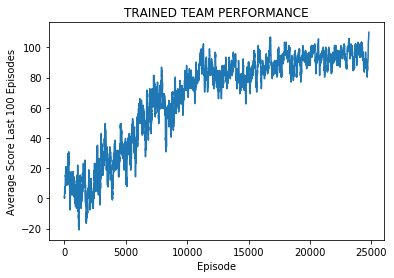

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rolling_average)+1), rolling_average)
plt.title('TRAINED TEAM PERFORMANCE')
plt.ylabel('Average Score Last 100 Episodes')
plt.xlabel('Episode')
plt.show()

Policy loss for striker and goalie. It should stay in the range of (-1,1). Value loss and entropy should decline over time.

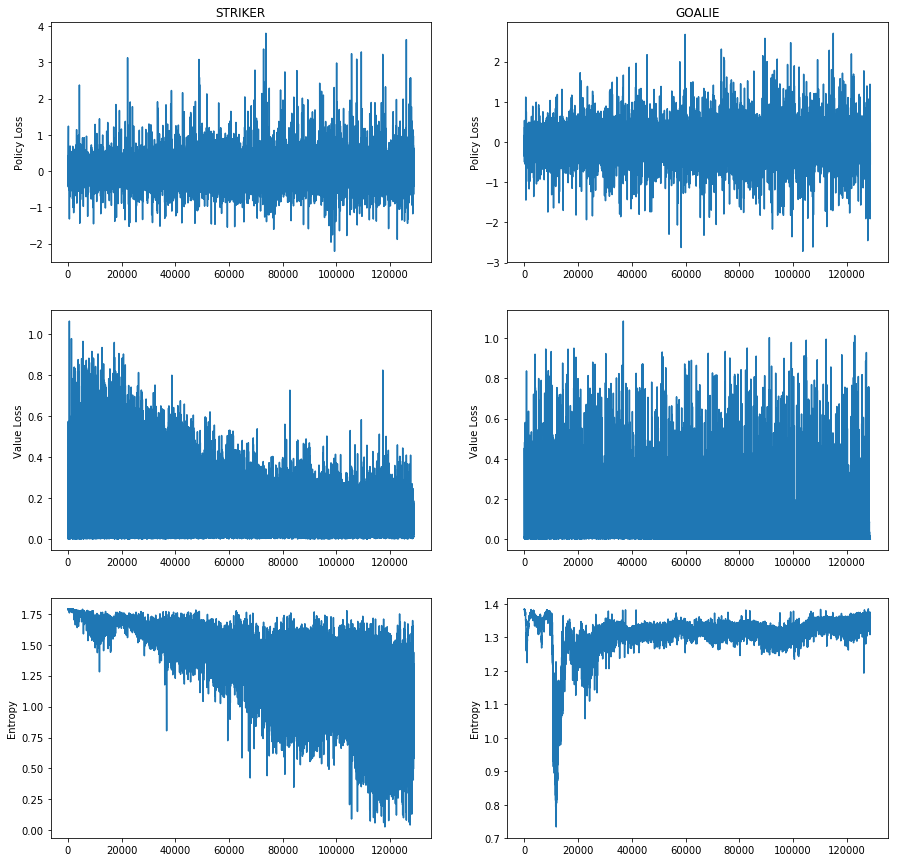

In [9]:
plt.figure(figsize=(15,15))

plt.subplot(3,2,1)
plt.plot(np.arange(1, len(policy_loss_value)+1), policy_loss_value)
plt.title('STRIKER')
plt.ylabel('Policy Loss')

plt.subplot(3,2,2)
plt.plot(np.arange(1, len(policy_loss_value_g)+1), policy_loss_value_g)
plt.title('GOALIE')
plt.ylabel('Policy Loss')

plt.subplot(3,2,3)
plt.plot(np.arange(1, len(value_loss_value)+1), value_loss_value)
plt.ylabel('Value Loss')

plt.subplot(3,2,4)
plt.plot(np.arange(1, len(value_loss_value_g)+1), value_loss_value_g)
plt.ylabel('Value Loss')

plt.subplot(3,2,5)
plt.plot(np.arange(1, len(entropy_value)+1), entropy_value)
plt.ylabel('Entropy')

plt.subplot(3,2,6)
plt.plot(np.arange(1, len(entropy_value_g)+1), entropy_value_g)
plt.ylabel('Entropy')

plt.show()

### 8. Watch The Trained Agents

The below code will load the trained actors (stiker and goalie) and run 100 games. A well trained team should win nearly all 100 games with a total score near 110. The other team is taking random actions.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

striker_0_actor = Actor(s_state_size, s_action_size, hidden_0, hidden_1).to(device)
goalie_0_actor = Actor(g_state_size, g_action_size, hidden_0, hidden_1).to(device)

# Load the saved training parameters
striker_0_actor.load_state_dict(torch.load('checkpoint_striker_0_actor.pth', map_location='cpu'))
goalie_0_actor.load_state_dict(torch.load('checkpoint_goalie_0_actor.pth', map_location='cpu'))

# Set environment to evalulation mode
env_info = env.reset(train_mode=False)        
g_states = env_info[g_brain_name].vector_observations  
s_states = env_info[s_brain_name].vector_observations  

team_0_score = 0
team_1_score = 0
team_0_delta = 0
team_0_lead = []

print("*** Starting the first game ***")

for i in range(100):

    g_scores = np.zeros(num_g_agents)                      
    s_scores = np.zeros(num_s_agents)           

    while True:
        states_all = combine_states(g_states, s_states)
        g0_prob, g0_action = act(goalie_0_actor, g_states[0])
        s0_prob, s0_action = act(striker_0_actor, s_states[0])
        g_actions = np.array([g0_action, np.random.choice(g_action_size)])
        s_actions = np.array([s0_action, np.random.choice(s_action_size)])
        actions = dict(zip([g_brain_name, s_brain_name], [g_actions, s_actions]))
        env_info = env.step(actions)                       

        g_next_states = env_info[g_brain_name].vector_observations         
        s_next_states = env_info[s_brain_name].vector_observations

        done = np.any(env_info[g_brain_name].local_done)  
        
        #update scores
        g_rewards = env_info[g_brain_name].rewards  
        s_rewards = env_info[s_brain_name].rewards
        g_scores += g_rewards
        s_scores += s_rewards

        # exit loop if episode finished
        if done:                                           
            break

        # roll over states to next time step
        g_states = g_next_states
        s_states = s_next_states
    
    # calculate team scores and team 0 lead
    team_0_score = round(g_scores[0] + s_scores[0], 2)
    team_1_score = round(g_scores[1] + s_scores[1], 2)
    team_0_delta = round(team_0_score + team_0_delta, 2)
    team_0_lead.append(team_0_delta)
        
    print('Episode {}:\tTrained Team Score: {}      Cumulative Score: {}'.format(i+1, team_0_score, team_0_delta))

print("*** Last game finished ***")

*** Starting the first game ***
Episode 1:	Trained Team Score: 1.1      Cumulative Score: 1.1
Episode 2:	Trained Team Score: 1.1      Cumulative Score: 2.2
Episode 3:	Trained Team Score: 1.1      Cumulative Score: 3.3
Episode 4:	Trained Team Score: 1.1      Cumulative Score: 4.4
Episode 5:	Trained Team Score: 1.1      Cumulative Score: 5.5
Episode 6:	Trained Team Score: 1.1      Cumulative Score: 6.6
Episode 7:	Trained Team Score: 1.1      Cumulative Score: 7.7
Episode 8:	Trained Team Score: 1.1      Cumulative Score: 8.8
Episode 9:	Trained Team Score: 1.1      Cumulative Score: 9.9
Episode 10:	Trained Team Score: 1.1      Cumulative Score: 11.0
Episode 11:	Trained Team Score: 1.1      Cumulative Score: 12.1
Episode 12:	Trained Team Score: 1.1      Cumulative Score: 13.2
Episode 13:	Trained Team Score: 1.1      Cumulative Score: 14.3
Episode 14:	Trained Team Score: 1.1      Cumulative Score: 15.4
Episode 15:	Trained Team Score: 1.1      Cumulative Score: 16.5
Episode 16:	Trained Team S

When finished, you can close the environment.

In [ ]:
#env.close()